#### Short overview of data

* There are 8 classes of cancer tissues => multiclass classification
* Kather_texture_2016_image_tiles_5000 are 150 x 150 pixels in size and has 5000 samples

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import imageio

from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Data observation

#### Medium 28x28x3 images

In [2]:
medium_colored_data = pd.read_csv('colorectal-histology-mnist/hmnist_28_28_RGB.csv')
medium_colored_data.shape

(5000, 2353)

As described, there are 5000 samples. There are 2353 pixels which possibly corresponds to 28x28x3 = 2354 and one class label. Now, how are the pixels ordered? The color, width and height must be described. Let's try plotting it to see

Text(0, 0.5, 'Height')

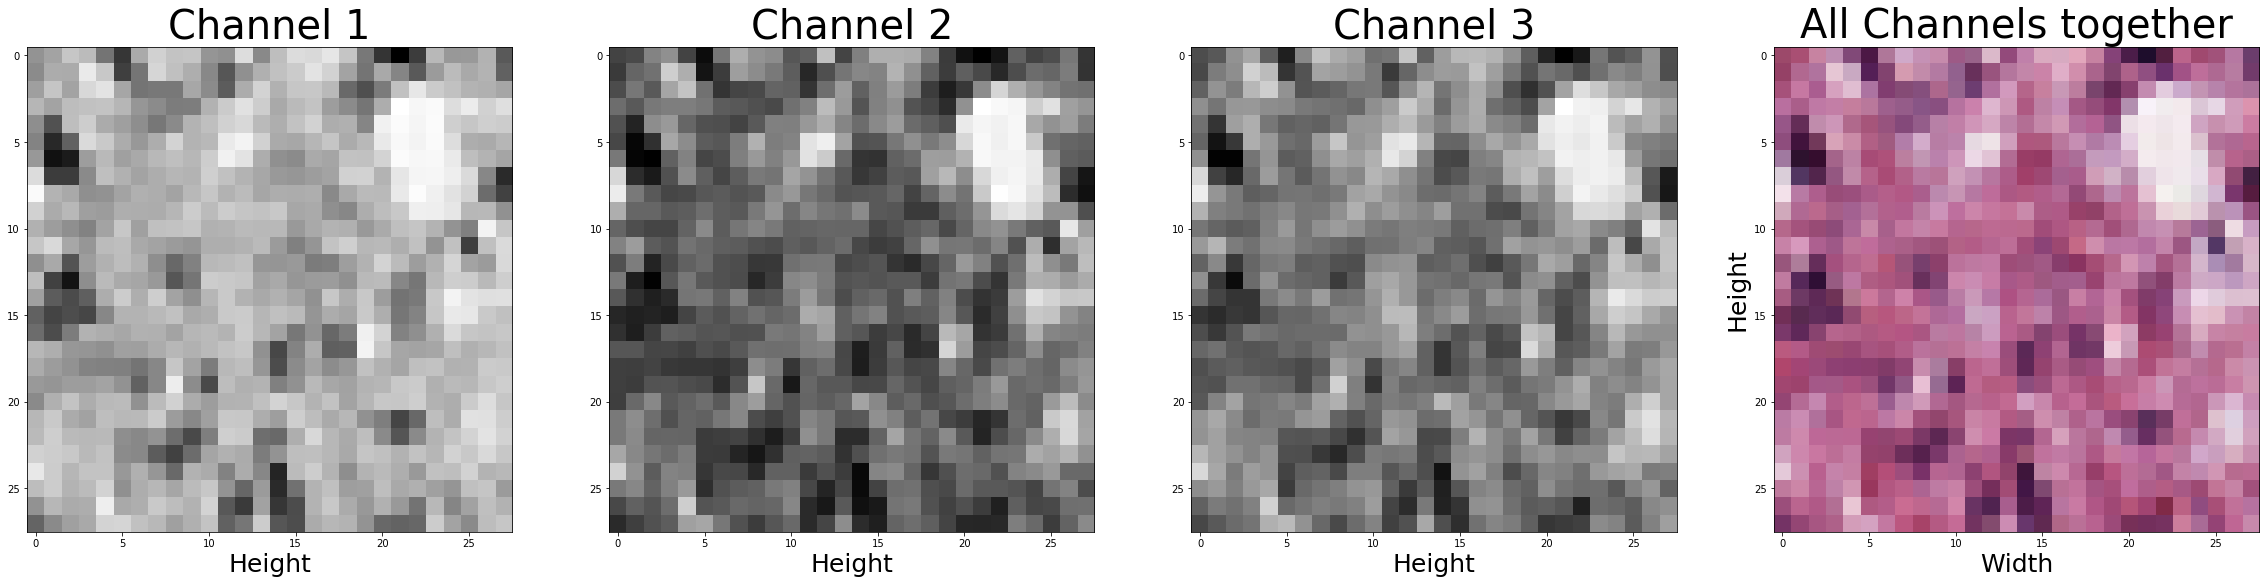

In [3]:
sample = medium_colored_data.drop('label',axis=1).values[0]
to_show = sample.reshape((28,28,3))

fig, ax = plt.subplots(1,4,figsize = (40,40))
for channel in range(3):
    ax[channel].imshow(to_show[:,:,channel],cmap='gray')
    ax[channel].set_title('Channel {}'.format(channel+1), fontsize = 40)
    ax[channel].set_xlabel('Width',fontsize = 25)
    ax[channel].set_xlabel('Height',fontsize = 25)
ax[3].imshow(to_show)
ax[3].set_title('All Channels together', fontsize = 40)
ax[3].set_xlabel('Width', fontsize = 25)
ax[3].set_ylabel('Height', fontsize = 25)

This looks alright. The 3 images seem to be the same spatially. Let's now see what reshape does. 

In [4]:
order_example = np.arange(0,12)
show_order = order_example.reshape(2,2,3)
print(show_order[:,:,0])
print(show_order[:,:,1])
print(show_order[:,:,2])

[[0 3]
 [6 9]]
[[ 1  4]
 [ 7 10]]
[[ 2  5]
 [ 8 11]]


We can see from the above that the spatial location of the first 3 numbers is the same in the three matrices. This indicates that the first pixel is described with RGB. The number 3 appears to the right of 0 which means that the pixel moves to the right. So the ordering is color, width, height.

In [5]:
def show_inarow(data, row_shape):
    example = data.drop("label", axis=1).values[0:4]
    to_show = example.reshape(row_shape)
    fig, ax = plt.subplots(1,4,figsize=(30,30))
    for image_example in range(4):
        ax[image_example].imshow(to_show[image_example,:,:], cmap="gray")
        ax[image_example].set_title("Image {}".format(image_example+1), fontsize = 30)
        ax[image_example].set_xlabel("Width", fontsize = 25)
        ax[image_example].set_ylabel("Height", fontsize = 25)

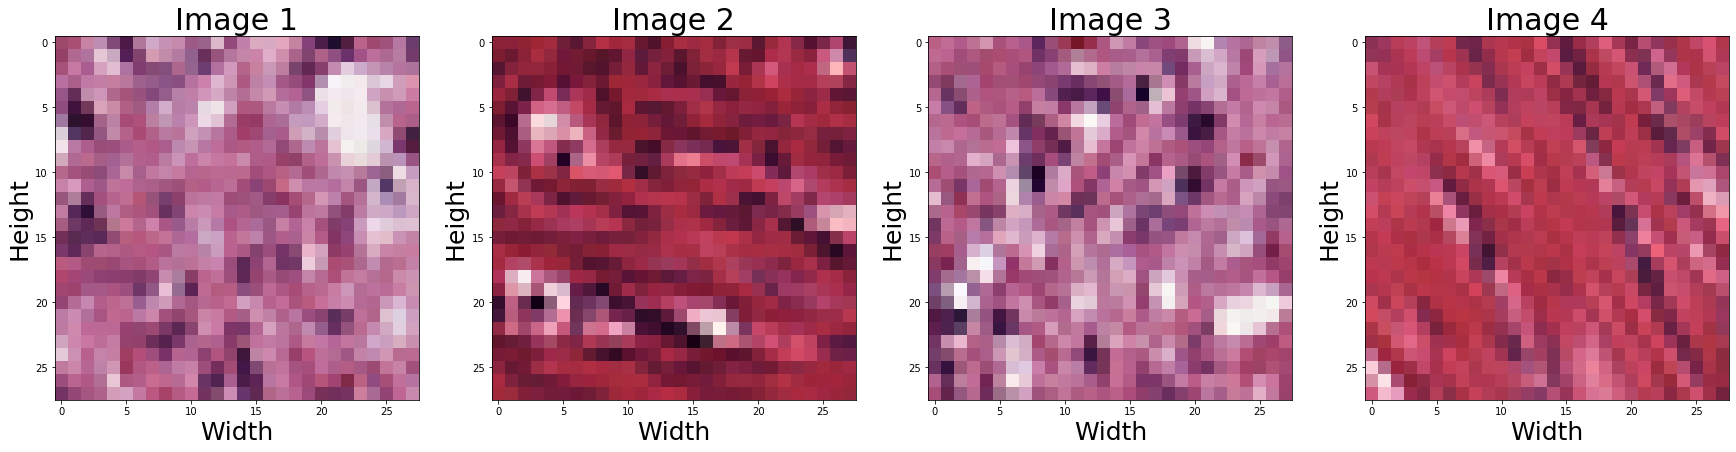

In [6]:
show_inarow(medium_colored_data, (4,28,28,3))

#### Large 64x64 images

In [2]:
big_data = pd.read_csv('colorectal-histology-mnist/hmnist_64_64_L.csv')
big_data.shape

(5000, 4097)

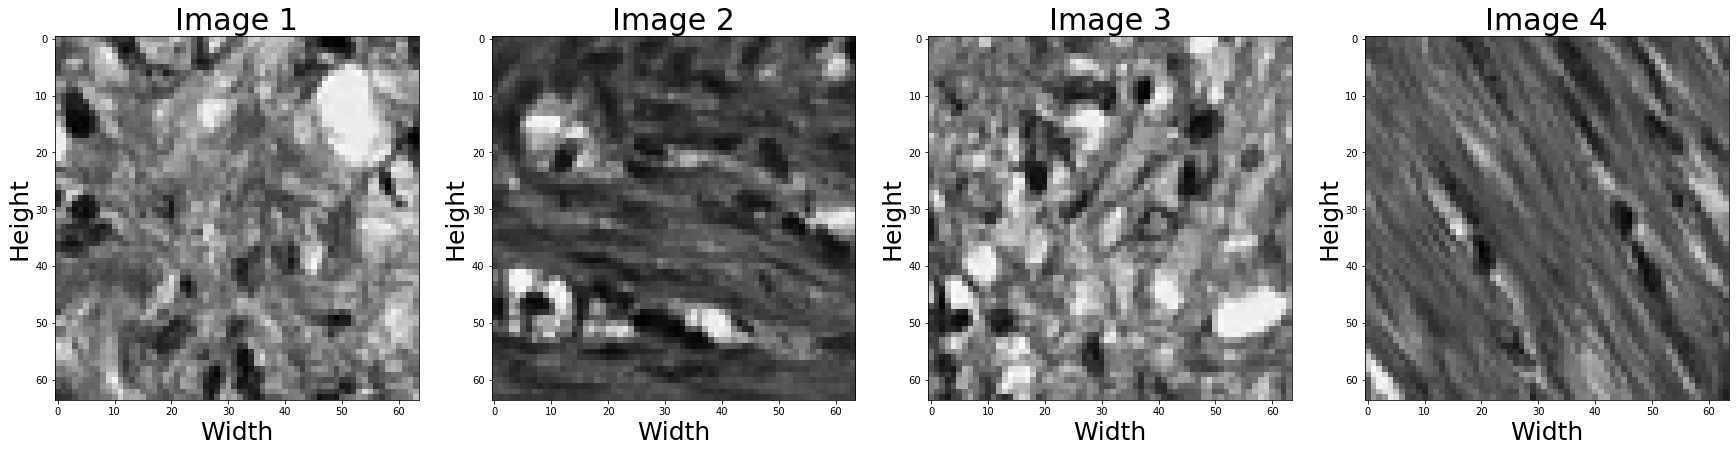

In [8]:
show_inarow(big_data, (4,64,64))

This seems to be good to work with. The features seem to be clearly visible to the naked eye. Hopefully the learned model can recognize the features!

#### Full resolution 150x150x3 images

In [9]:
classes_dir = listdir("colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000")
files = listdir("colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR")
basepath = "colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/"

In [10]:
def show_set(basepath, classes_dir, num_file):
    fig, ax = plt.subplots(2,4,figsize=(20,10))
    for n in range(4):
        for m in range(2):
            class_idx = m * 4 + n
            path = basepath + classes_dir[class_idx] + "/"
            files = listdir(path)
            image = imageio.imread(path + files[num_file])
            ax[m,n].imshow(image)
            ax[m,n].set_title(classes_dir[class_idx], fontsize = 20)

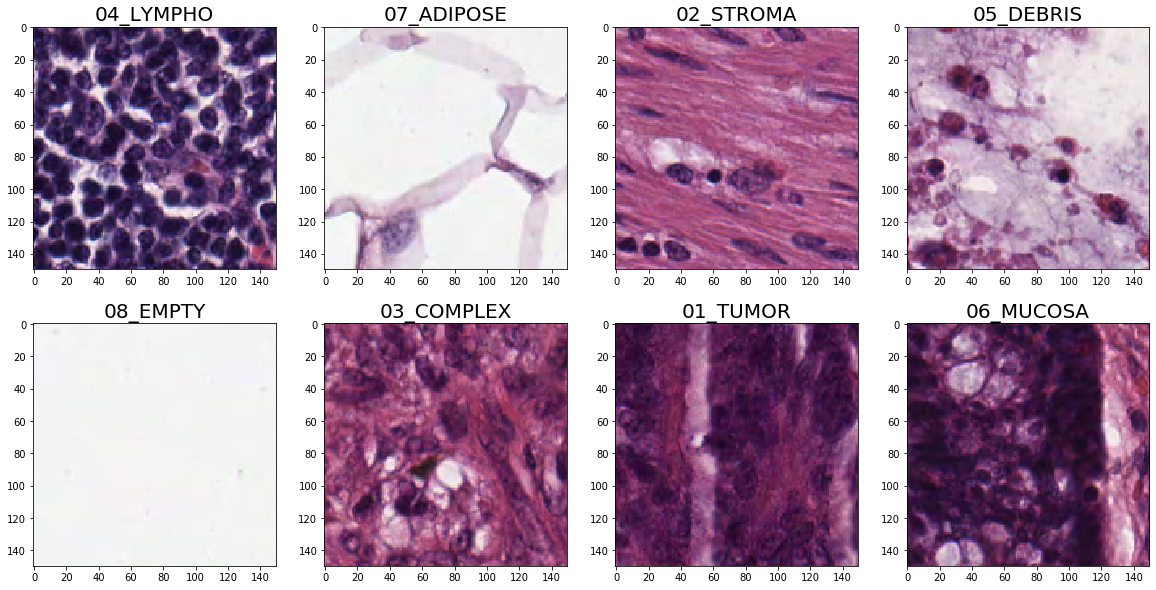

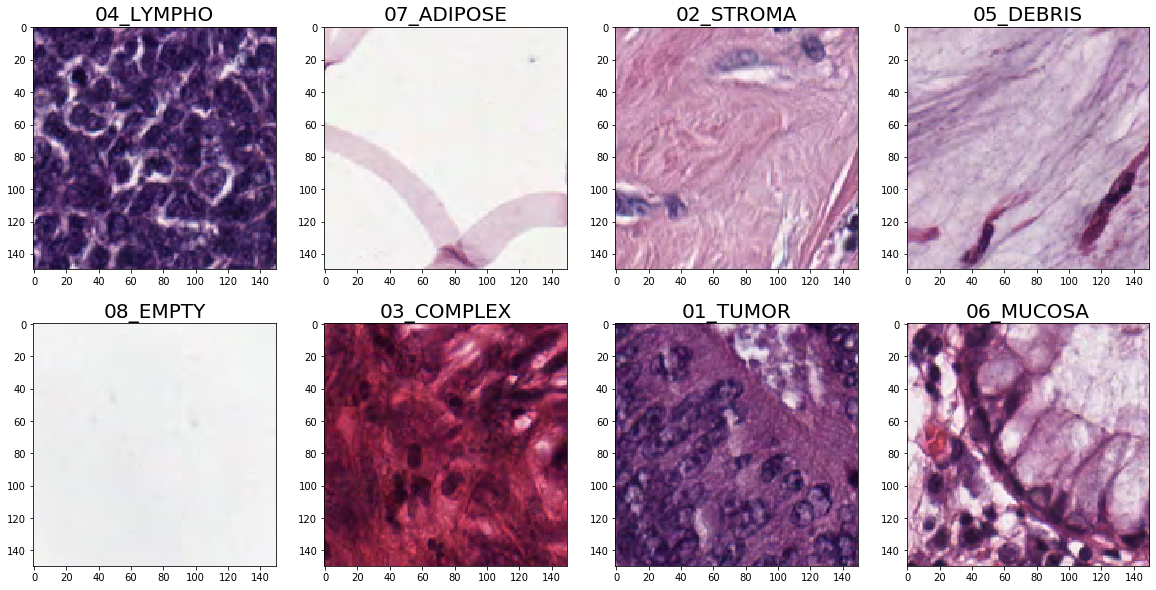

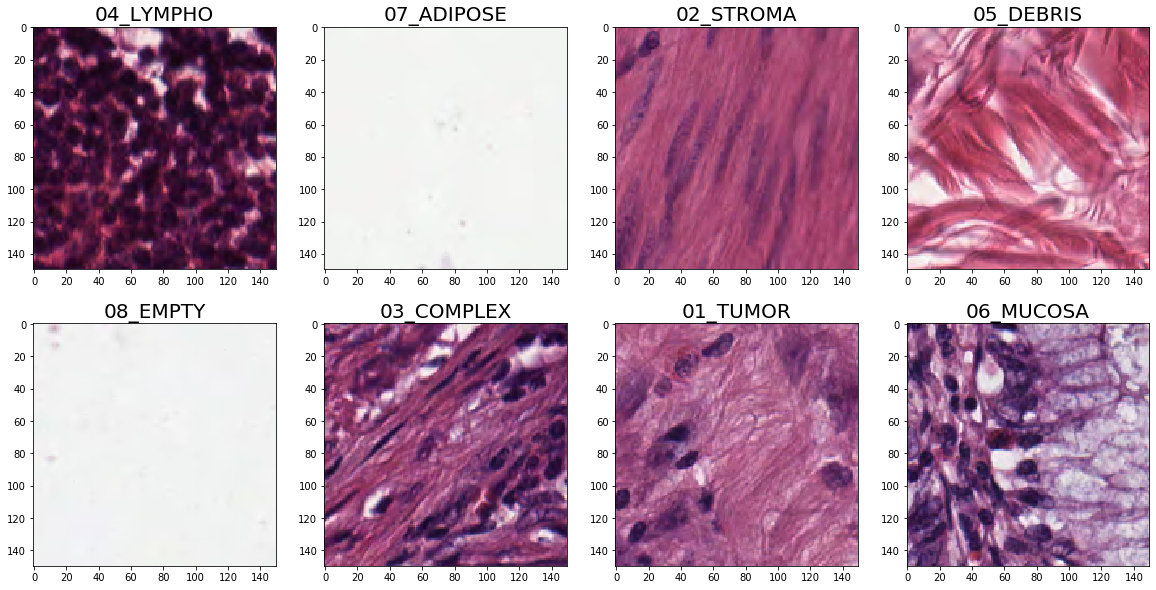

In [11]:
for i in range(3):
    show_set(basepath, classes_dir, num_file=i)

Things to note:
* Look at the 3 lympho tissues - they have the same features but the RGB scaling seems to be different. So maybe a grayscaled version will do better.
* The Empty tissues and Adipose tissues are mainly empty with high intensity. The Adipose tissue has some colored areas and this is what differentiates the two.
* The RGB scaling seems to be there in other tissues as well.

## Base model comparisons

These models will obviously not make any sense because features in an image don't depend on individual pixels but rather patterns. In any case let's just make these models to use as baseline for what we expect our later models to do better than.

In [12]:
big_data

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0           134         99        119        130        142        169   
1            55         64         74         63         74         75   
2           114        116        136        152        132        100   
3            86         82         88         85        103         93   
4           168        143        140        139        129        123   
...         ...        ...        ...        ...        ...        ...   
4995        154        159        165        162        155        155   
4996        148        119        154        147        132        137   
4997         30         29         37         60         66         93   
4998        105        115        108        105        111        125   
4999         60         77         84         49         15         23   

      pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel4087  pixel4088  \
0           152        139        117         87  ...        112         89   
1            71         73         70         77  ...         79         85   
2           151        150        127        205  ...        128        157   
3            98        109        104        115  ...         79         80   
4           123        141        137        101  ...        231        199   
...         ...        ...        ...        ...  ...        ...        ...   
4995        144        141        154        167  ...        139        104   
4996        147        170        177        163  ...        165        150   
4997         91         90         78         81  ...        230        231   
4998        123        109        109        118  ...        152        141   
4999         98         96        103         94  ...        116        118   

      pixel4089  pixel4090  pixel4091  pixel4092  pixel4093  pixel4094  \
0            73        100        120        120        126        140   
1            86         77         68         66         65         68   
2           159        205        182        143        129         89   
3           109        128         89         85         80         63   
4           183        195        179        134        142        158   
...         ...        ...        ...        ...        ...        ...   
4995        126        134        119        123        135        140   
4996        176        189        157        168        163        143   
4997        229        226        175        172        195         83   
4998        116        116        125         91         77         81   
4999        157        129        101        105         90         64   

      pixel4095  label  
0           195      2  
1            69      2  
2           122      2  
3            48      2  
4           149      2  
...         ...    ...  
4995        144      3  
4996        168      3  
4997         45      3  
4998         85      3  
4999         67      3  

[5000 rows x 4097 columns]

We will now want to split the data into train, validation and test data. Since the data is equally divided into the different classes, we might as well have our train, validation and test data have the same structure.

In [3]:
images = big_data
from sklearn.model_selection import train_test_split

temp, images_val = train_test_split(images, test_size = 0.2, stratify = images.label.values, random_state = 23)
images_train, images_test = train_test_split(temp, test_size = 0.2, stratify = temp.label.values, random_state = 24)

features = images.columns.tolist()
features.remove('label')

# Features, label split
images_train_feature = images_train[features]
images_train_label = np.array(images_train['label'])
images_test_feature=images_test[features]
images_test_label=np.array(images_test['label'])

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
def evaluate_models(in_model_maker,label):
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    
    c_df = images.copy()
    c_label = c_df.pop('label')
    c_model = in_model_maker()
    
    c_model.fit(images_train_feature,images_train_label)
    c_pred = c_model.predict(images_test_feature)
    sns.heatmap(confusion_matrix(images_test_label, c_pred), 
                    annot=True, cbar=False, fmt='d')
    print(accuracy_score(images_test_label,c_pred))
    ax.set_title('Accuracy: {}, {}'.format(accuracy_score(images_test_label,c_pred),label),fontsize = 20)

0.36875


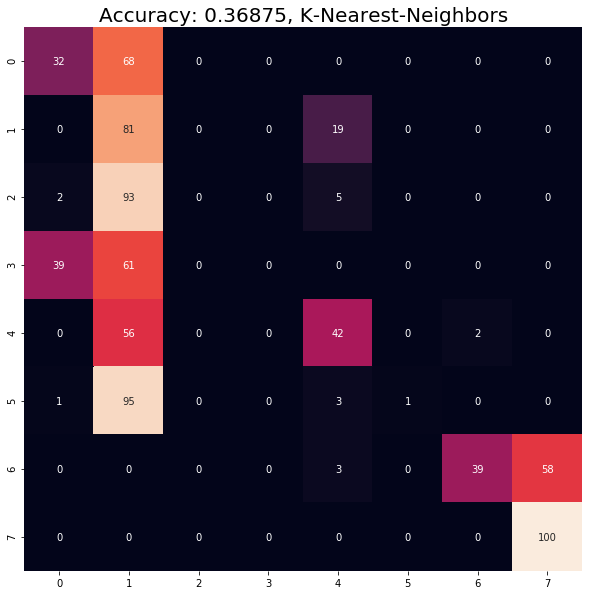

In [15]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_models(lambda : KNeighborsClassifier(n_jobs=1), 'K-Nearest-Neighbors')

/home/arunravishankar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.25375


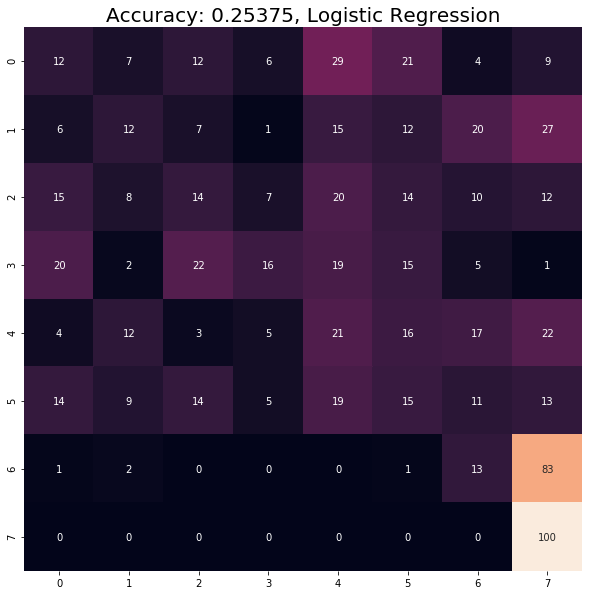

In [16]:
from sklearn.linear_model import LogisticRegression
evaluate_models(lambda : LogisticRegression(n_jobs=1, solver='lbfgs'), 'Logistic Regression')

/home/arunravishankar/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.57


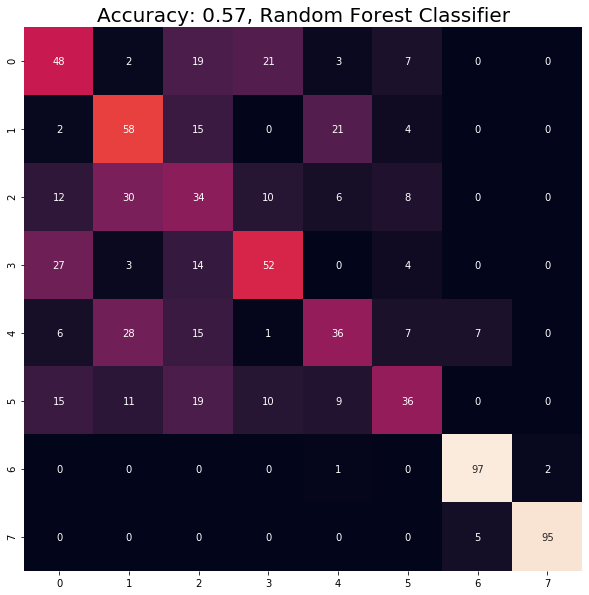

In [17]:
from sklearn.ensemble import RandomForestClassifier
evaluate_models(lambda : RandomForestClassifier(n_jobs=1), 'Random Forest Classifier')

The Random Forest Classifier seems to do the best, but still is not close to being acceptable. We can use this as our baseline for when we model the data with a Convoluted Neural Network.

## Image statistics

Having looked at the images, let us now look at some basic statistics of the images. Let's first look at the count of the different classes.

In [18]:
images = big_data
images['label'].value_counts()[:8]

7    625
3    625
6    625
2    625
5    625
1    625
8    625
4    625
Name: label, dtype: int64

Great! Each class has an equal number of samples. This makes us understand the resultant model better - there won't be any biases in the models learnt because there'll be a somewhat equal distribution of the classes in the training data.

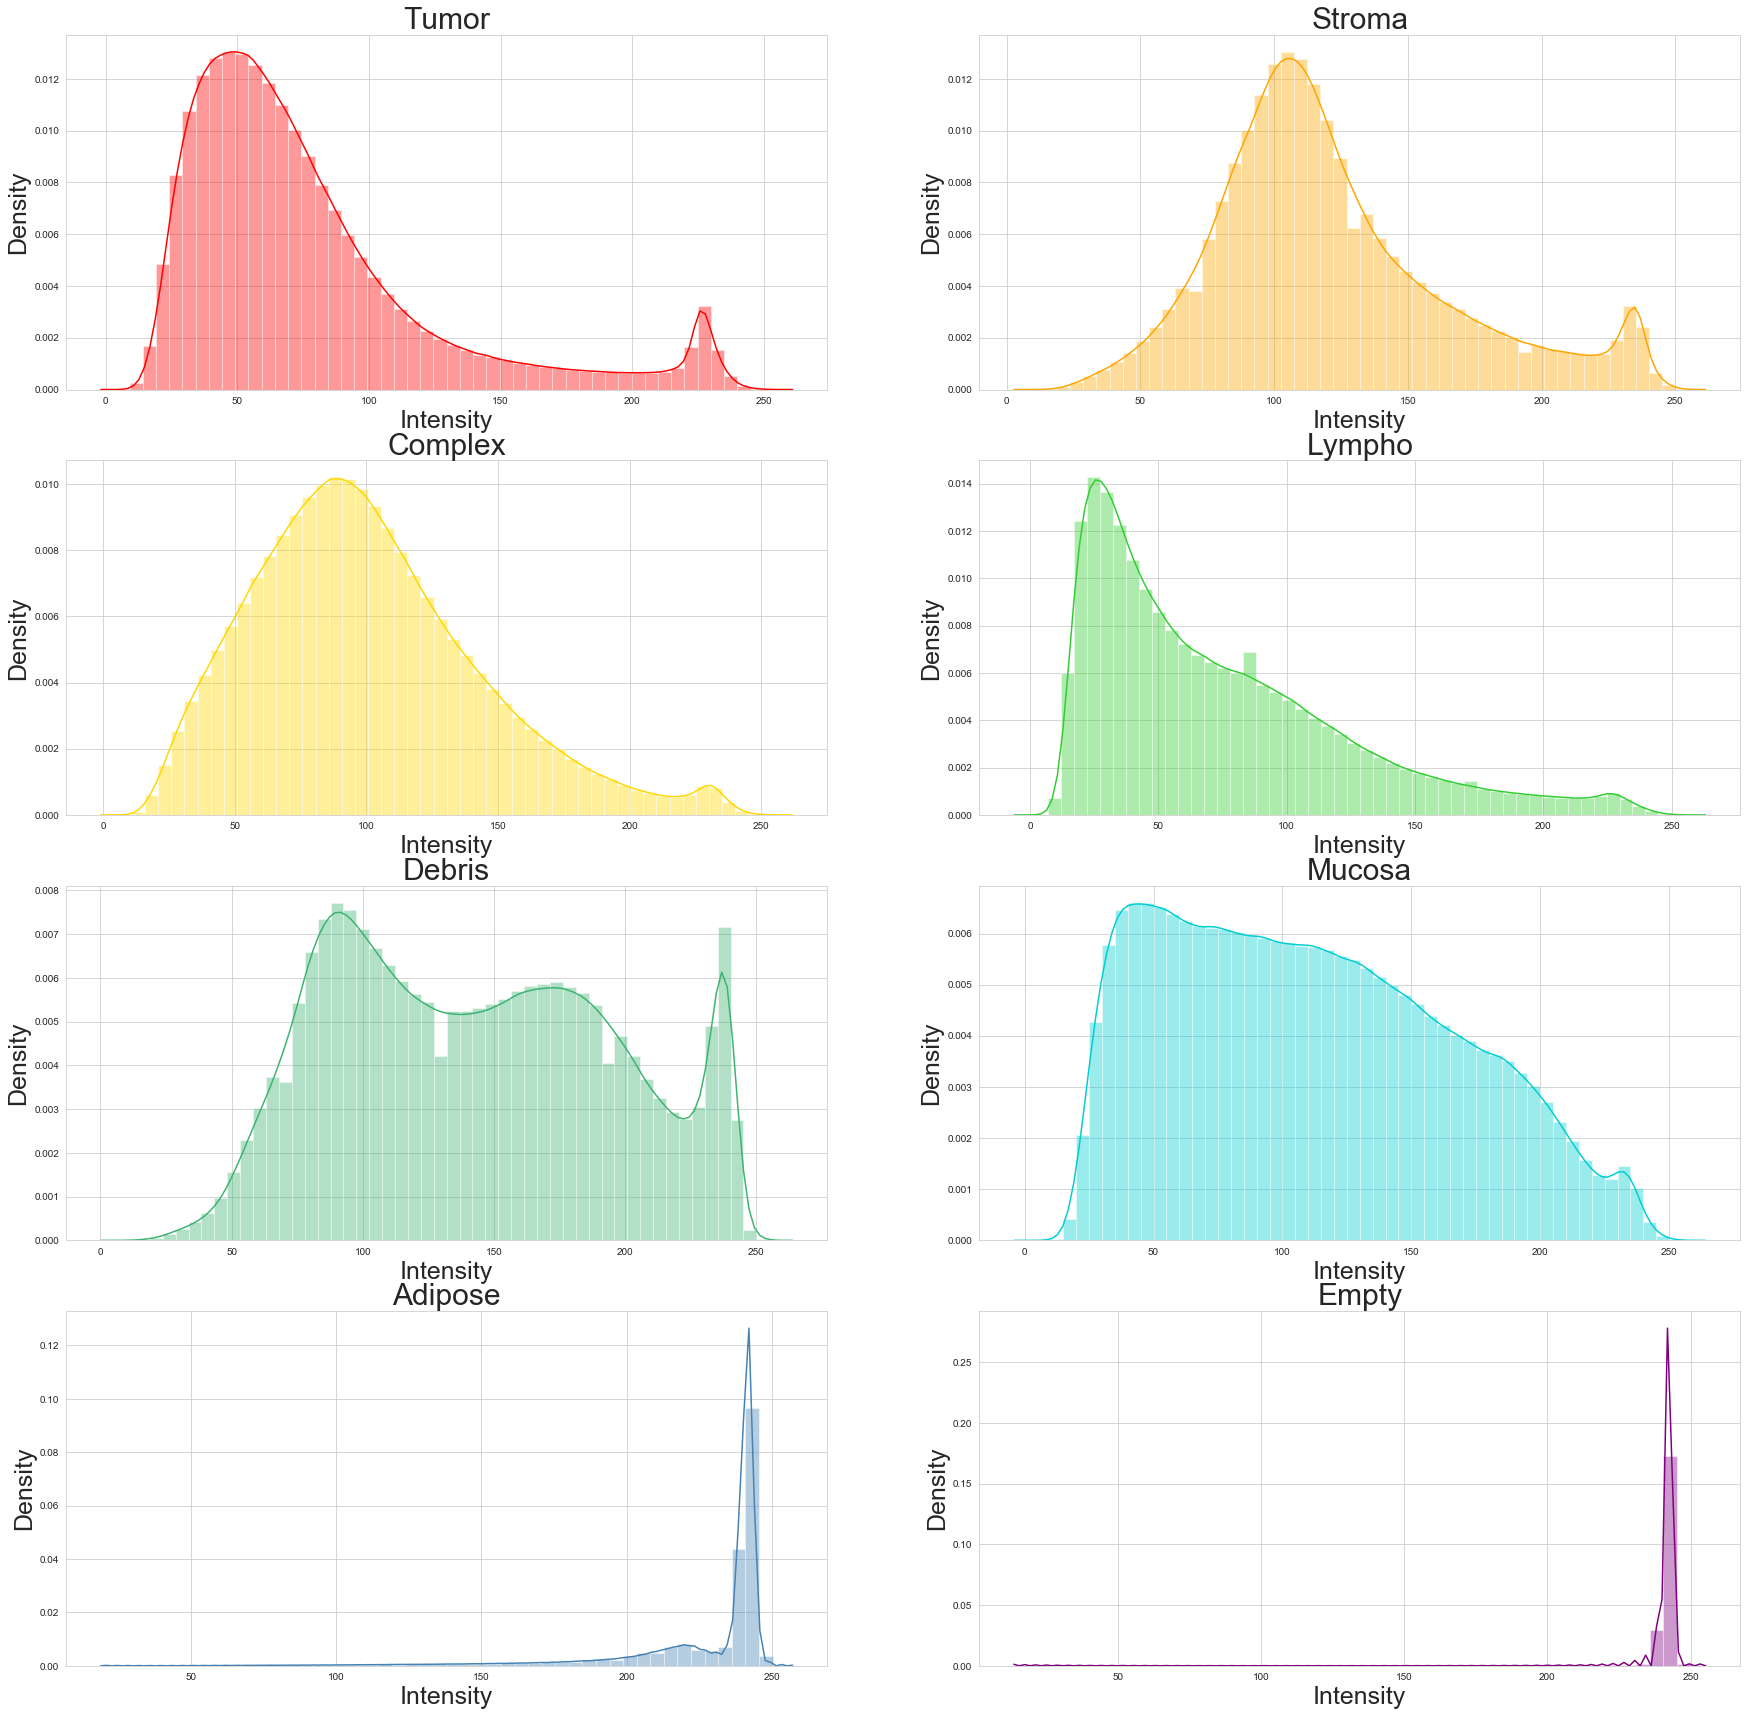

In [428]:
class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho",
               5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}
class_colors = {1: "Red", 2: "Orange", 3: "Gold", 4: "Limegreen",
                5: "Mediumseagreen", 6: "Darkturquoise", 7: "Steelblue", 8: "Purple"}
sns.set_style("whitegrid")
fig, ax = plt.subplots(4,2, figsize=(30,30))
for n in range(4):
    for m in range(2):
        class_idx = n*2+(m+1)
        sns.distplot(images[images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx])
        ax[n,m].set_title(class_names[class_idx],fontsize = 30)
        ax[n,m].set_xlabel("Intensity", fontsize = 25)
        ax[n,m].set_ylabel("Density", fontsize = 25)

We see from this plot of the intensity density of each class, as we expected, the intensity density of the Adipose and Empty tissues are sharply peaked at a high value. This alone can differentiate between these two and the other classes! The other classes have either a bimodal or trimodal curve. Let's see if this will be helpful or useful later.

#### Overall image statistics

* The mean and standard deviation are not useful quantities since we have bimodal and trimodal distributions. 
* So let's look at quantile information.

In [20]:
def get_overall_statistics(data, cancer_class):
    class_intensities = data[data.label == cancer_class].values.flatten()
    class_stats = np.zeros(10)
    class_stats[0] = stats.mode(class_intensities)[0][0]
    for q in range(1, 10):
        class_stats[q] = np.quantile(class_intensities, (q * 10)/100)
    return class_stats

stats_quantities = ["Mode", "Q10", "Q20", "Q30", "Q40", "Median", "Q60", "Q70", "Q80", "Q90"]
overall_statistics = pd.DataFrame(index = np.arange(1,9), columns=stats_quantities)

for class_idx in range(1,9):
    overall_statistics.loc[class_idx,:] = get_overall_statistics(images, class_idx)

overall_statistics = overall_statistics.reset_index()
overall_statistics["index"] = overall_statistics["index"].apply(lambda l : class_names[l])
overall_statistics = overall_statistics.set_index("index")
overall_statistics.index.name = None

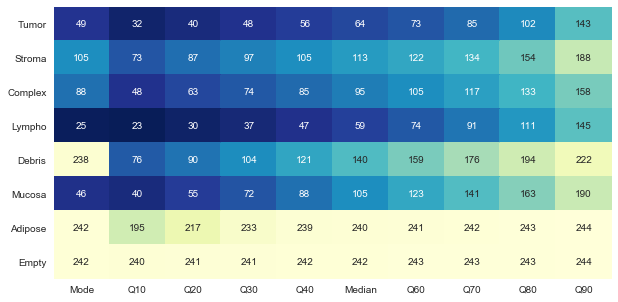

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.heatmap(overall_statistics, annot=True, cbar=False, fmt="g", cmap="YlGnBu_r", ax=ax)

Now these are the overall image statistics. Does each individual image reflect this same behaviour or do we have a lot of outliers?

#### Individual image statistics

We now want to look at the mode of the intensity of each individual image and compare that with the mode of the total distribution. If the density of modes of each individual image stacks up with the mode of the whole distribution, then we have basically one kind of image. 

In [85]:
image_statistics = pd.DataFrame(index=images.index)
image_statistics["{}".format('Mode')] = images.apply(lambda l: stats.mode(l)[0][0], axis=1)
for q in range(1, 10):
    col_name = "Q" + str(q*10)
    image_statistics[col_name] = images.apply(lambda l: np.quantile(l, (q*10)/100), axis=1)

image_statistics["label"] = images.label.values
image_statistics.head()

Mode   Q10    Q20    Q30    Q40    Q50    Q60    Q70    Q80    Q90  label
0   122  82.0  100.0  112.0  122.0  130.0  140.0  152.0  167.0  189.0      2
1    71  44.0   53.0   60.0   67.0   73.0   79.0   85.0   95.0  120.4      2
2   122  75.0   95.0  108.0  117.0  127.0  137.6  150.0  166.0  193.0      2
3    99  72.0   81.0   87.0   93.0   97.0  102.0  108.0  116.0  132.0      2
4   125  90.0  104.0  114.0  123.0  131.0  141.0  152.0  163.0  181.0      2

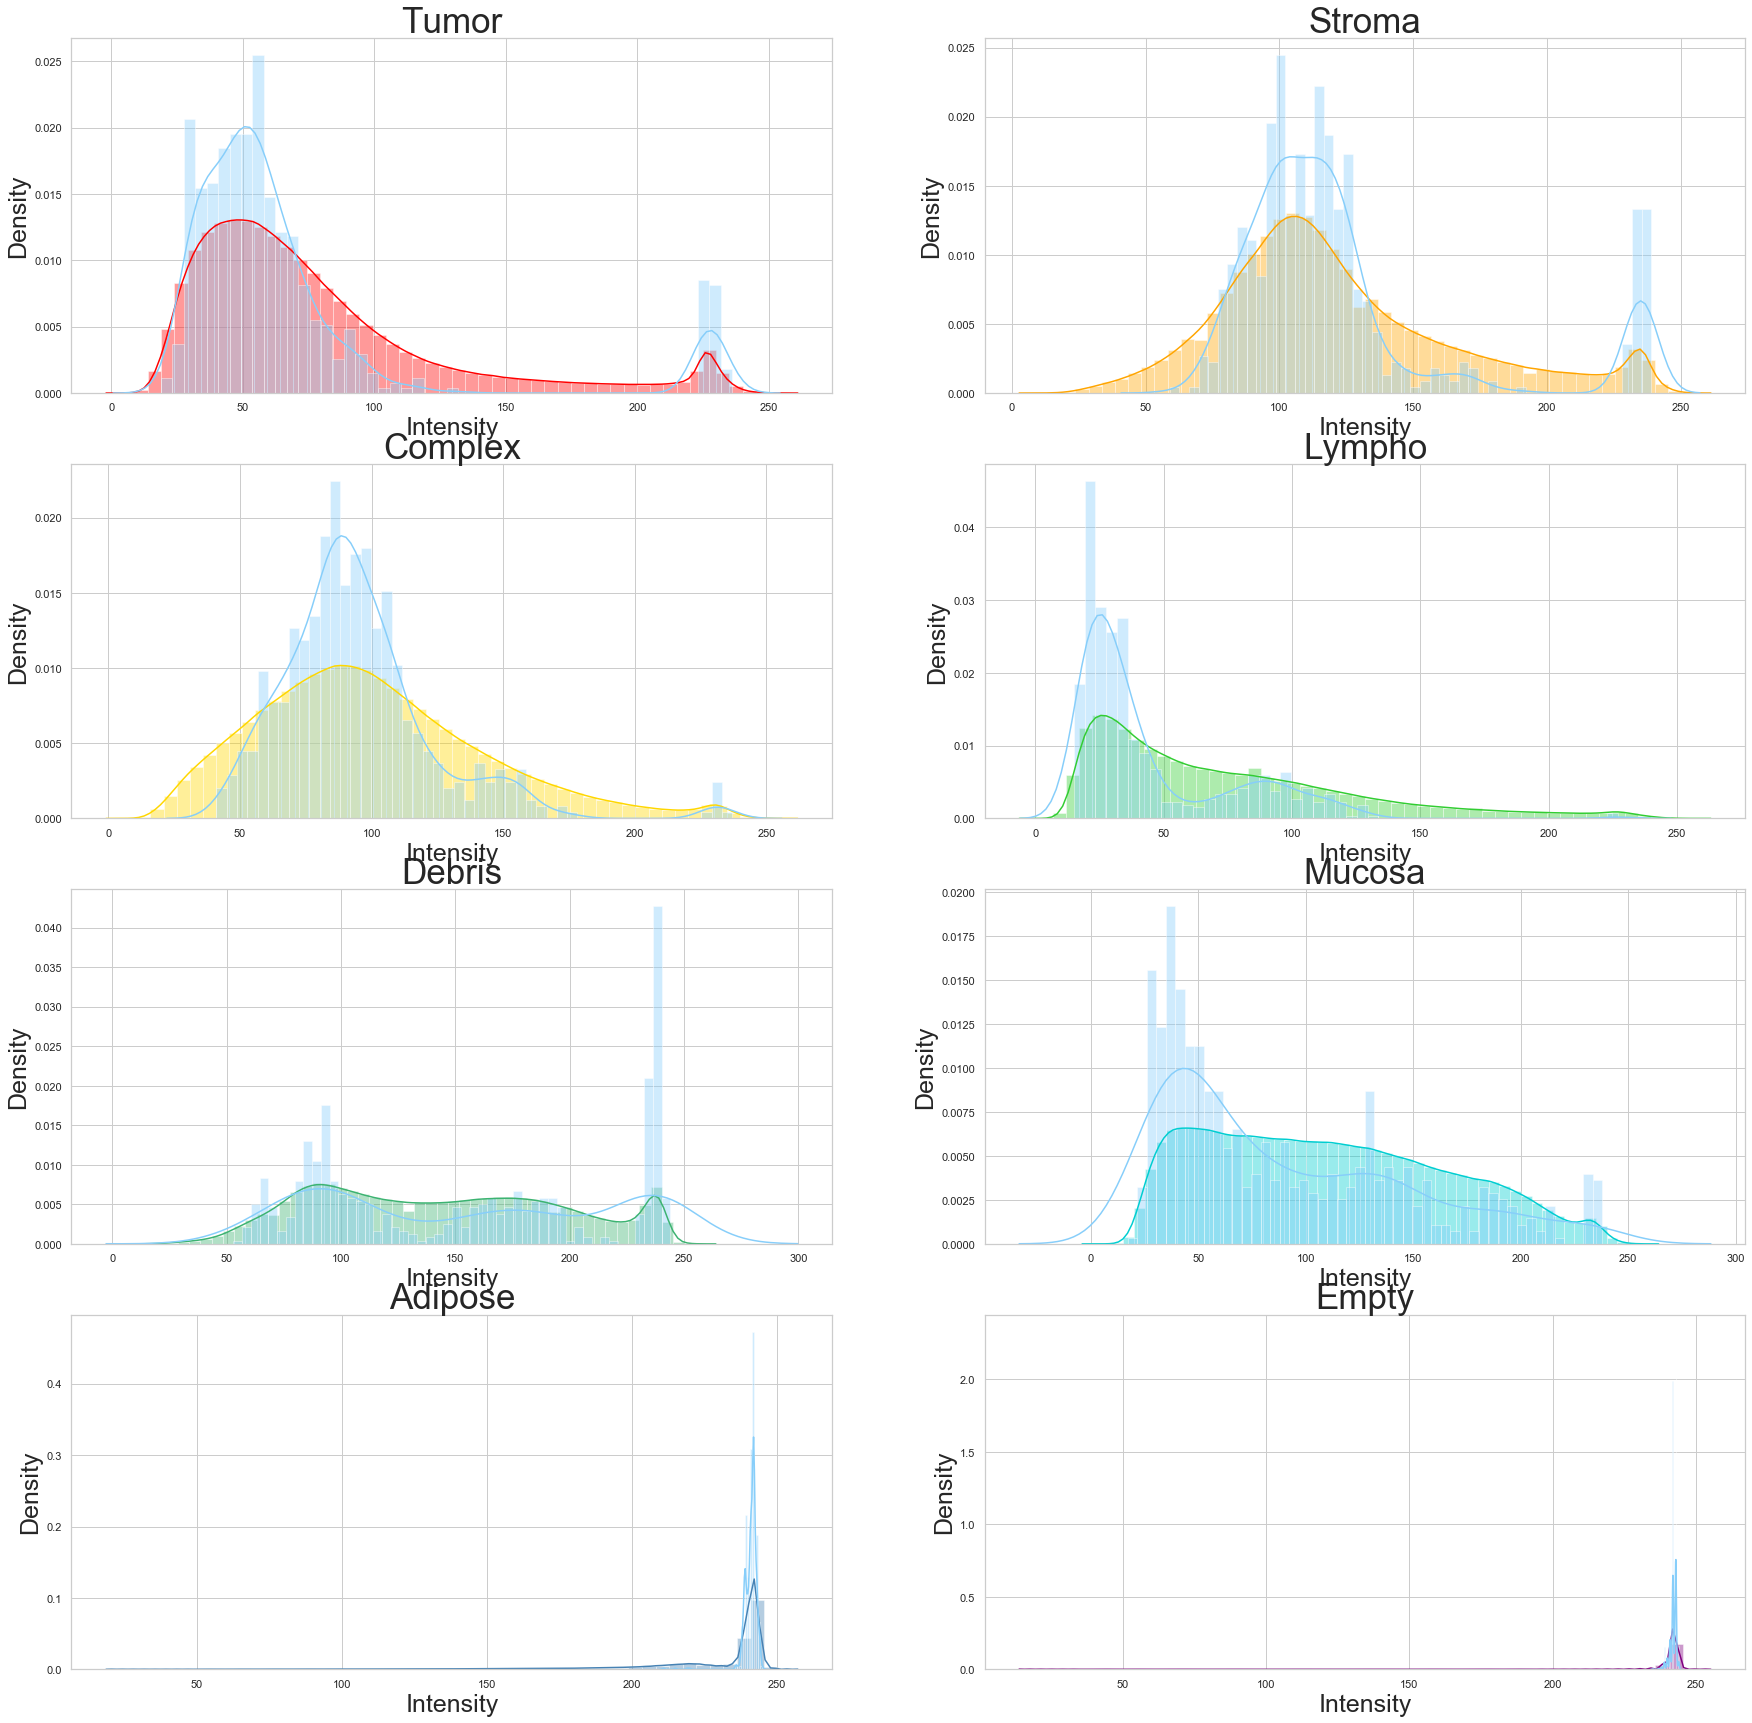

In [86]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(4,2, figsize=(30,30))
for n in range(4):
    for m in range(2):
        class_idx = n*2+(m+1)
        sns.distplot(images[images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx], 
                     norm_hist=True,
                     bins=50)
        sns.distplot(image_statistics[image_statistics.label == class_idx]['Mode'].values,
                     ax=ax[n,m],
                     color="lightskyblue",
                     norm_hist=True, 
                     bins=50)
        ax[n,m].set_title(class_names[class_idx], fontsize = 35)
        ax[n,m].set_xlabel("Intensity", fontsize = 25)
        ax[n,m].set_ylabel("Density", fontsize = 25)

This is interesting! What we see here is that the density of mode of each individual image stacks up with the peaks in the intensity graph of the total distribution. This indicates that there are images which are outliers (different kinds of images from the ones with the other mode). Take for instance the Tumor. The distribution of the intensity of all images is bimodal. The distribution of modes of each image also is bimodal. This indicates that those images with the mode with the larger intensity has a lot of white space (high intensity) but have still been classified as Tumors. This same argument holds for Stroma, Debris and partly for Complex as well.

If we use neural networks to classify cancer, these different images within a class, will cause the model to draw bad decision boundaries.

## Clustering

We have to find out of there are more kinds of tissues than classes. Let's try clustering the images based on the image statistics to reveal hidden kinds of tissues.

Let us use a Gaussian Mixture model for this purpose using the images statistics as the feature.

Here's a short reference for Gaussian Mixture models - https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

In [87]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [88]:
scaler = StandardScaler()
X = scaler.fit_transform(image_statistics.drop("label", axis=1).values)
y = image_statistics.label.values

In [89]:
def model_plotting(stat,no_comp, cov_type, mod):
    model = mod(n_components=no_comp,
                        covariance_type=cov_type,
                        n_init=10,
                        random_state=1)
    cluster = model.fit_predict(X)
    stat["cluster"] = cluster
    counts = stat.groupby("label").cluster.value_counts()
    counts = counts.unstack()
    counts.fillna(0, inplace=True)

    sns.set()
    plt.figure(figsize=(20,13))
    for n in range(no_comp):
        for m in range(1,9):
            plt.scatter(n, m, s=counts.loc[m,n], color=class_colors[m])
    plt.xlabel("Cluster",fontsize = 25)
    plt.yticks(np.arange(1,9), [class_names[label] for label in list(np.arange(1,9))],fontsize=25);
    plt.title("Cancer type per cluster", fontsize = 35);

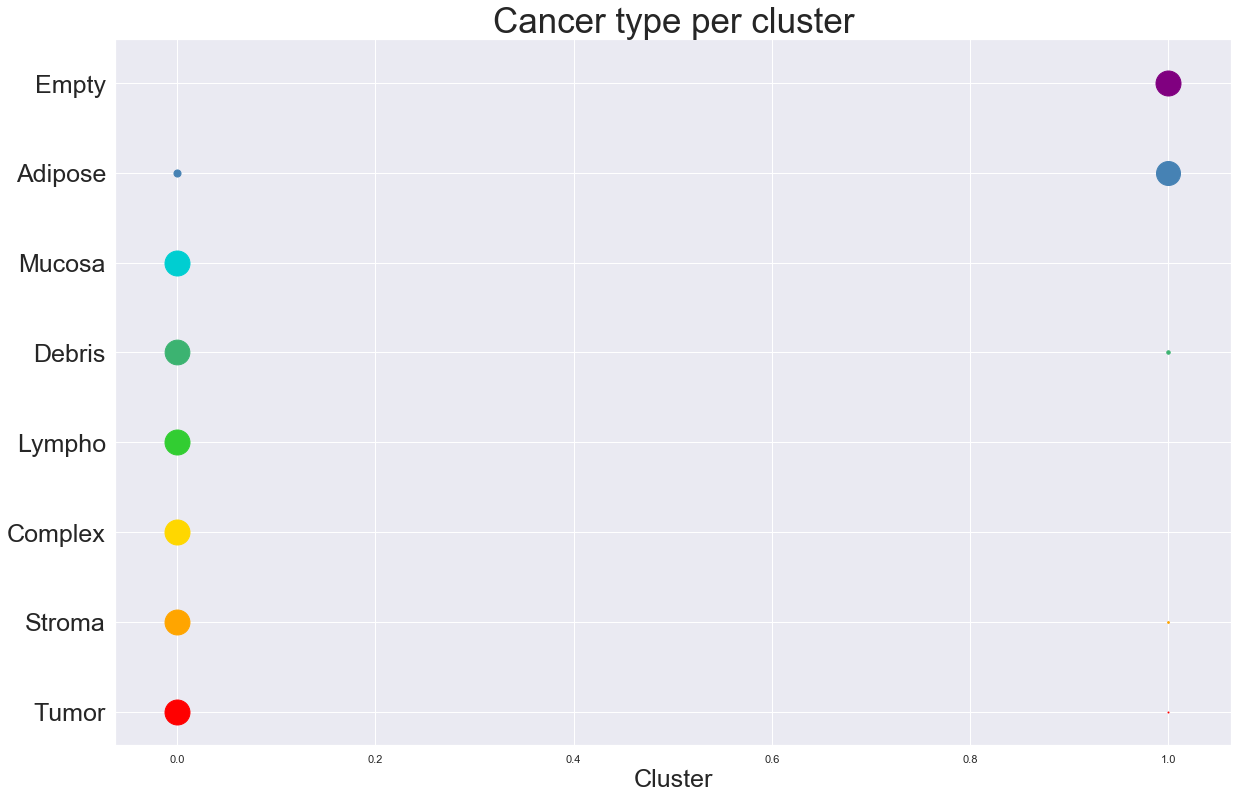

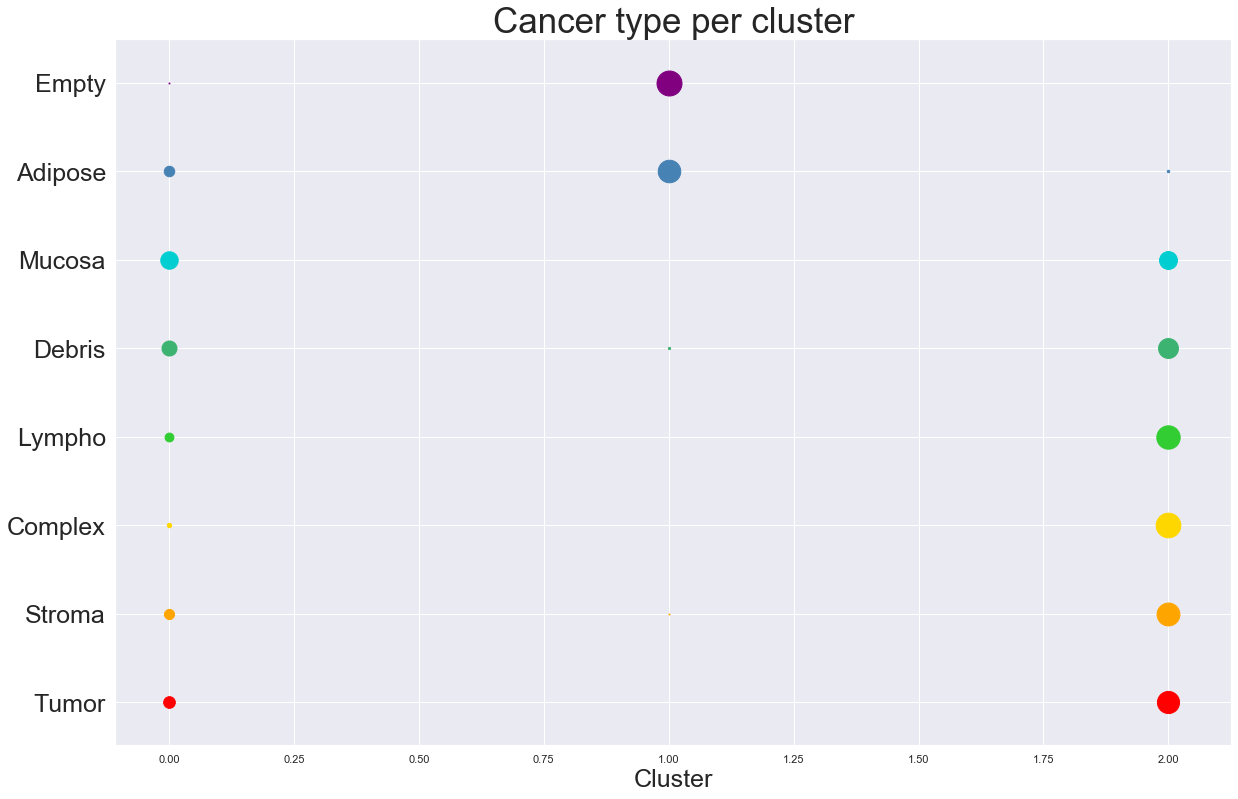

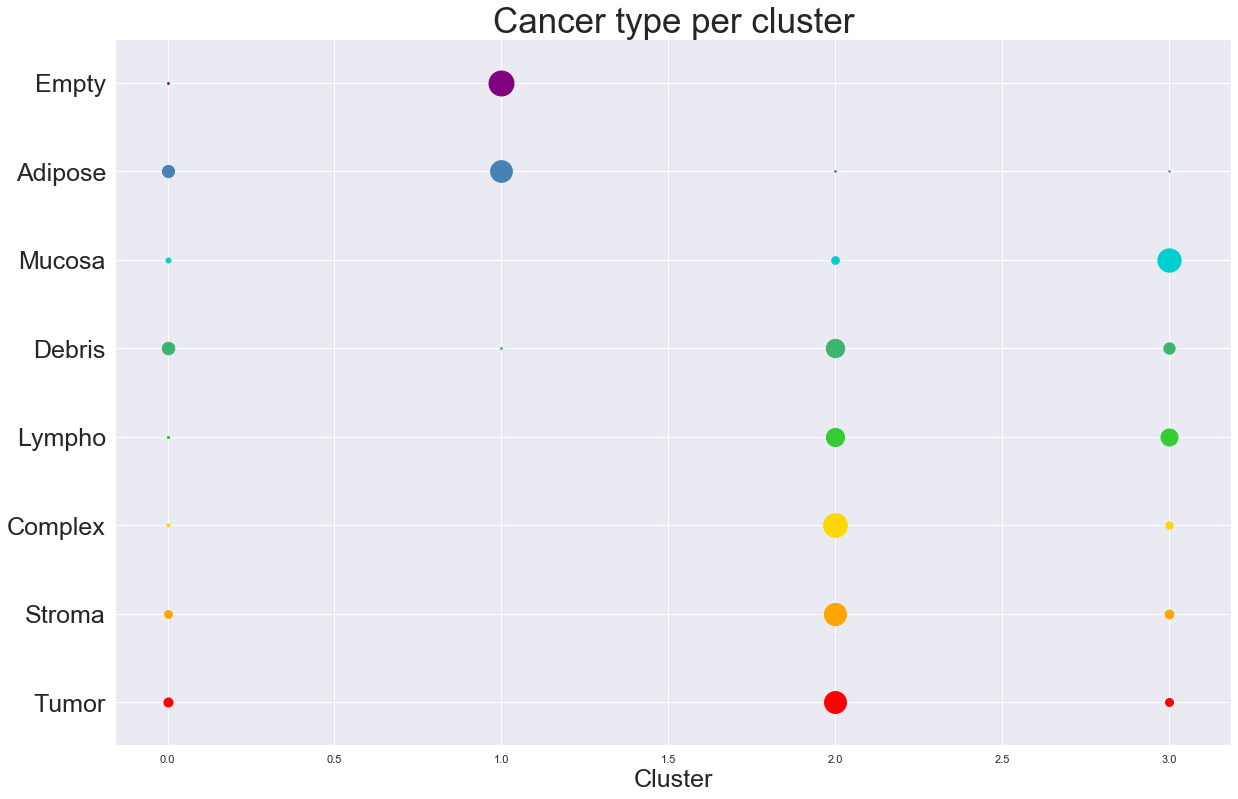

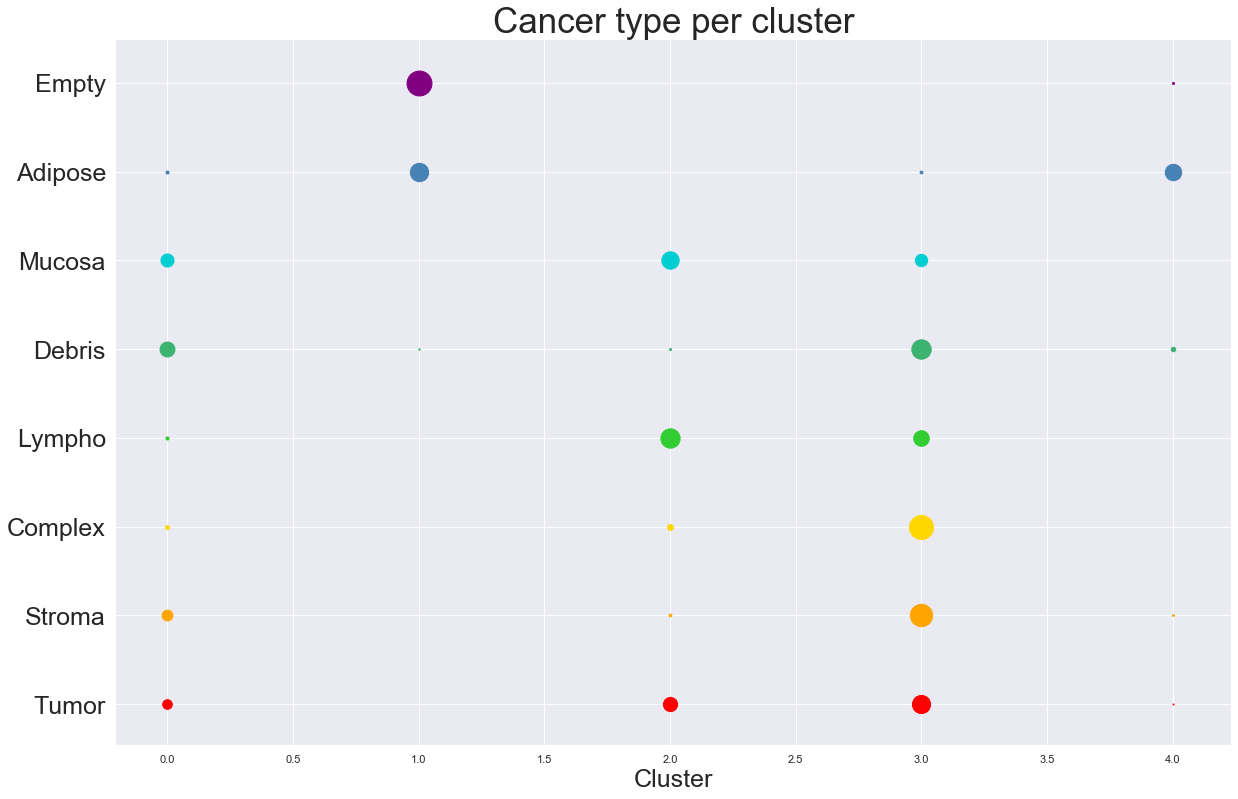

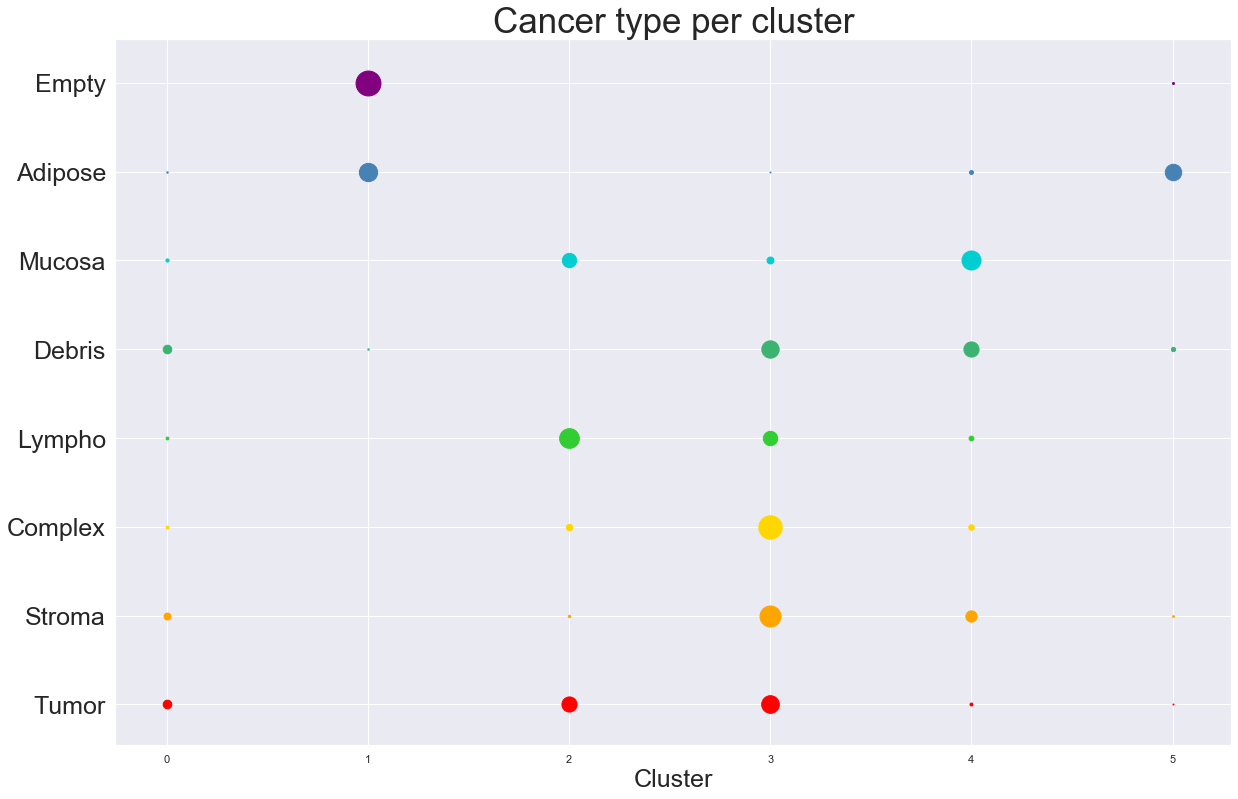

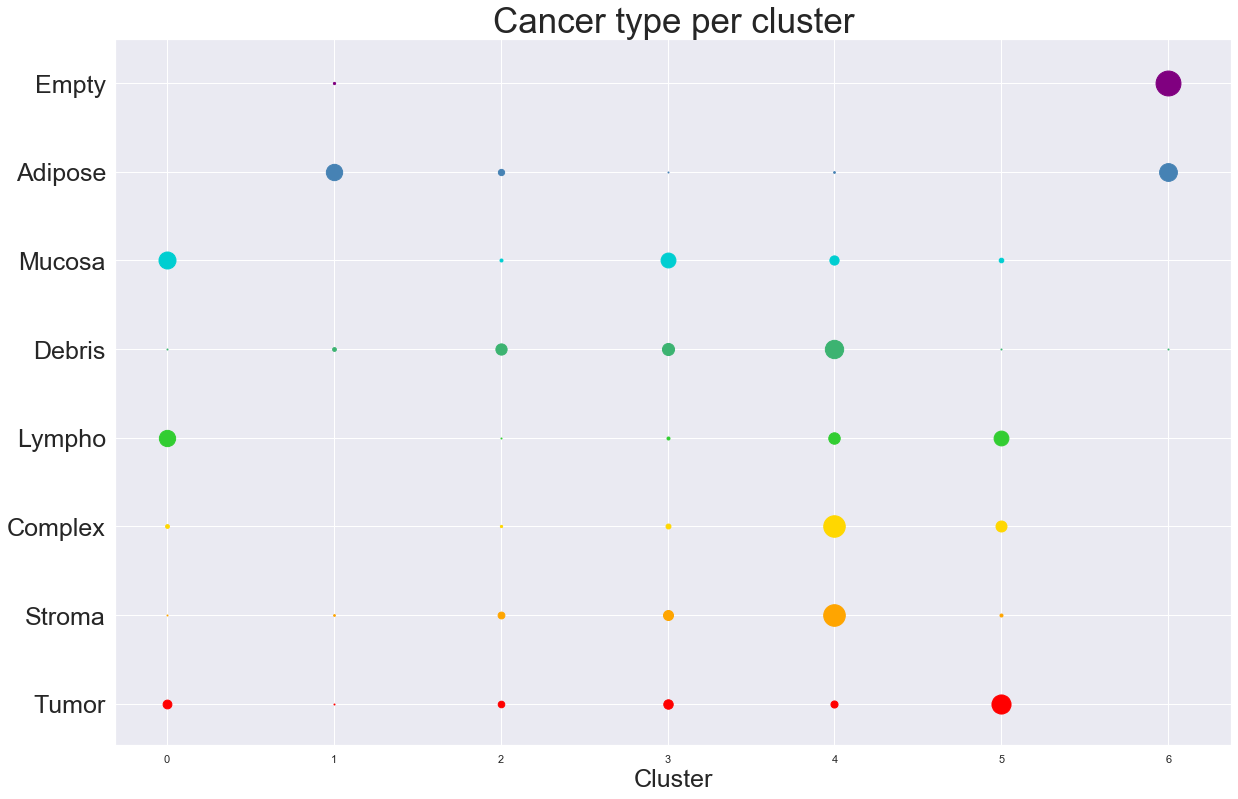

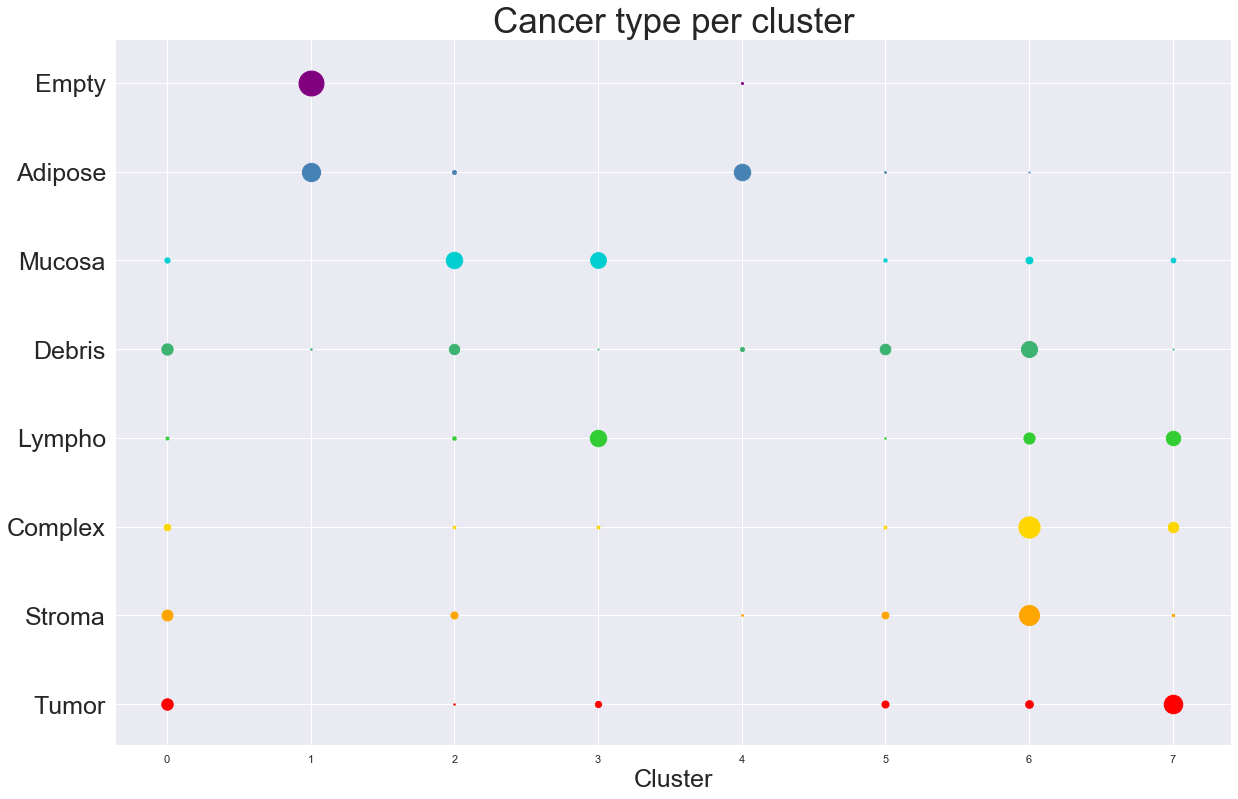

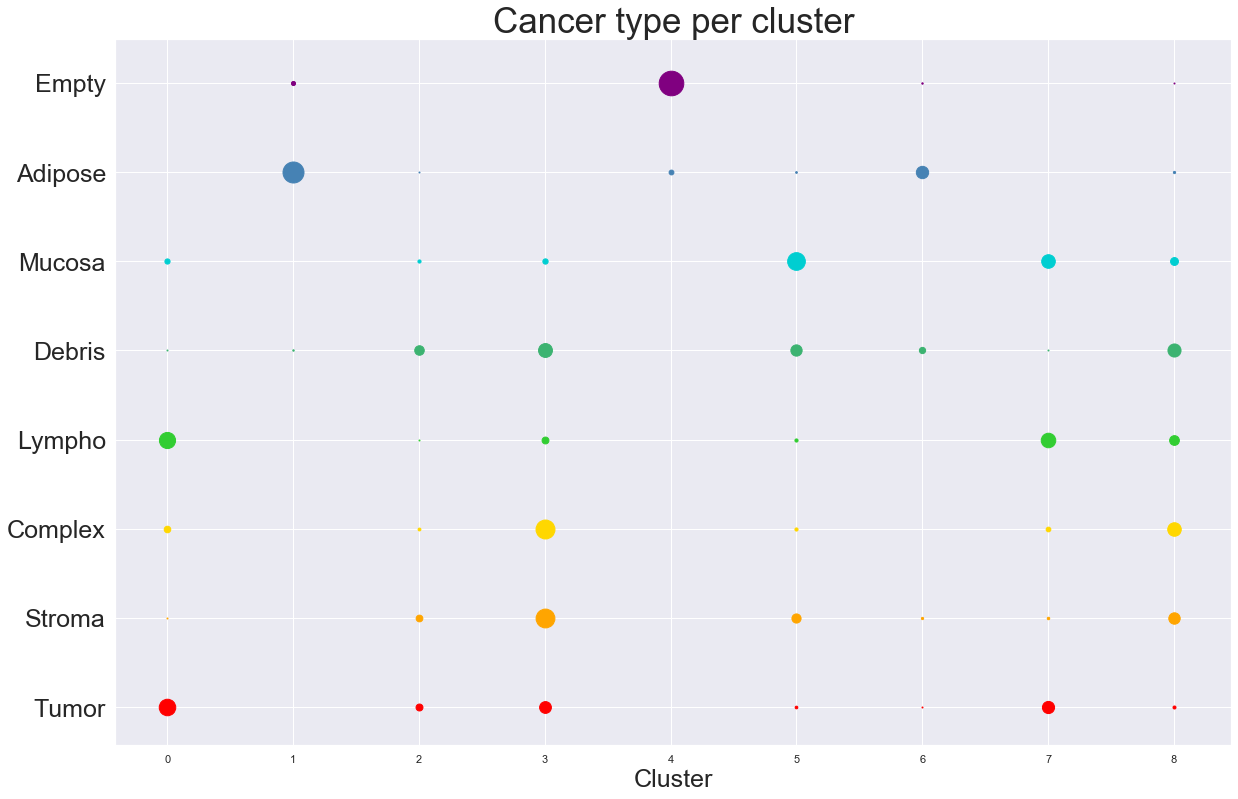

In [41]:
for n in range(2,10):
    model_plotting(image_statistics,n, 'full', GaussianMixture)

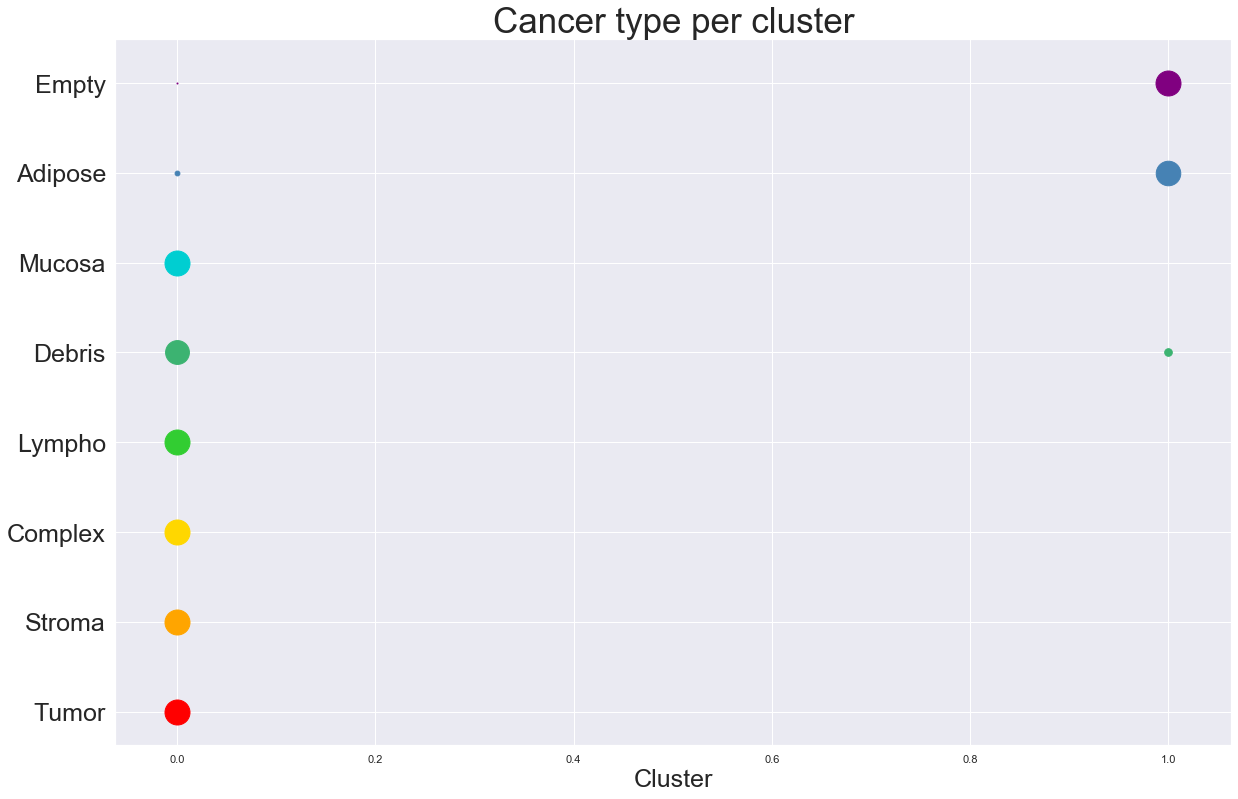

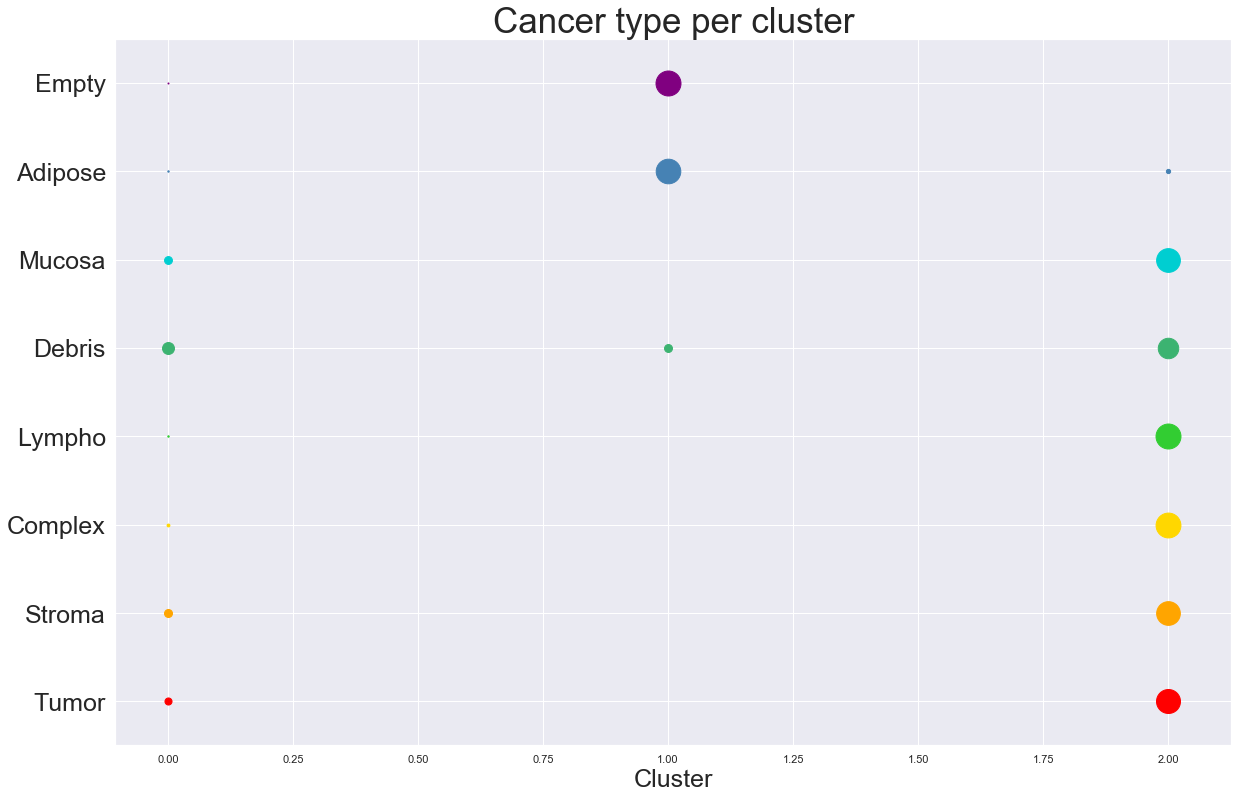

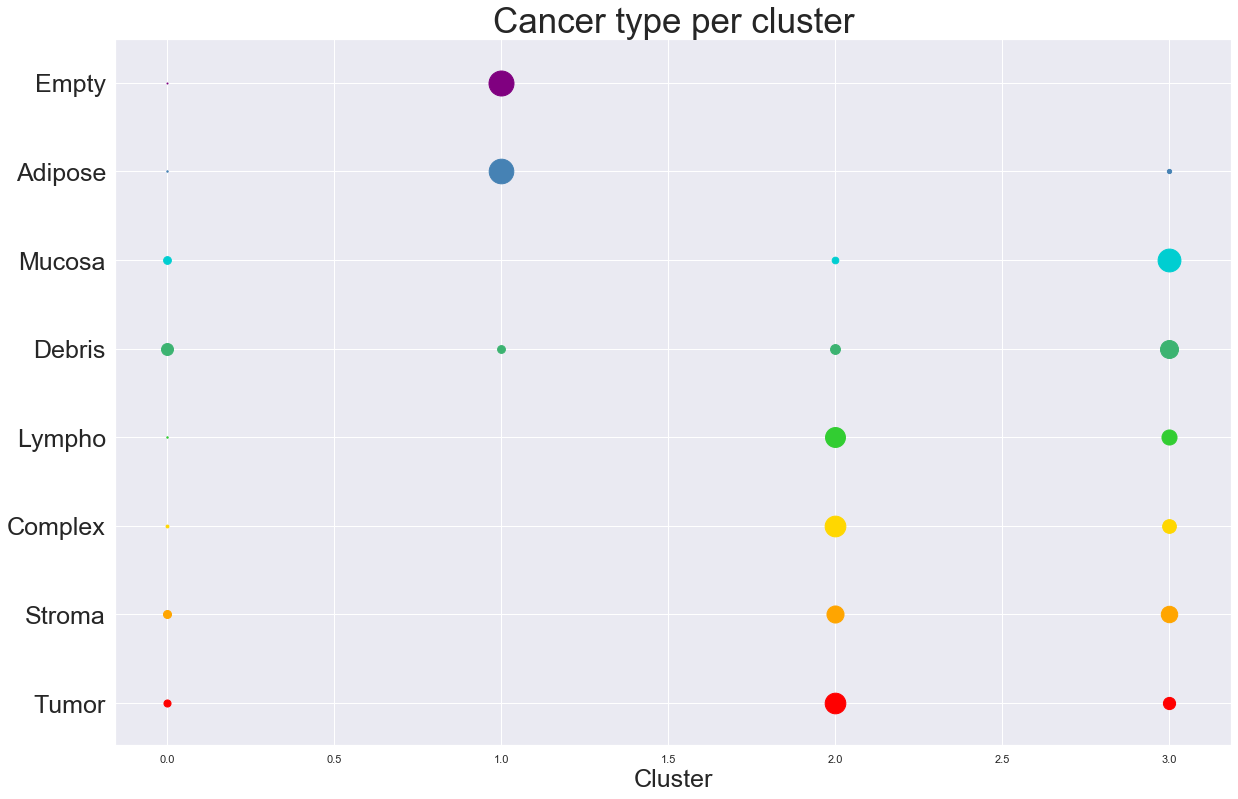

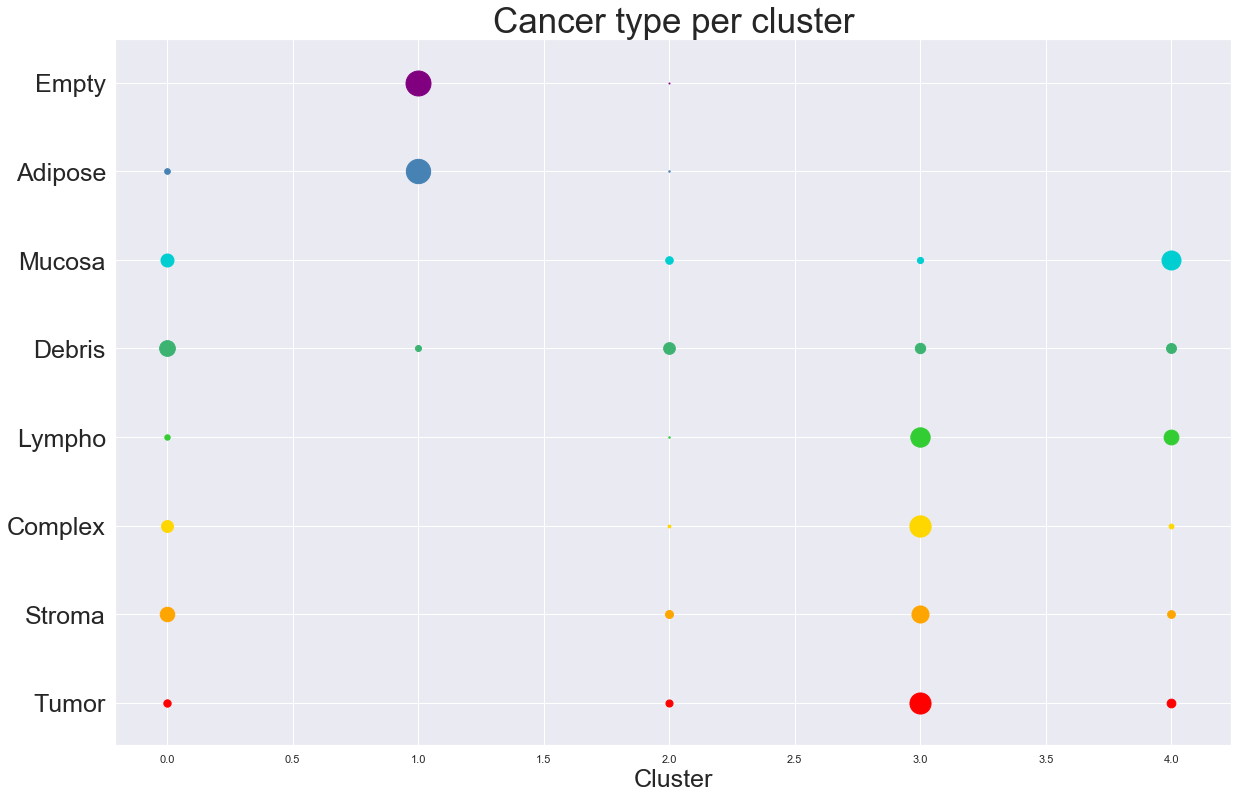

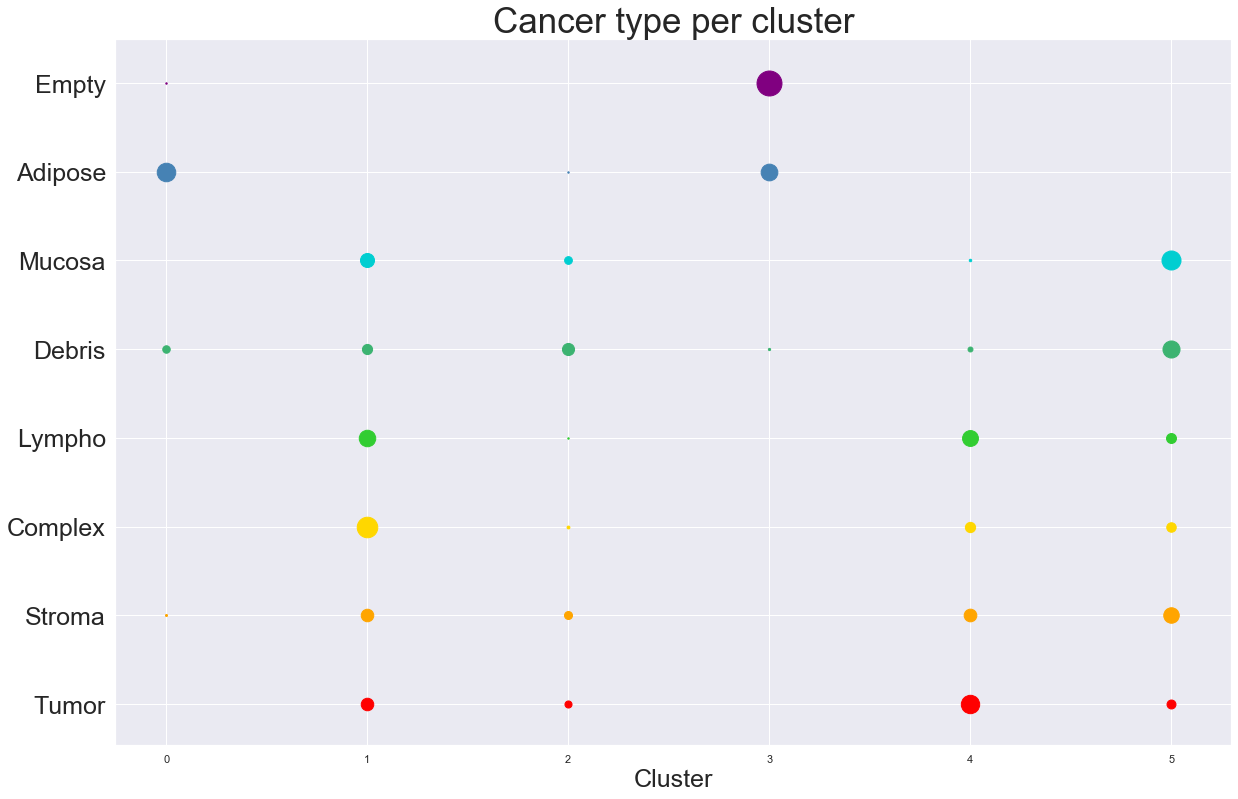

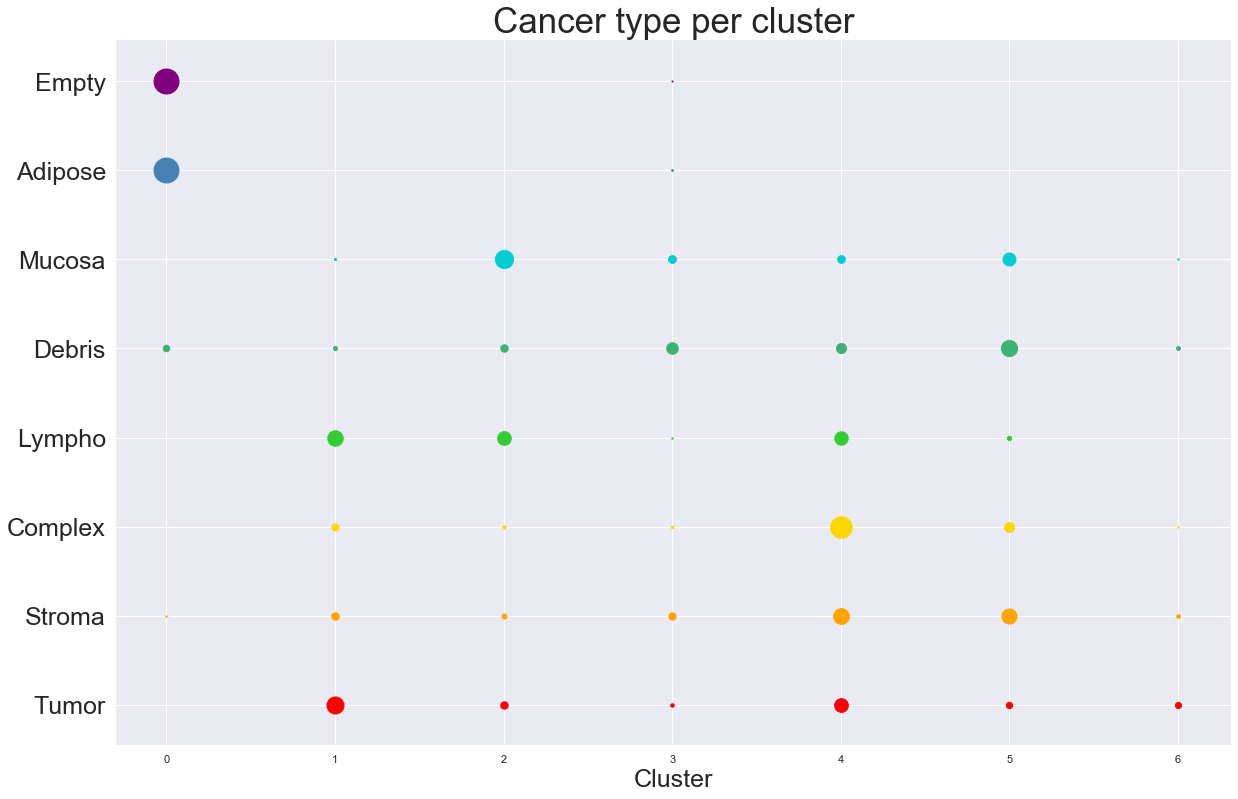

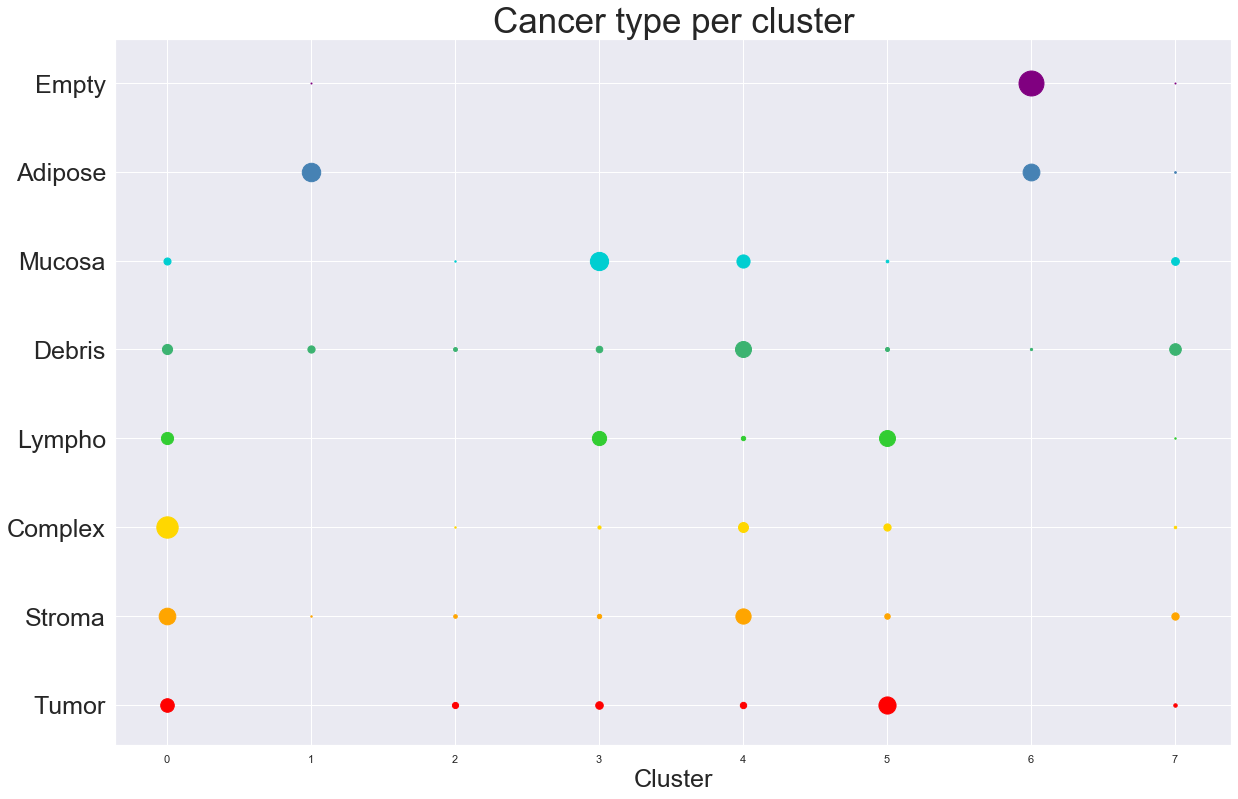

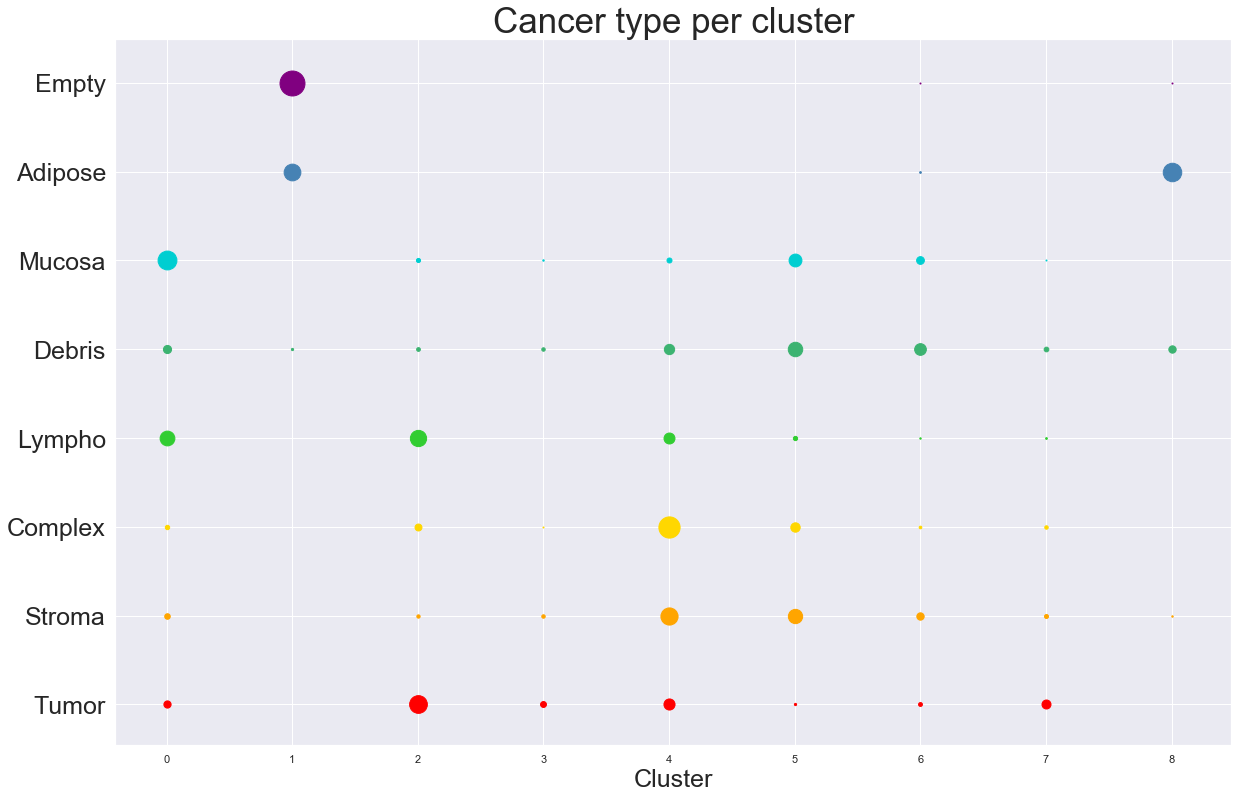

In [42]:
for n in range(2,10):
    model_plotting(image_statistics, n, 'tied', GaussianMixture)

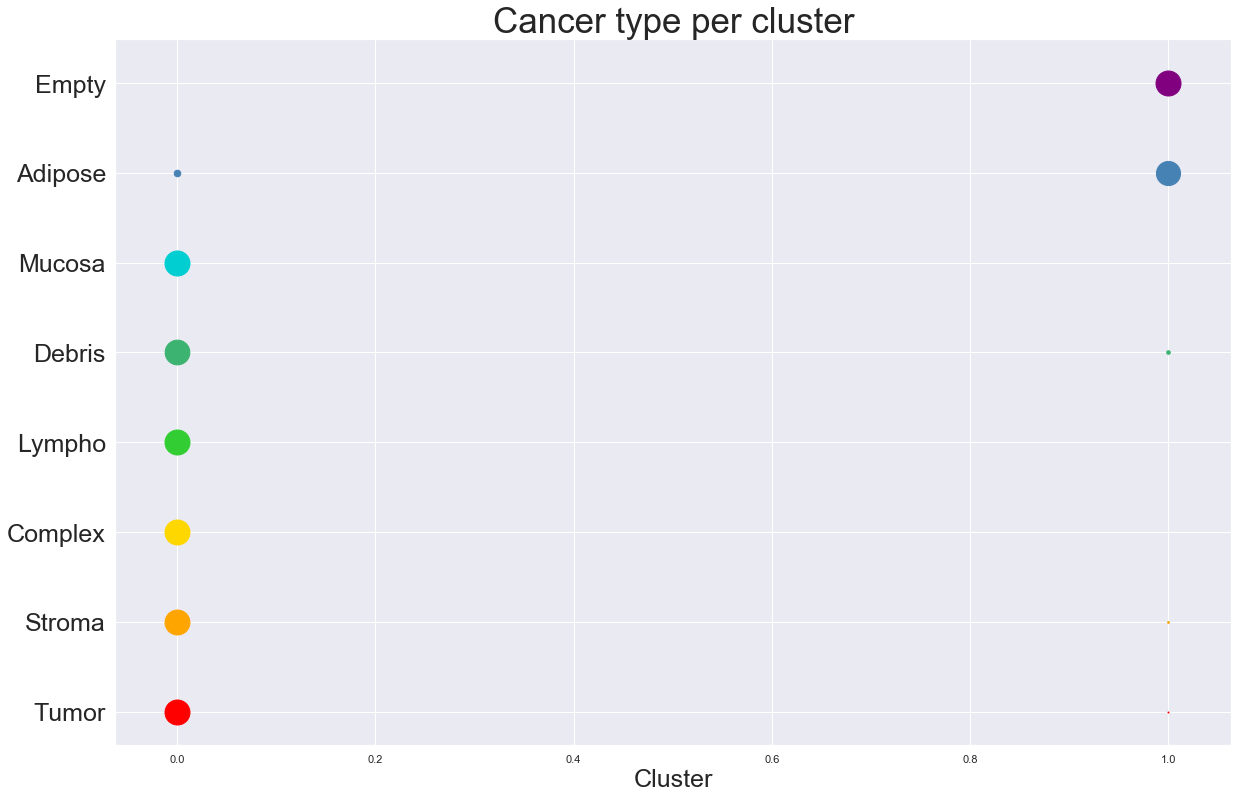

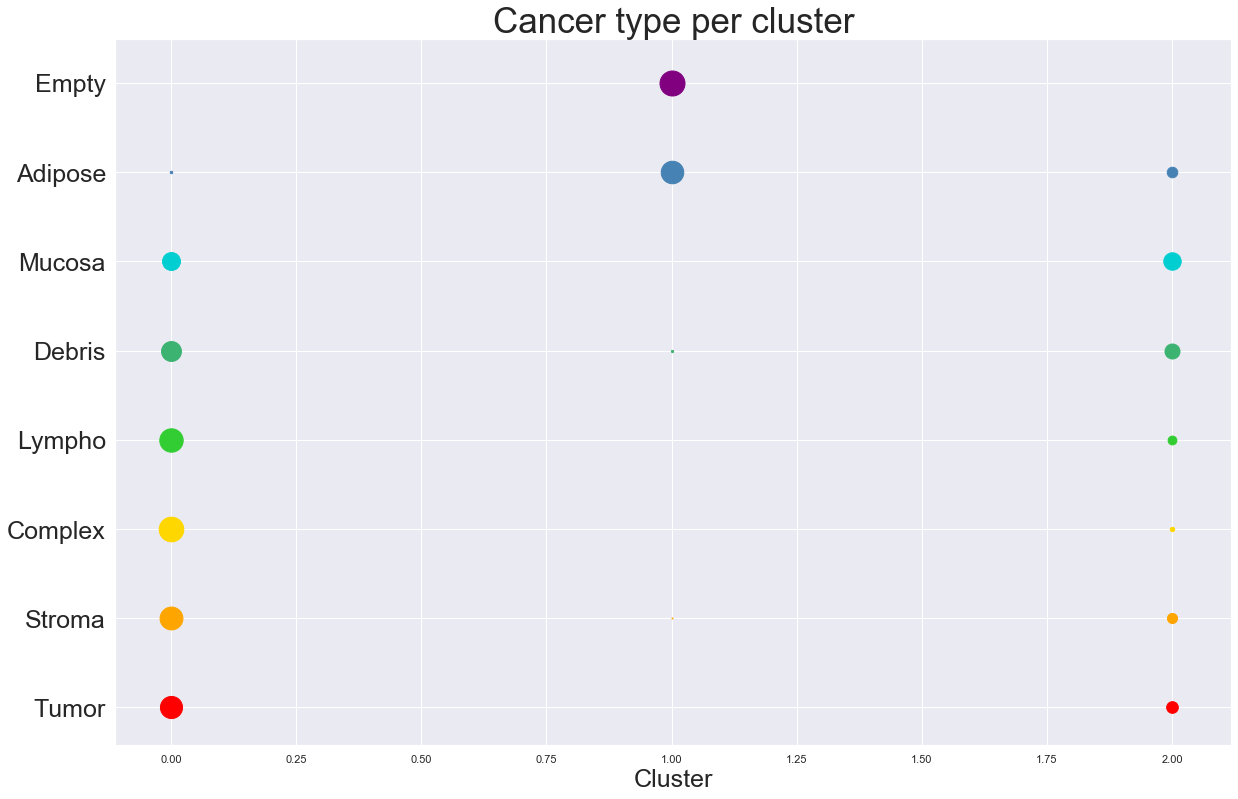

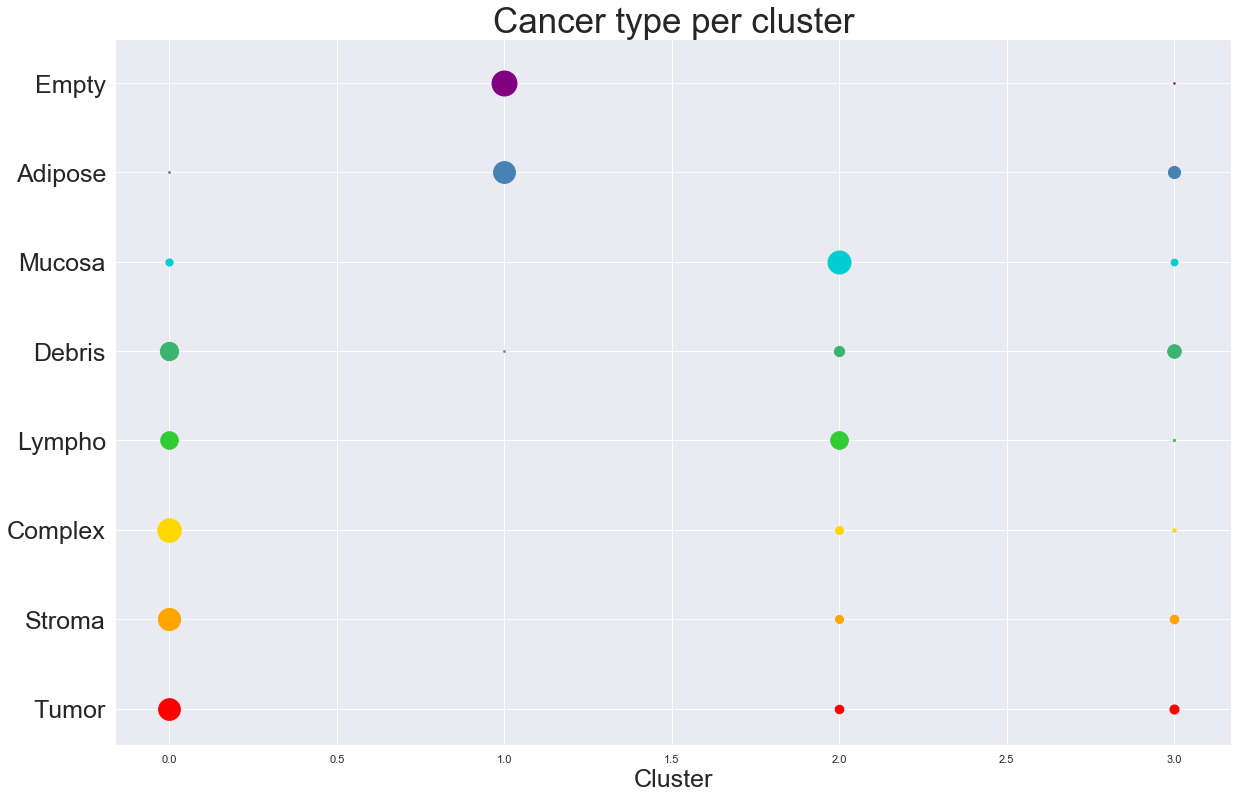

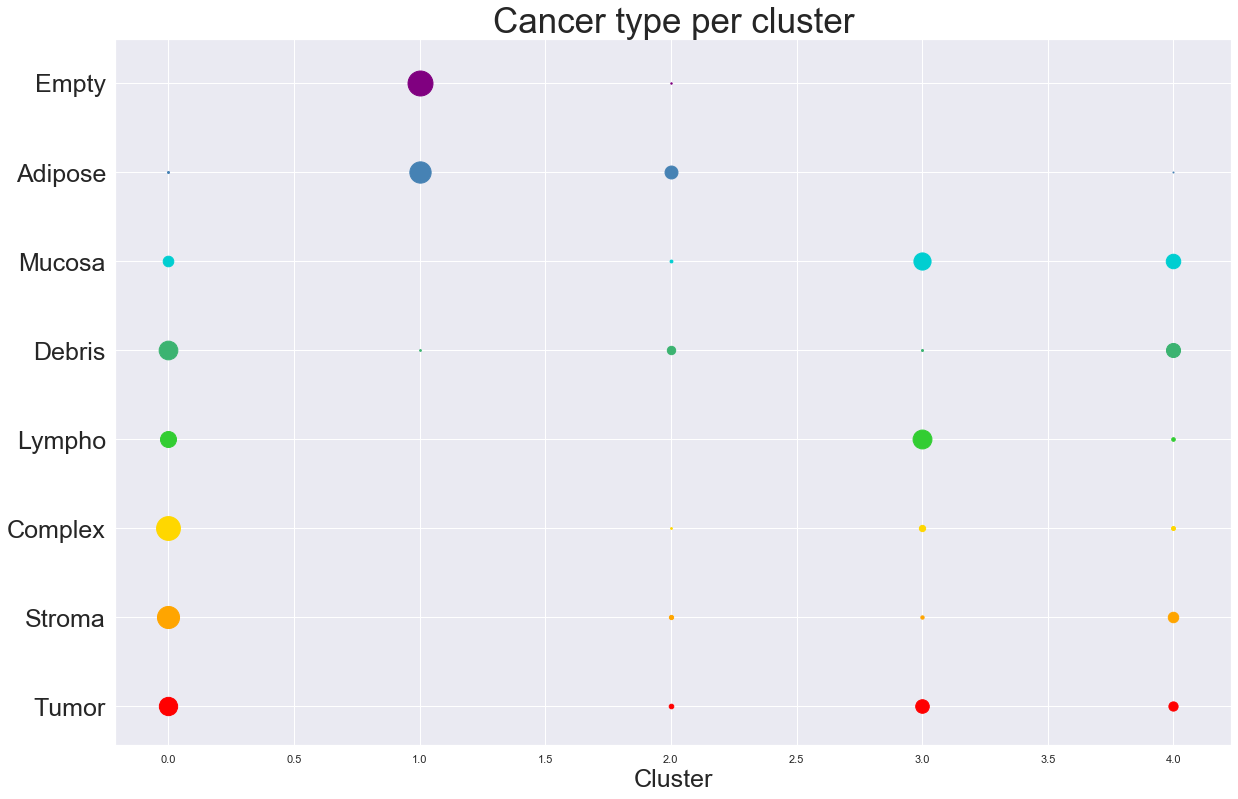

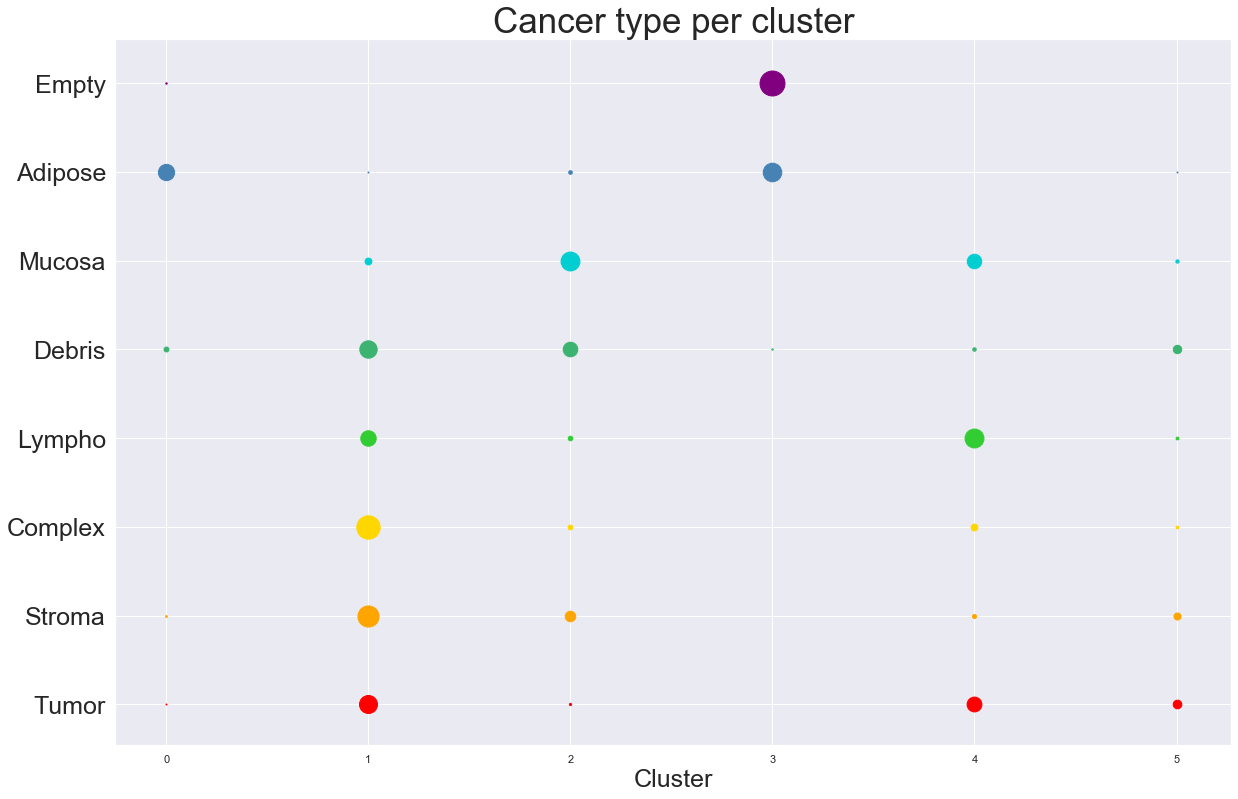

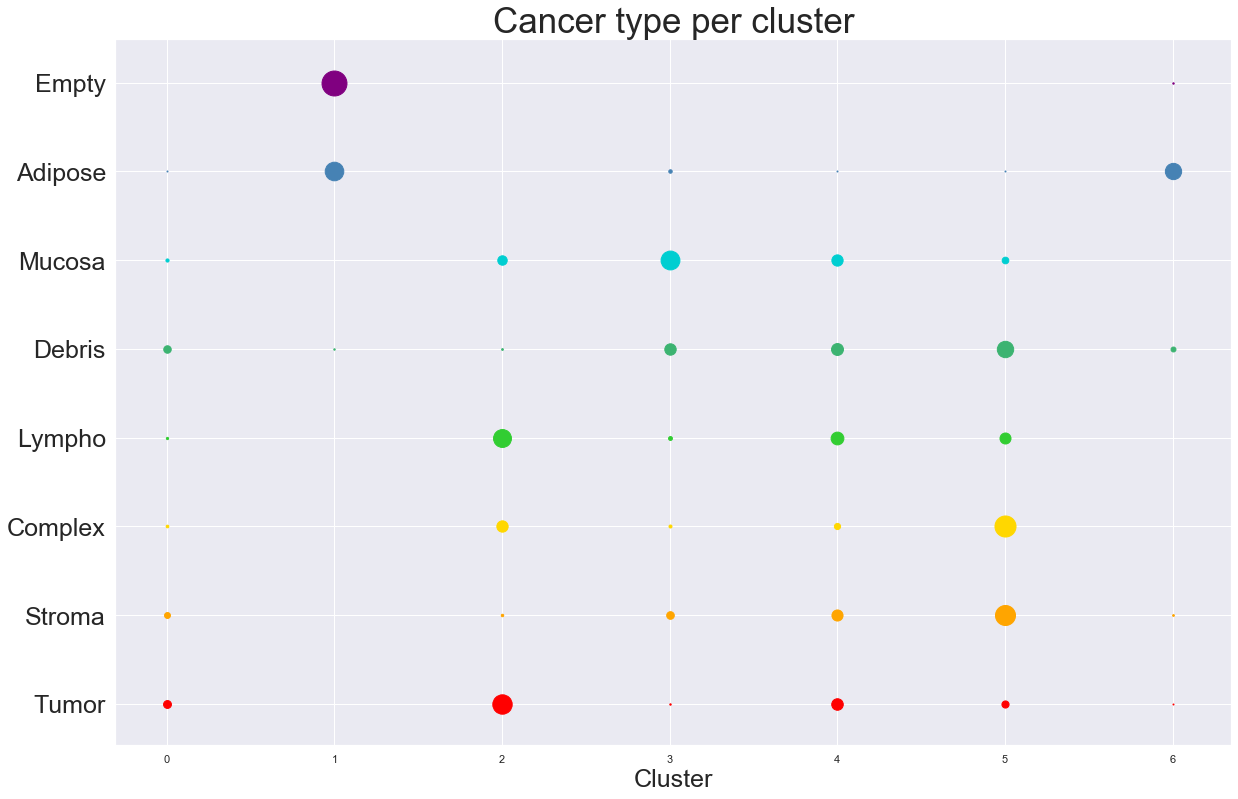

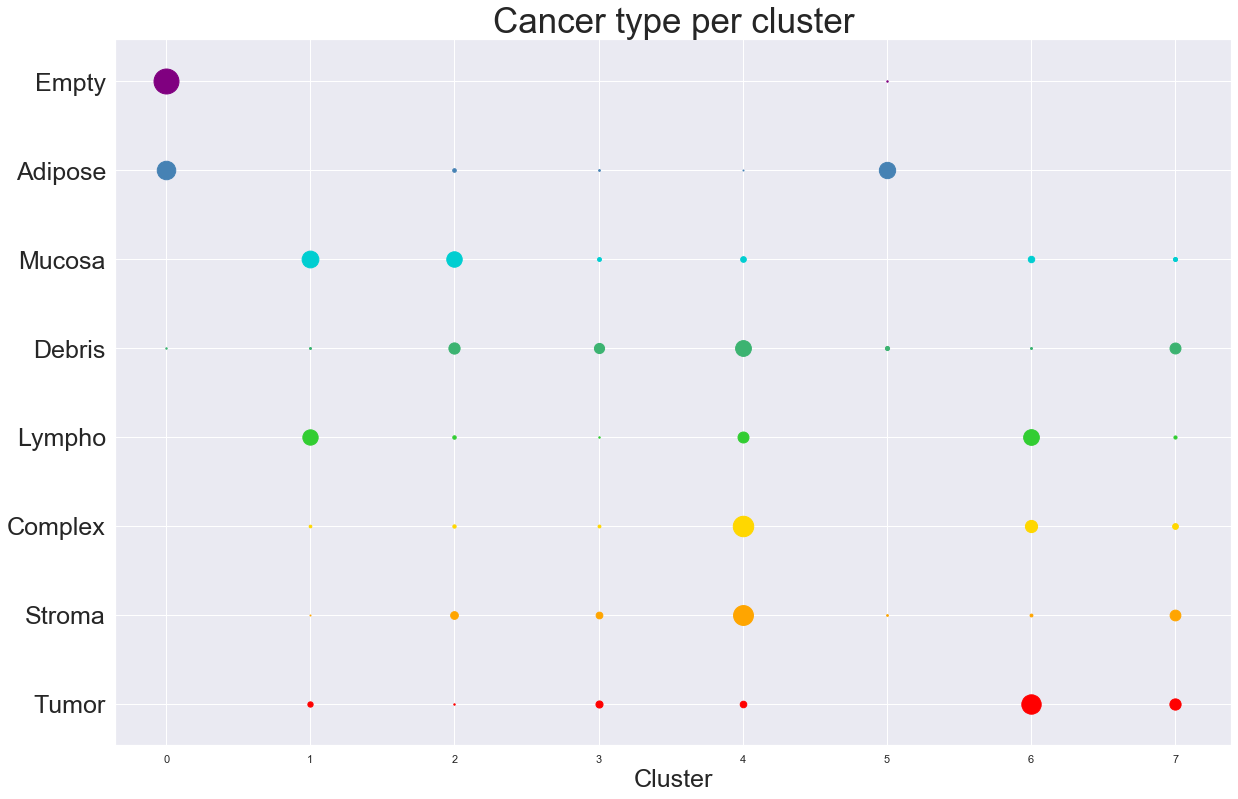

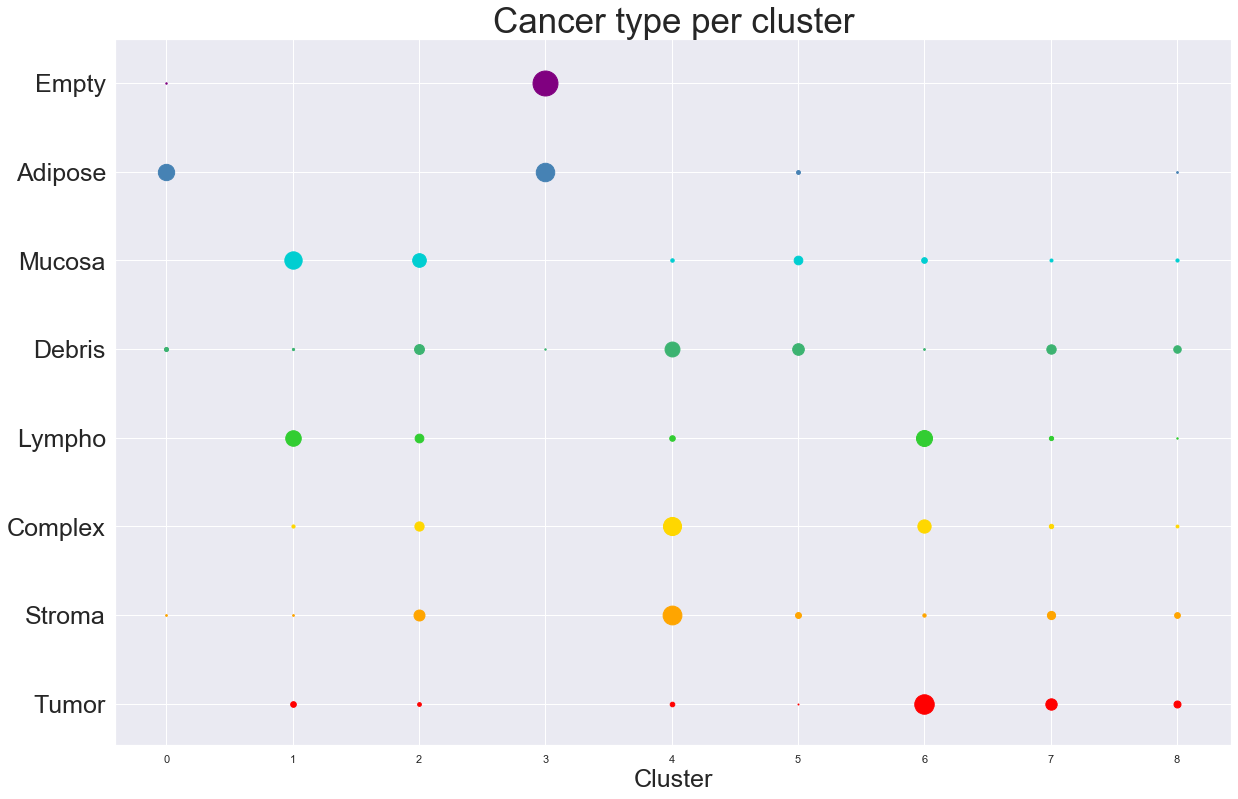

In [43]:
for n in range(2,10):
    model_plotting(image_statistics,n, 'full', BayesianGaussianMixture)

This is nice. We have now made Gaussian Mixture models for different numbers of clusters to be identified and for the covariance to be 'full' - each component has its own general covariance matrix and 'tied' all components share the same general covariance matrix. 

Here's what we observe - 
* In terms of the difference between 'full' and 'tied', the 'full' version does better at clustering for larger than 4 number of clusters. This indicates that there may be some dependence between the different features. 
* As expected from our peak into the images and image statistics, we would have expected the Adipose and Empty tissues to cluster very differently from the others which happens when no_comp=2. However, as you go higher in the number of clusters, there isn't a very obvious clustering for us to say that each cluster is a type of tissue. 
* The Bayesian Gaussian Mixture doesn't do any better.

We can now see what happens if we make a neural network model on this data.

I want to attempt this. I don't know if I'll obtain anything reasonable out of this, but trying doesn't hurt. It seems to me, by looking at the images that there are some cells that have a particular repeating pattern - like a bunch of circular features together, or a bunch of lines arranged parallely. I wonder if I will get anything meaningful out of a Fourier transform of these pixels. The Fourier Transform of an image picks out the smoothness and the edginess of the image. Maybe I can analyze the quantile of intensity of the Fourier transform instead of the features themselves. Or maybe K-Means?

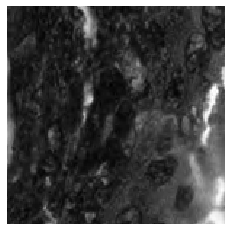

In [90]:
import scipy.fftpack as fp
import imageio
from skimage import color
from skimage import io
import cv2 as cv
sample_image_loc = 'colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/1A11_CRC-Prim-HE-07_022.tif_Row_601_Col_151.tif'
pic=imageio.imread(sample_image_loc)
graypic=color.rgb2gray(io.imread(sample_image_loc))
plt.figure()
plt.imshow(graypic,cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [91]:
graypic.shape

(150, 150)

What is a Sobel x filter?

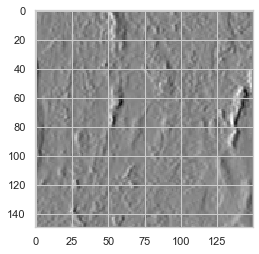

In [92]:
sobelx=cv.Sobel(graypic,cv.CV_64F,1,0,ksize=1)
plt.imshow(sobelx,cmap='gray')

What is a Discrete Fourier Transform and what is Fast Fourier Transform? What does the shift do?

Try using the phase instead of the amplitude

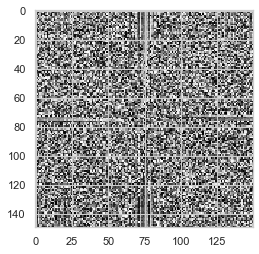

In [93]:
f=np.fft.fft2(graypic)
fshift = np.fft.fftshift(f)
phase_spectrum=np.arctan(fshift.imag/fshift.real)
magnitude_spectrum = np.log(np.abs(fshift))
#plt.imshow(magnitude_spectrum,cmap='gray')
plt.imshow(phase_spectrum,cmap='gray')

In [97]:
print(phase_spectrum.shape)
print(fshift.shape)

(150, 150)
(150, 150)


Obviously, my eyes can't decipher anything from these sample images. 
* The Sobel filter helps in terms of visuals - the naked eye can see the features but then I just realized that the filter is a function operated on the existing samples and this will not in any way affect the quantile data - in fact it will remove features that are important.
* The Fast Fourier Transform on the other hand is different - the naked eye can't observe anything. Let's see if the intensity statistics can see any pattern.


In [129]:
temp = imagefeatures.iloc[185].to_numpy().reshape((64,64)).astype(float)

In [164]:
temp[1][1]

155.0

In [165]:
temp2=np.fft.fft2(temp)

In [166]:
shift = np.fft.fftshift(temp2)

In [ ]:
np.

In [139]:
imagefeatures.iloc[1].shape

(4096,)

In [133]:
np.log(np.abs(shift)).flatten().shape

(4096,)

In [167]:
imagefeatures=images[features]
imagelabels=images['label']

def fourier_transf_phase_df(df,df_copy):
    for i in range(5000):     
        temp = df.iloc[i].to_numpy().reshape((64,64)).astype(float) 
        temp2 = np.fft.fft2(temp)
        shift = np.fft.fftshift(temp2)
        df_copy.iloc[i] = np.arctan(shift.imag/shift.real).flatten()
    return df_copy    

def fourier_transf_abs_df(df,df_copy):
    for i in range(5000):     
        temp = df.iloc[i].to_numpy().reshape((64,64)).astype(float)  
        temp2 = np.fft.fft2(temp)
        shift = np.fft.fftshift(temp2)
        df_copy.iloc[i] = np.log(np.abs(shift)).flatten()
    return df_copy    

In [168]:
ft_phase_images_copy=imagefeatures.copy()
ft_phase_images=fourier_transf_phase_df(imagefeatures,ft_phase_images_copy)
ft_phase_images['label'] = imagelabels

/home/arunravishankar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/arunravishankar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [169]:
ft_abs_images_copy=imagefeatures.copy()
ft_abs_images=fourier_transf_abs_df(imagefeatures,ft_abs_images_copy)
ft_abs_images['label'] = imagelabels

/home/arunravishankar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [170]:
overall_statistics_ft_phase=pd.DataFrame(index = np.arange(1,9), columns=stats_quantities)
for class_idx in range(1,9):
    overall_statistics_ft_phase.loc[class_idx,:] = get_overall_statistics(ft_phase_images, class_idx)

overall_statistics_ft_phase = overall_statistics_ft_phase.reset_index()
overall_statistics_ft_phase["index"] = overall_statistics_ft_phase["index"].apply(lambda l : class_names[l])
overall_statistics_ft_phase = overall_statistics_ft_phase.set_index("index")
overall_statistics_ft_phase.index.name = None


overall_statistics_ft_abs=pd.DataFrame(index = np.arange(1,9), columns=stats_quantities)
for class_idx in range(1,9):
    overall_statistics_ft_abs.loc[class_idx,:] = get_overall_statistics(ft_abs_images, class_idx)

overall_statistics_ft_abs = overall_statistics_ft_abs.reset_index()
overall_statistics_ft_abs["index"] = overall_statistics_ft_abs["index"].apply(lambda l : class_names[l])
overall_statistics_ft_abs = overall_statistics_ft_abs.set_index("index")
overall_statistics_ft_abs.index.name = None

/home/arunravishankar/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [171]:
image_statistics_ft_phase = pd.DataFrame(index=ft_phase_images.index)
image_statistics_ft_phase["{}".format('Mode')] = ft_phase_images.apply(lambda l: stats.mode(l)[0][0], axis=1)
for q in range(1, 10):
    col_name = "Q" + str(q*10)
    image_statistics_ft_phase[col_name] = ft_phase_images.apply(lambda l: np.quantile(l, (q*10)/100), axis=1)

image_statistics_ft_phase["label"] = ft_phase_images.label.values
image_statistics_ft_phase.head()

Mode       Q10       Q20       Q30       Q40  Q50       Q60       Q70  \
0   0.0 -1.259028 -0.959726 -0.641638 -0.312011  0.0  0.312761  0.642390   
1   0.0 -1.260292 -0.911712 -0.602027 -0.288899  0.0  0.289883  0.602694   
2   0.0 -1.258281 -0.946879 -0.624319 -0.311653  0.0  0.312253  0.625312   
3   0.0 -1.243835 -0.933063 -0.614539 -0.290616  0.0  0.290921  0.615353   
4   0.0 -1.238238 -0.926386 -0.632515 -0.318142  0.0  0.318669  0.632905   

        Q80       Q90  label  
0  0.960680  1.260250      2  
1  0.912074  1.260819      2  
2  0.947244  1.258800      2  
3  0.933679  1.245740      2  
4  0.927894  1.239133      2

This is weird - Why is the mode 0 for all the samples? Is this because of the fact that the mode would've been close to arctan(infty)=pi/2? What about the 50th percentile then? This would be arctan(-infty)=3pi/2

In [172]:
image_statistics_ft_abs = pd.DataFrame(index=ft_abs_images.index)
image_statistics_ft_abs["{}".format('Mode')] = ft_abs_images.apply(lambda l: stats.mode(l)[0][0], axis=1)
for q in range(1, 10):
    col_name = "Q" + str(q*10)
    image_statistics_ft_abs[col_name] = ft_abs_images.apply(lambda l: np.quantile(l, (q*10)/100), axis=1)

image_statistics_ft_abs["label"] = ft_abs_images.label.values
image_statistics_ft_abs.head()

Mode       Q10       Q20       Q30       Q40       Q50       Q60  \
0  2.247835  5.528726  5.953116  6.281798  6.526874  6.786050  7.038486   
1  1.610561  5.097445  5.559441  5.877246  6.157900  6.417830  6.668177   
2  2.481030  5.523806  6.046532  6.349073  6.586953  6.841767  7.082020   
3  2.603924  4.995873  5.408964  5.685762  5.935078  6.174525  6.431407   
4  1.920754  5.463658  5.929819  6.242564  6.517248  6.743471  6.967243   

        Q70       Q80       Q90  label  
0  7.310142  7.618324  8.074896      2  
1  6.970499  7.310972  7.872073      2  
2  7.333147  7.681105  8.275856      2  
3  6.688806  7.064473  7.682904      2  
4  7.218080  7.553341  8.056658      2

ValueError: supplied range of [-inf, 13.274261808536846] is not finite

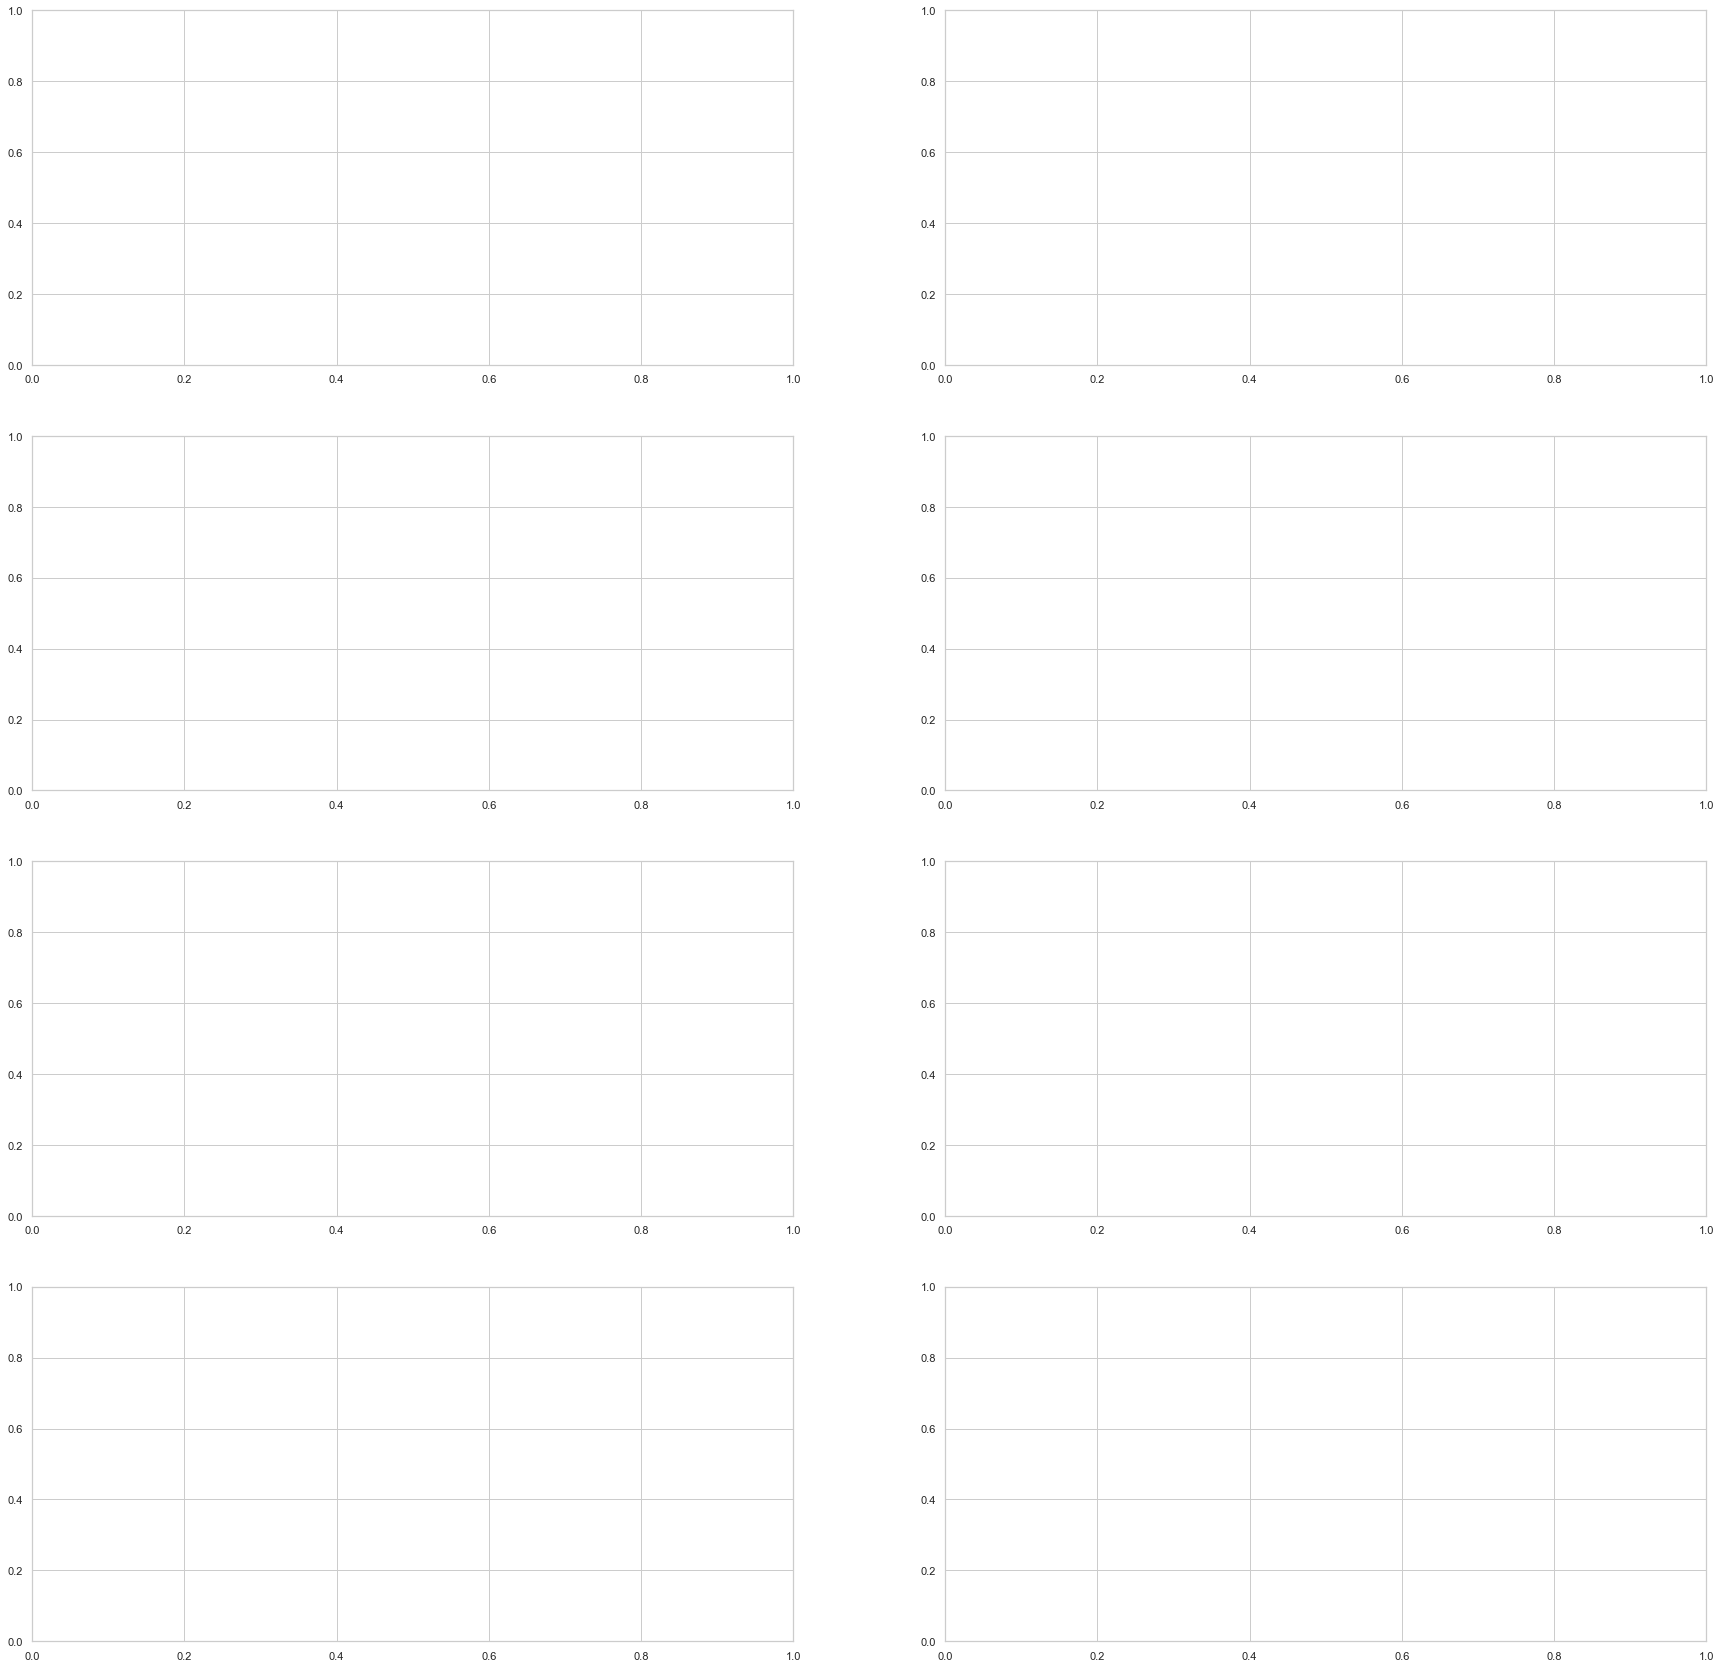

In [173]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(4,2, figsize=(30,30))
for n in range(4):
    for m in range(2):
        class_idx = n*2+(m+1)
        sns.distplot(ft_abs_images[ft_abs_images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx], 
                     norm_hist=True,
                     bins=50)
        sns.distplot(image_statistics_ft_abs[image_statistics_ft_abs.label == class_idx]['Mode'].values,
                     ax=ax[n,m],
                 color="lightskyblue",
                     norm_hist=True, 
                     bins=50)
        ax[n,m].set_title(class_names[class_idx], fontsize = 35)
        ax[n,m].set_xlabel("Fourier Transform Intensity", fontsize = 25)
        ax[n,m].set_ylabel("Density", fontsize = 25)

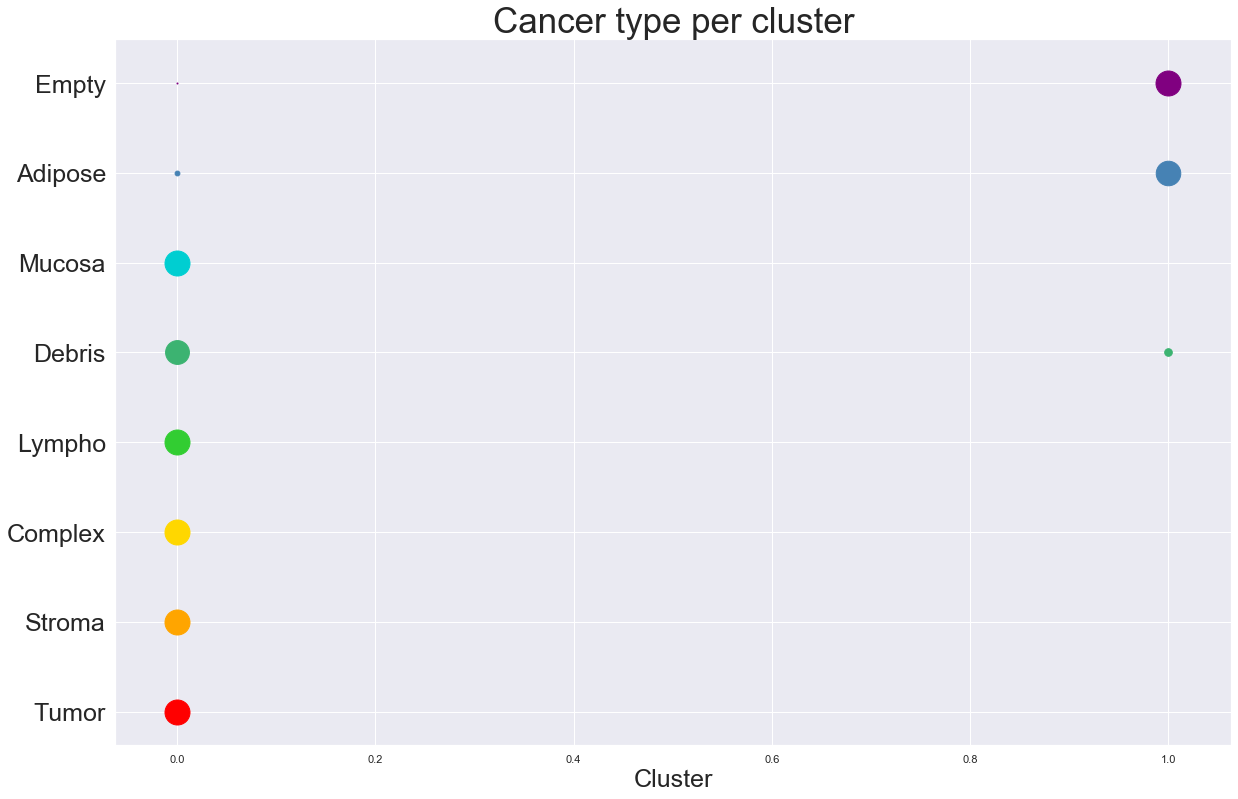

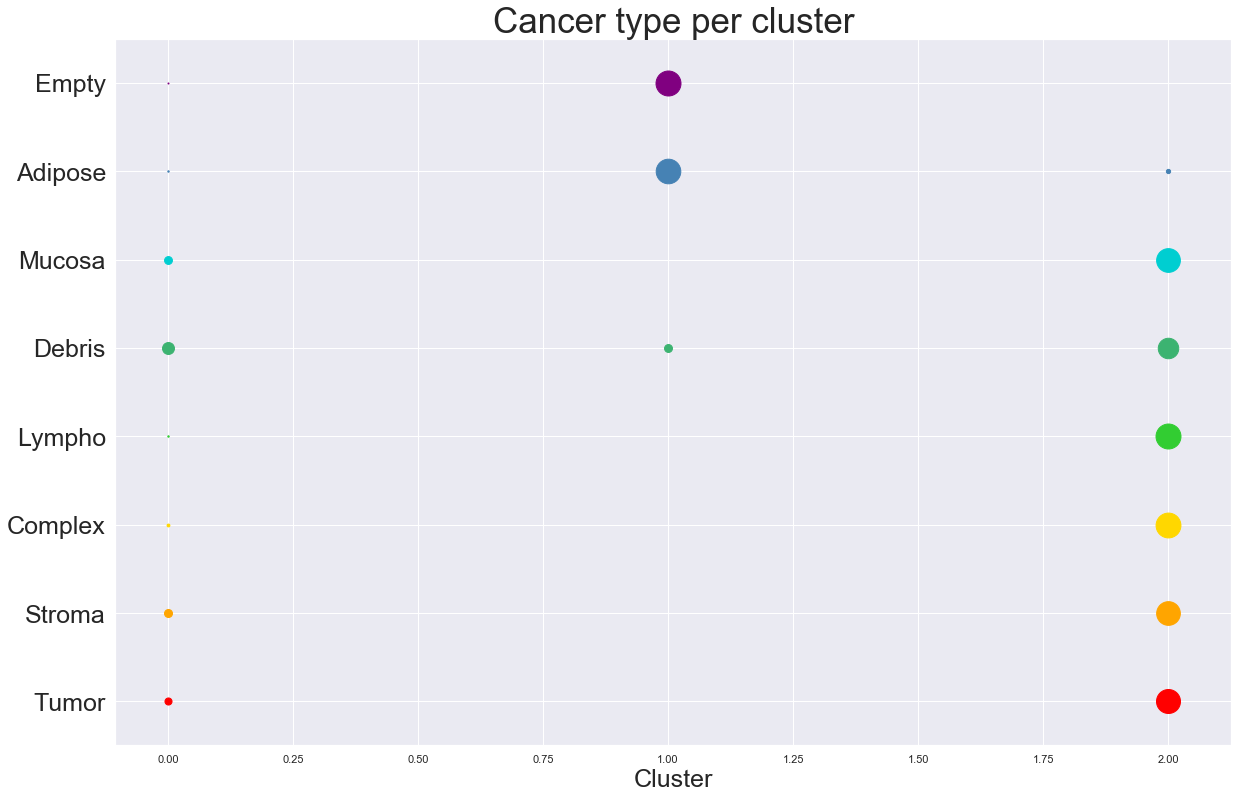

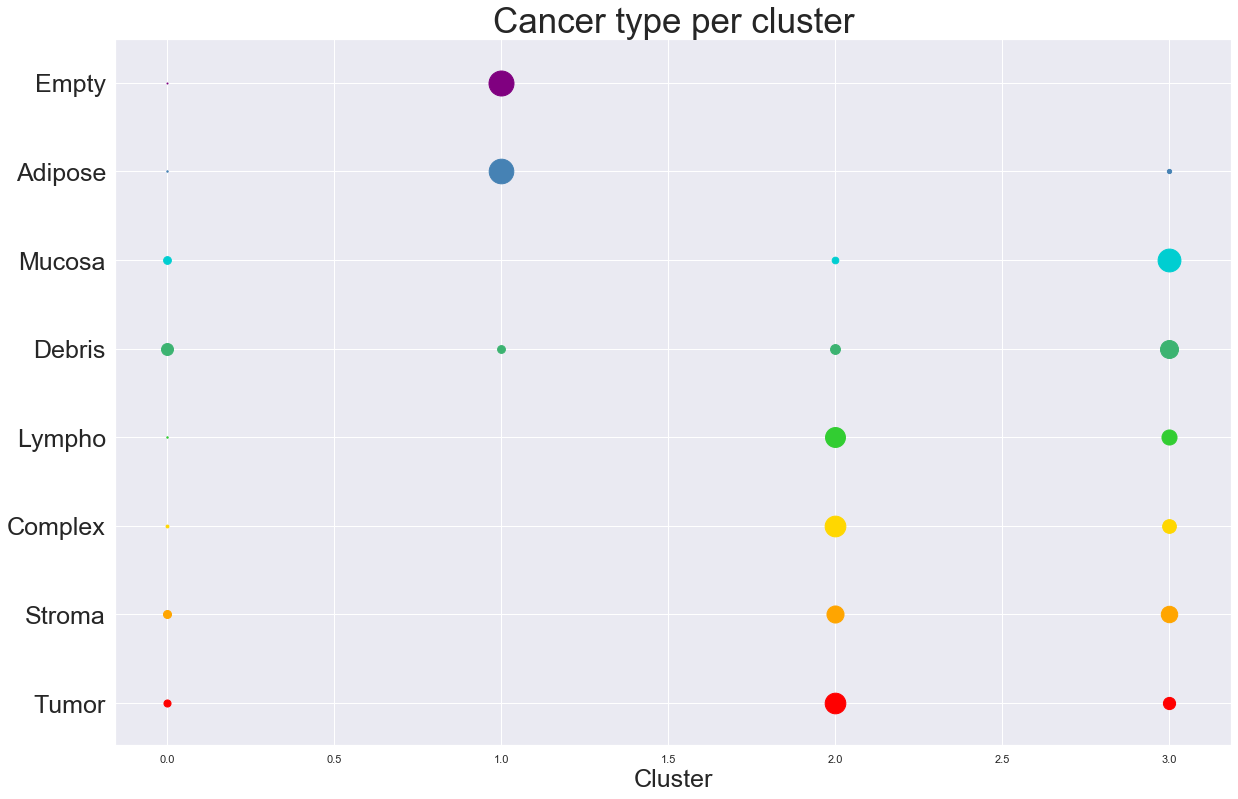

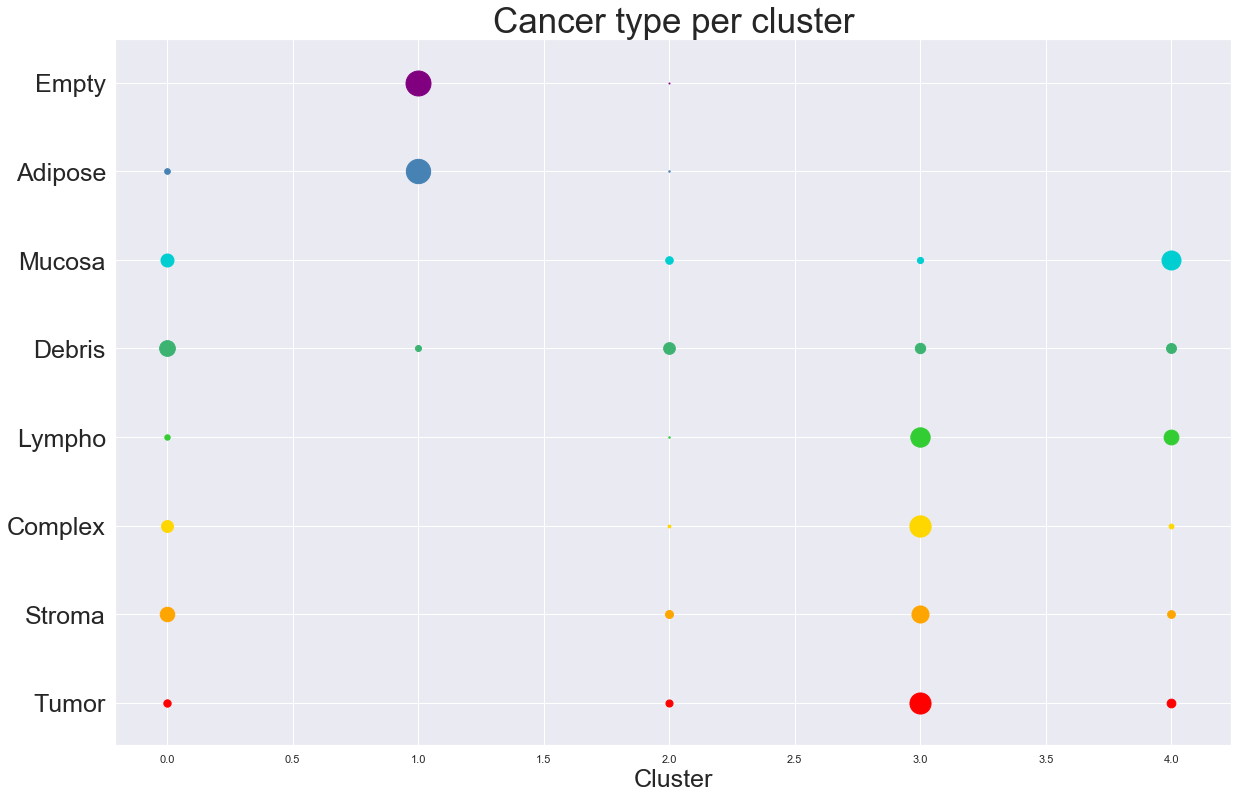

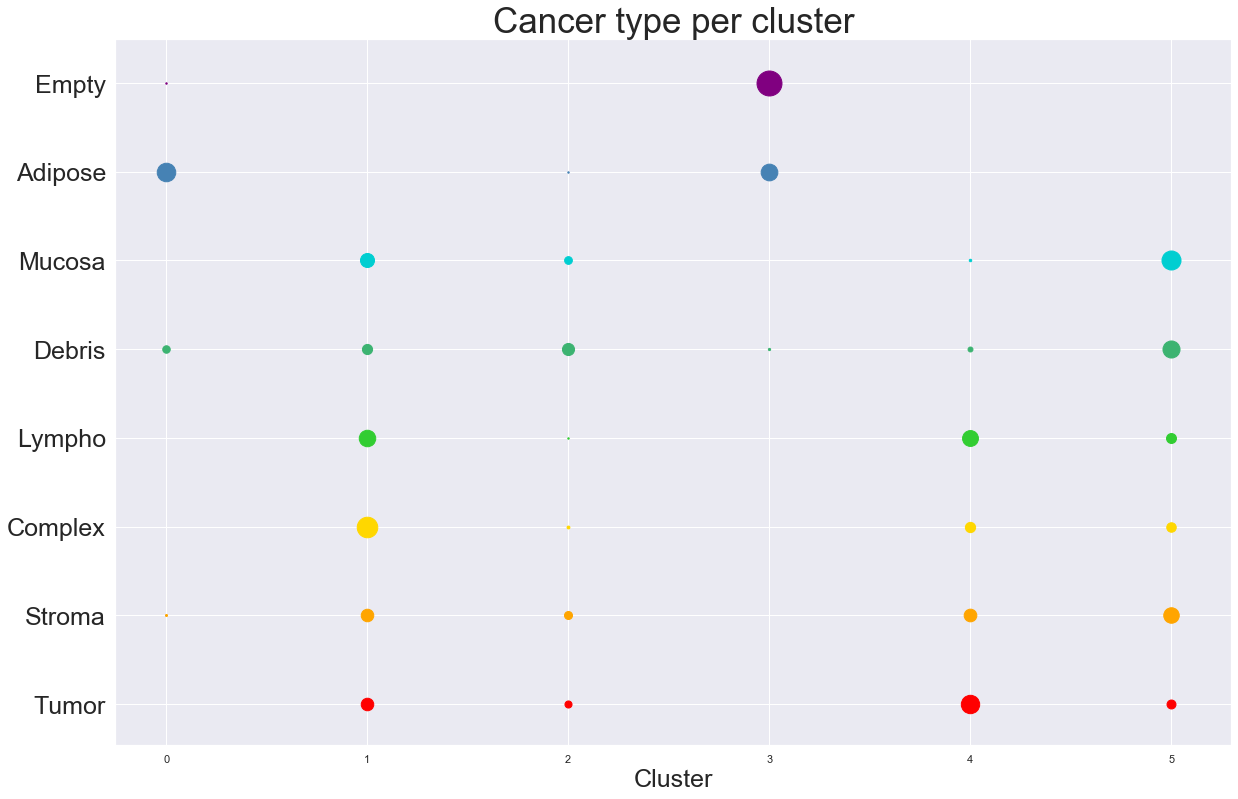

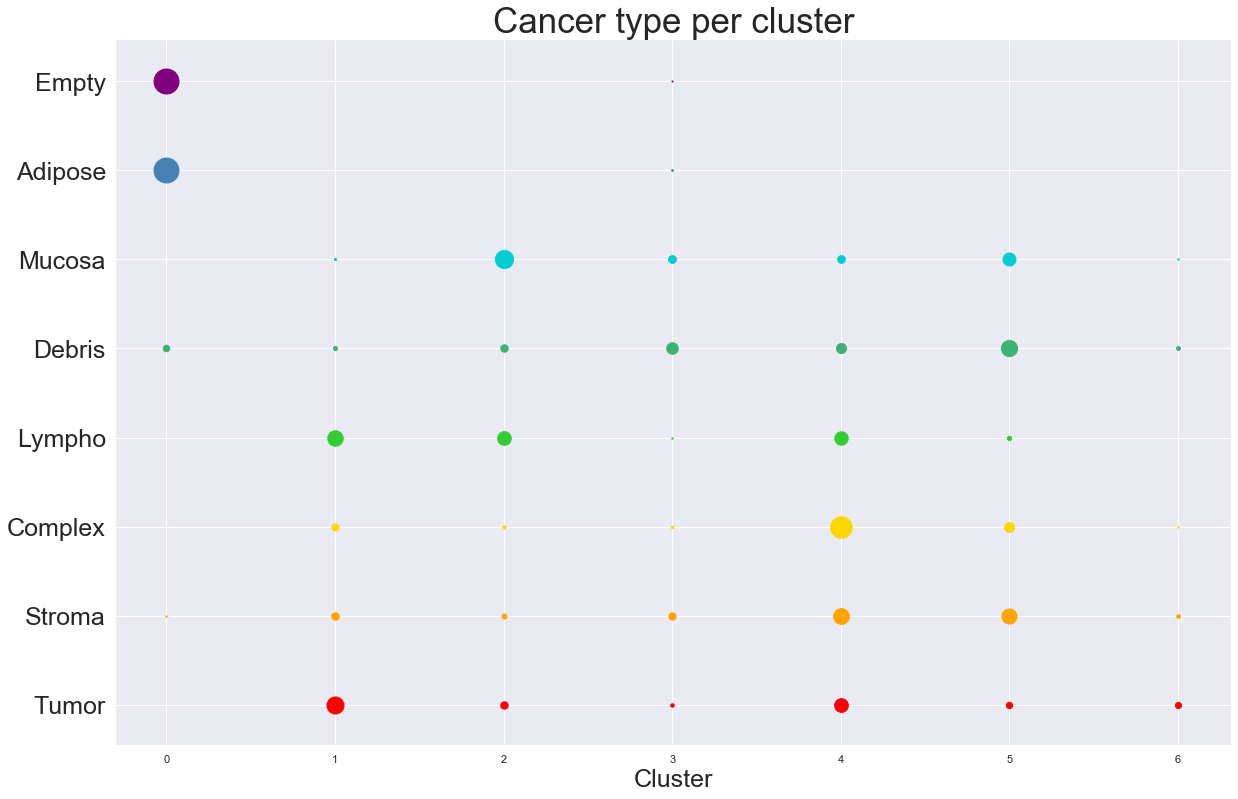

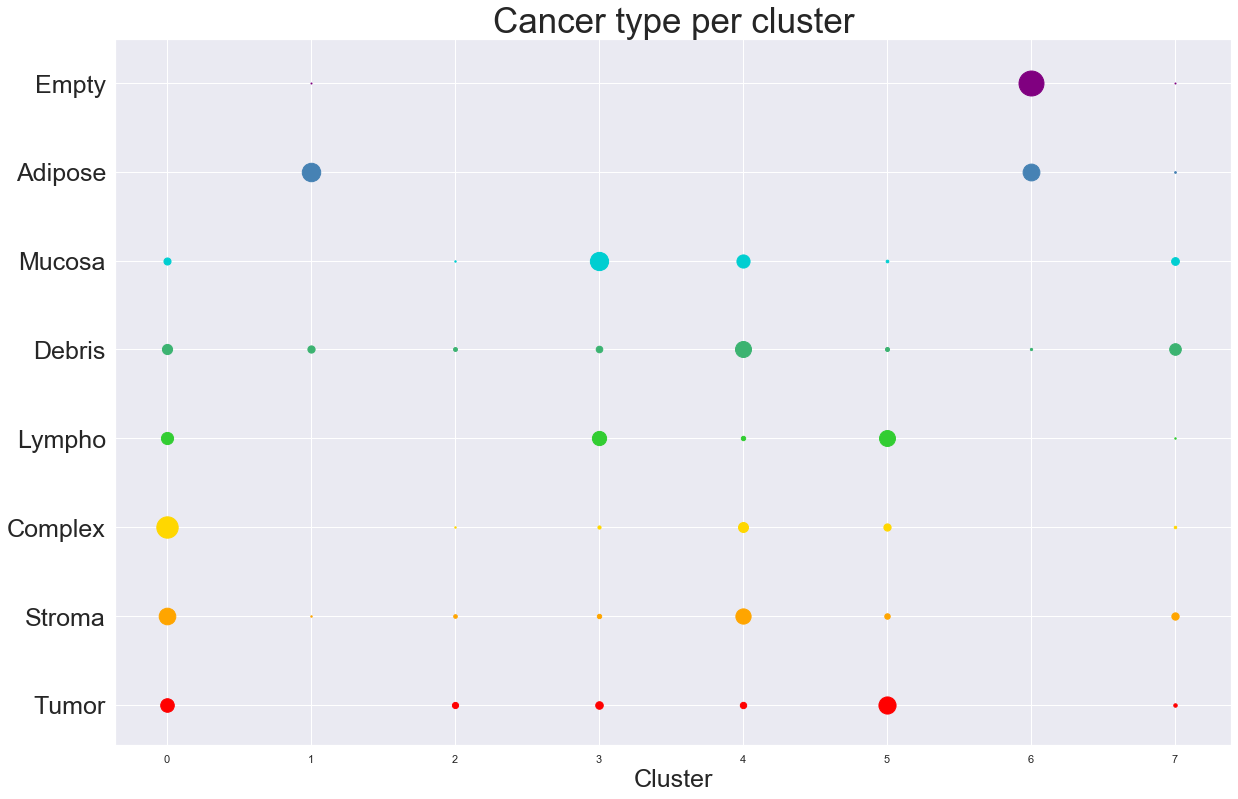

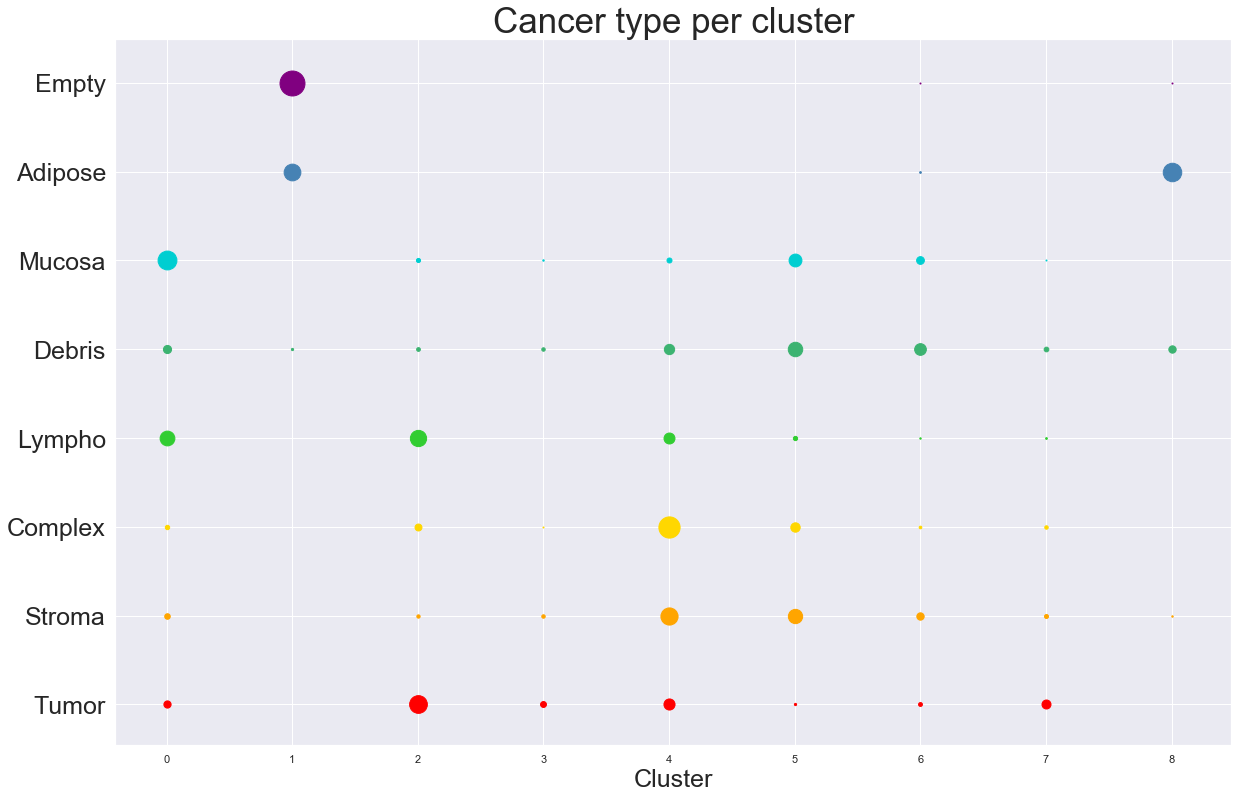

In [174]:
for i in range(2,10):
    model_plotting(image_statistics_ft_abs, i, 'tied', GaussianMixture)

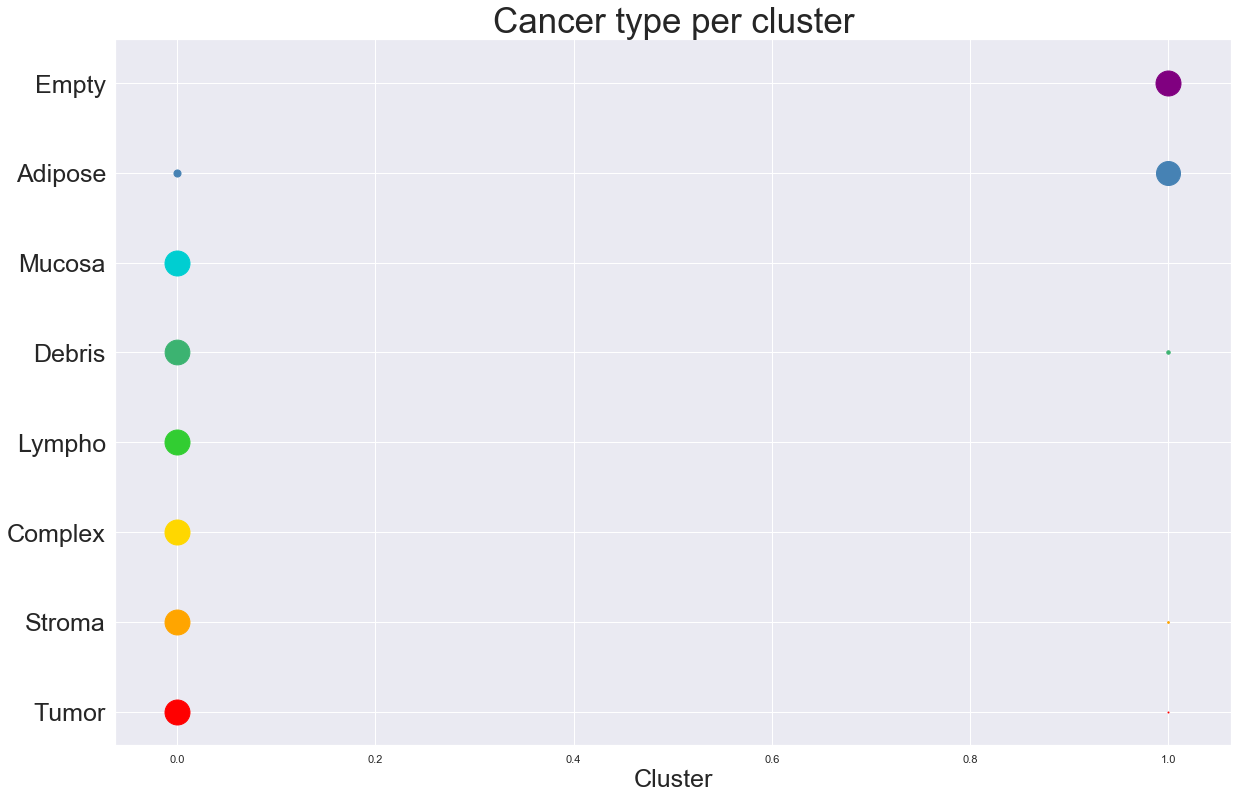

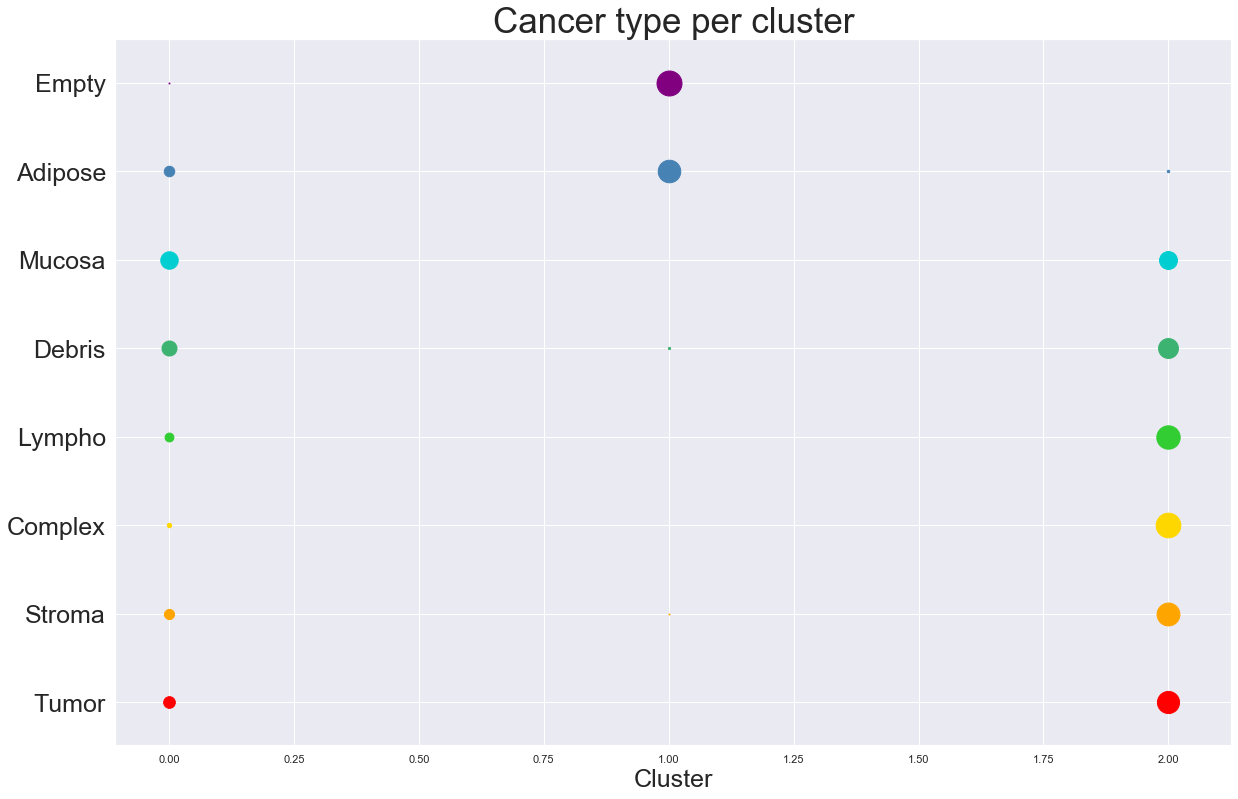

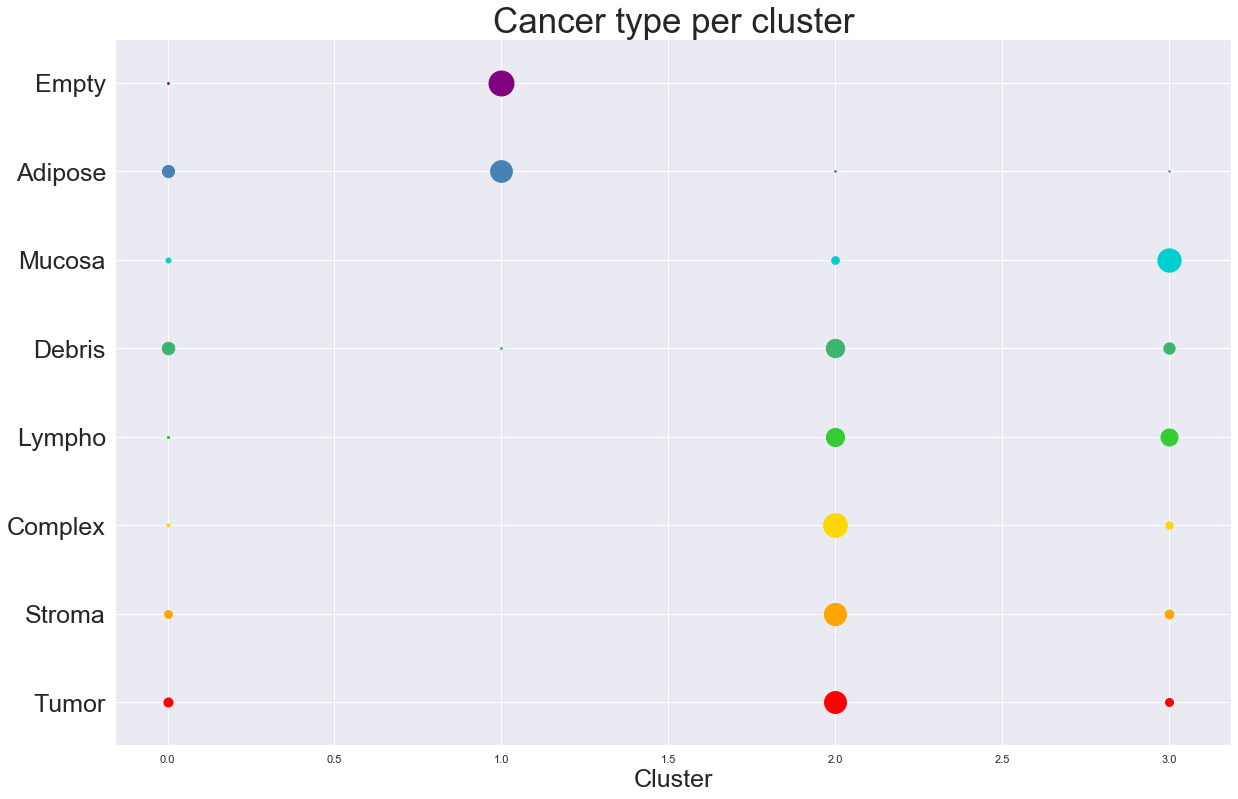

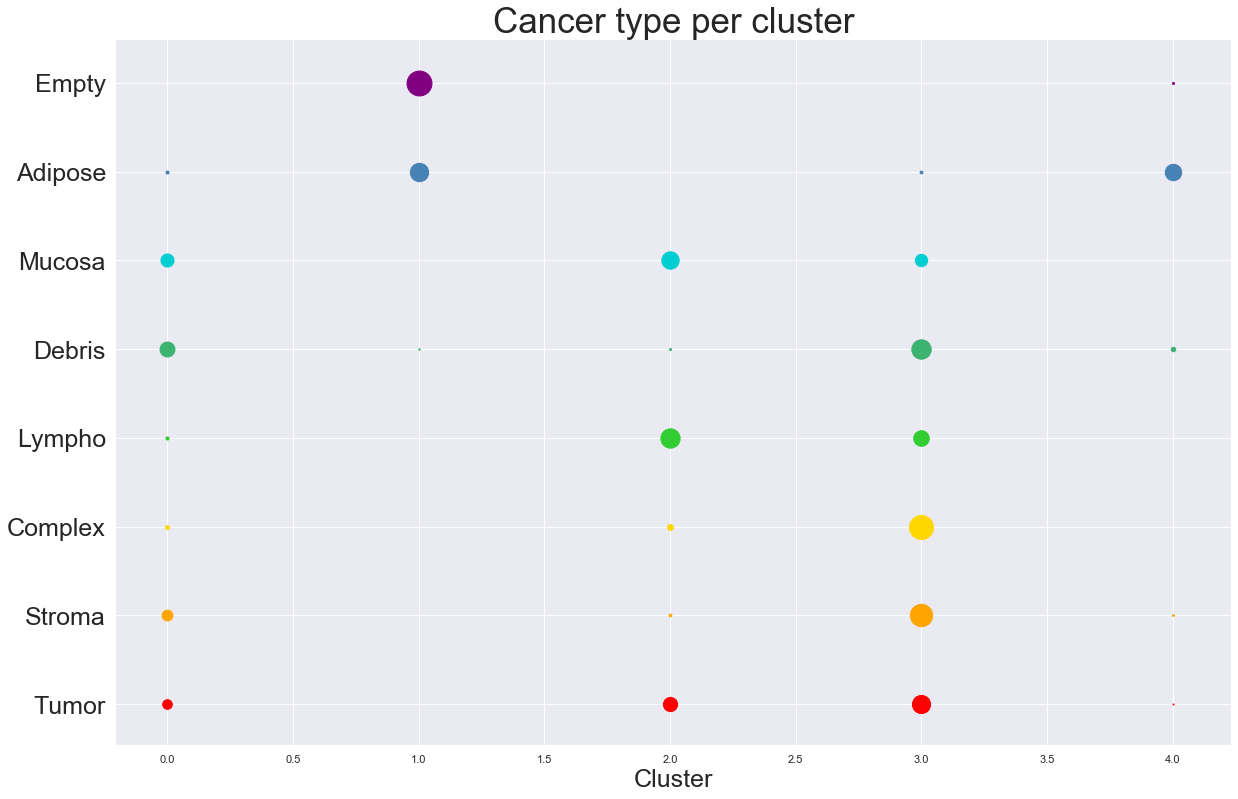

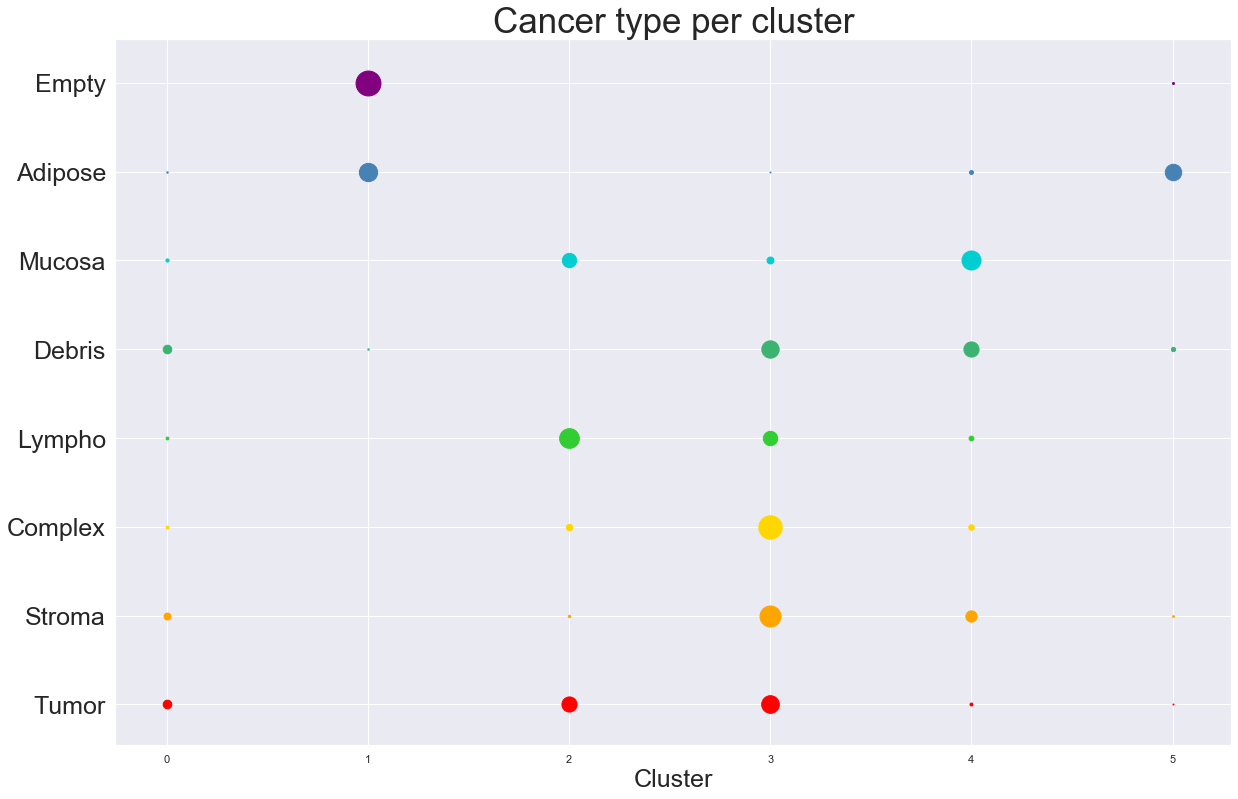

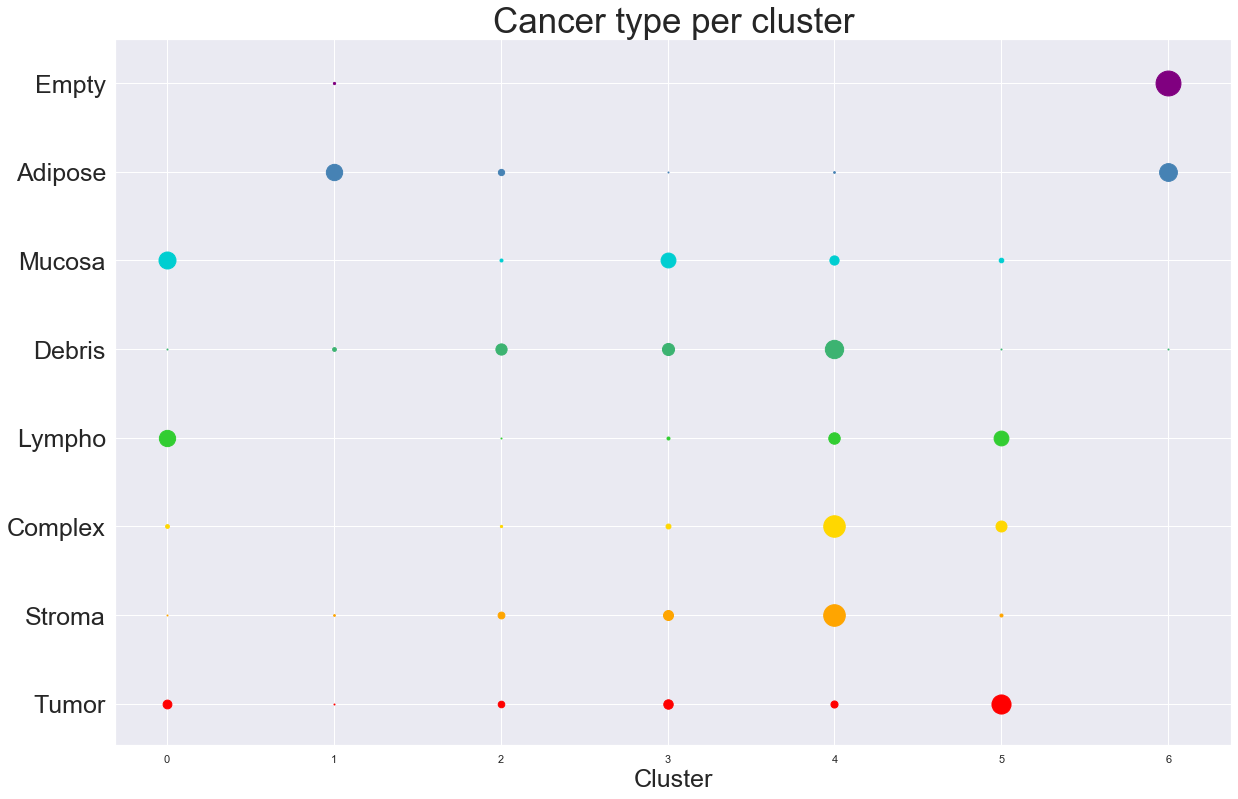

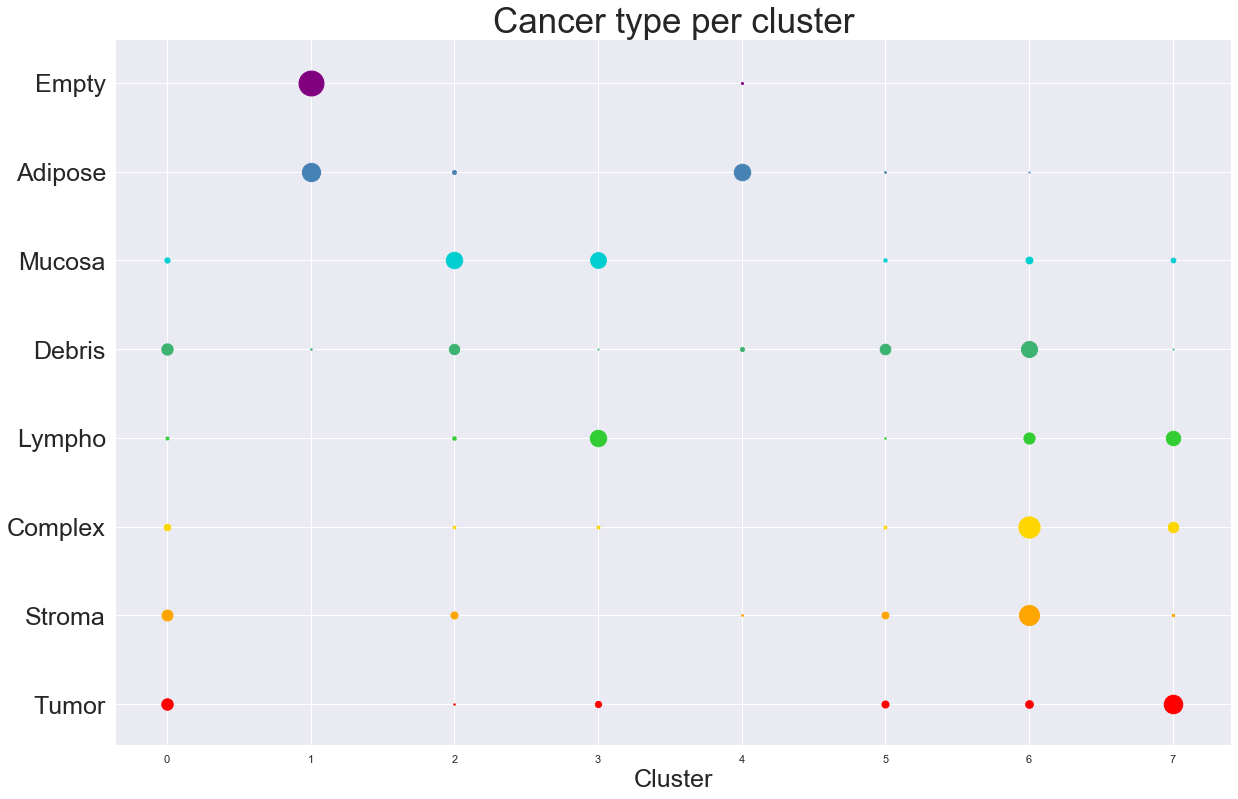

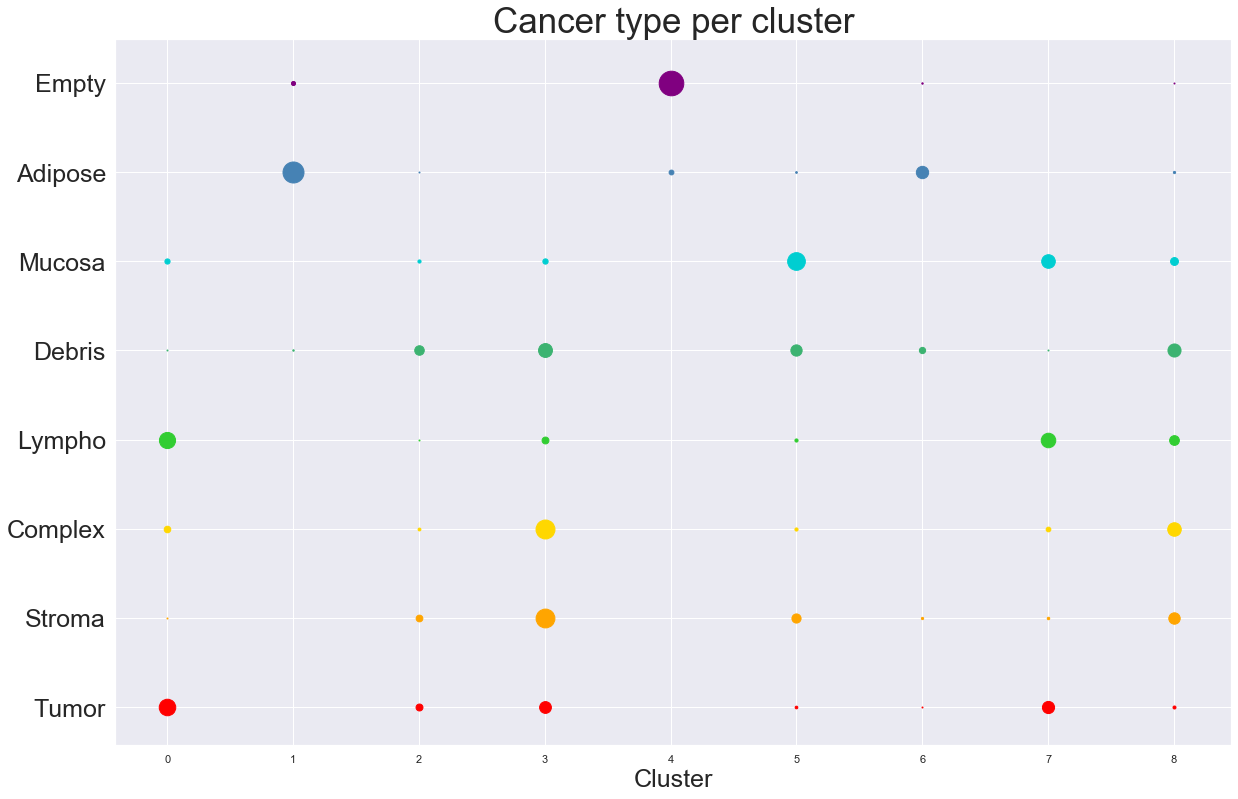

In [159]:
for i in range(2,10):
    model_plotting(image_statistics_ft_abs, i, 'full',GaussianMixture)

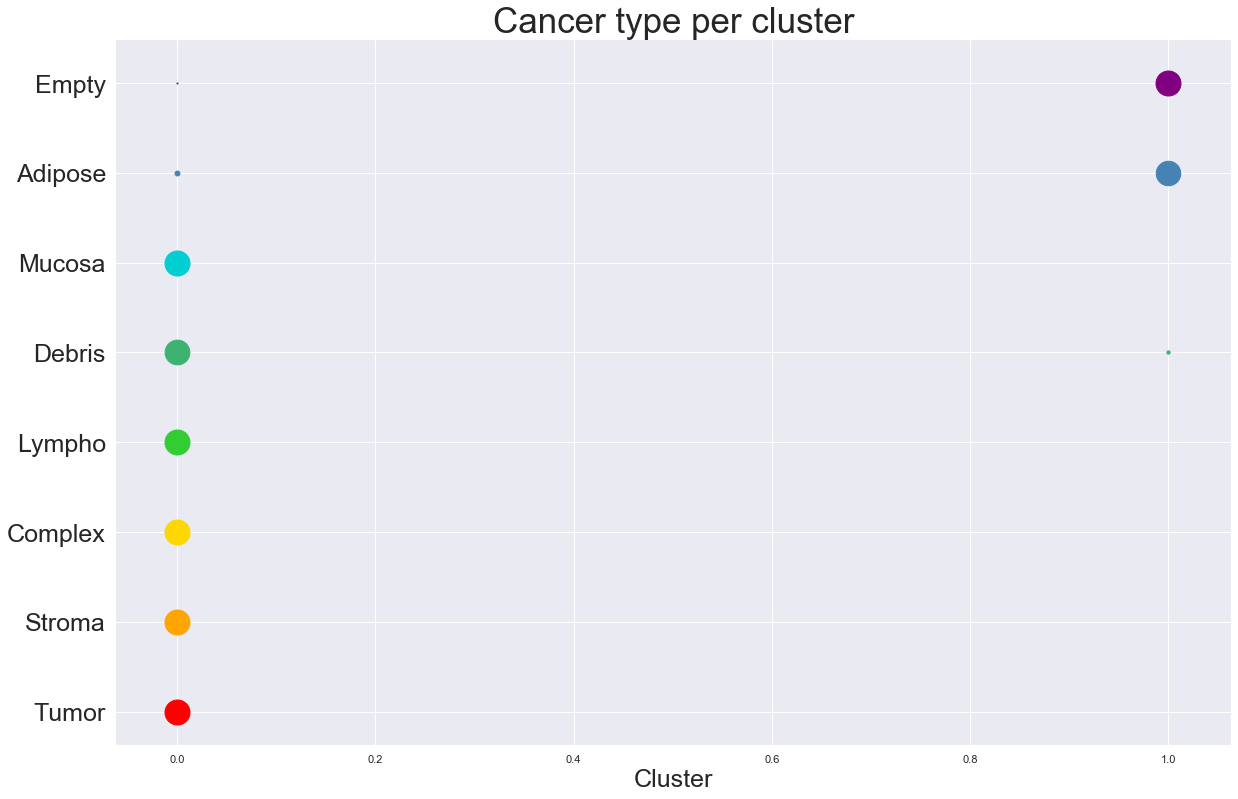

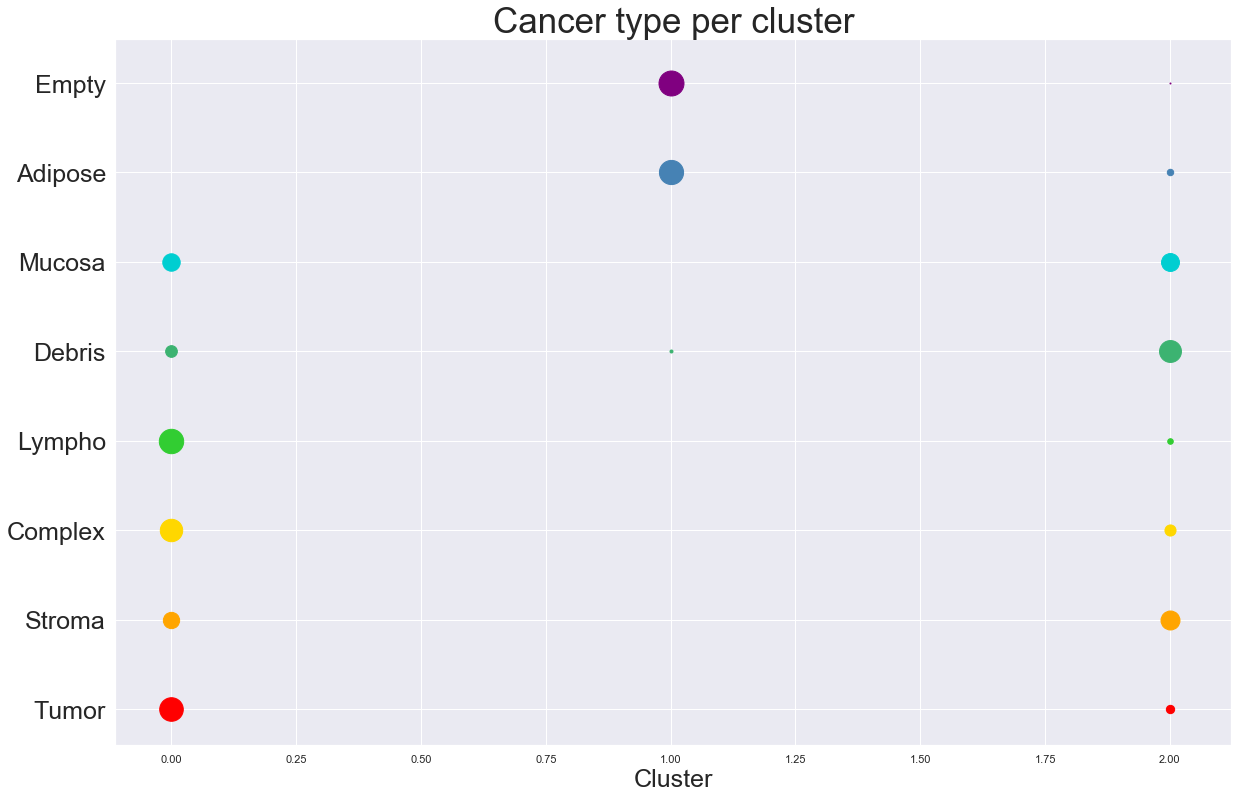

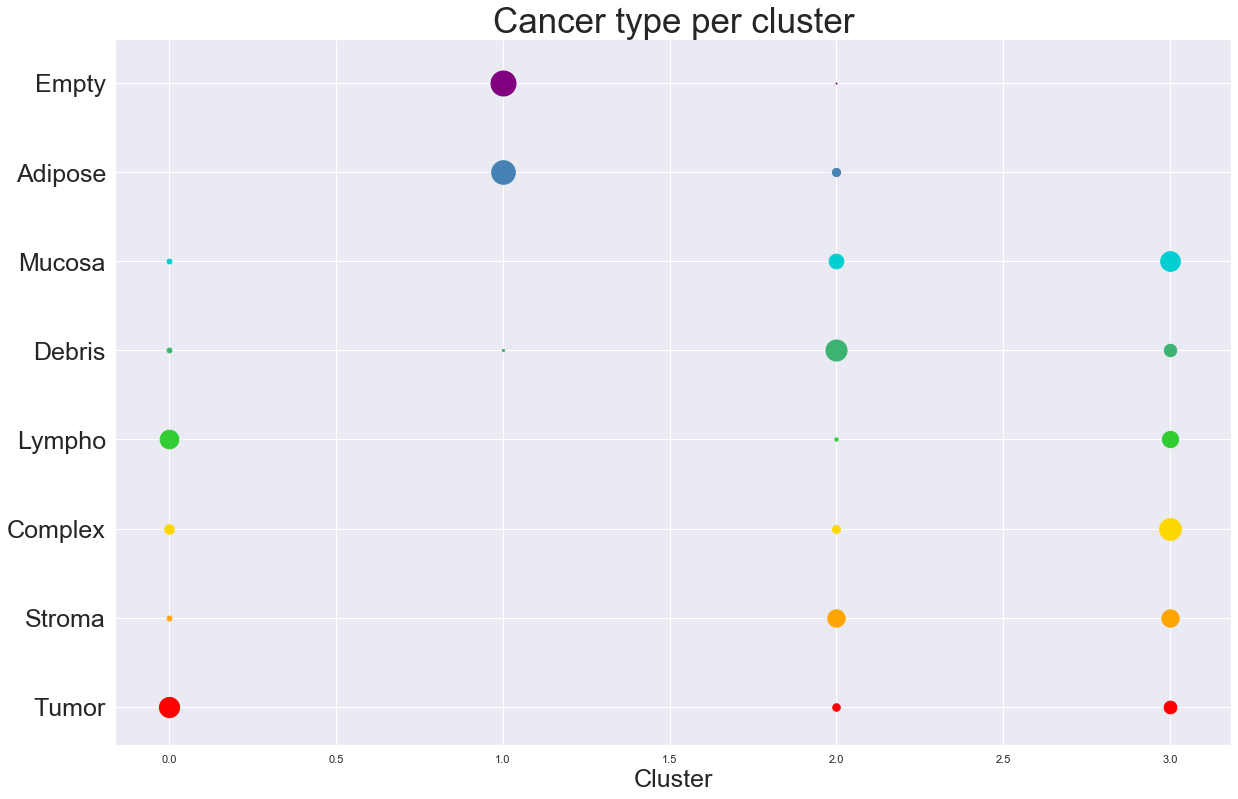

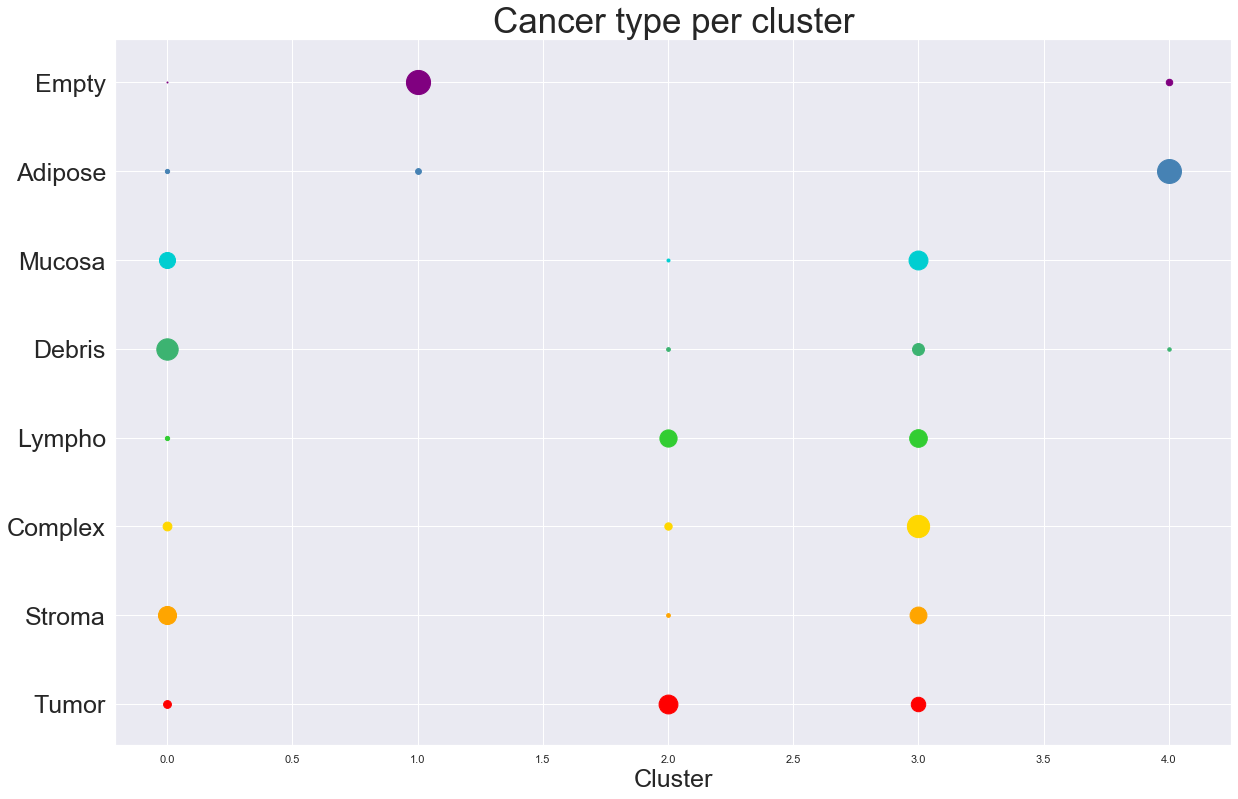

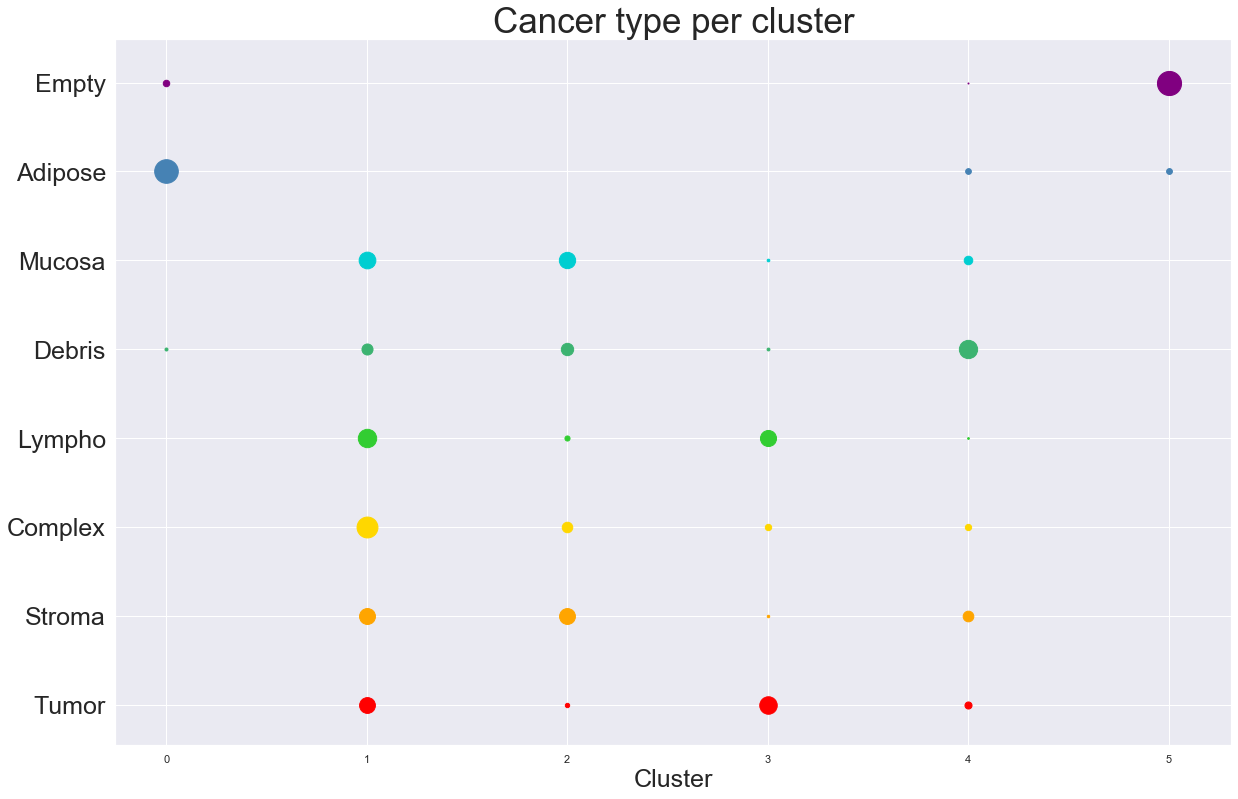

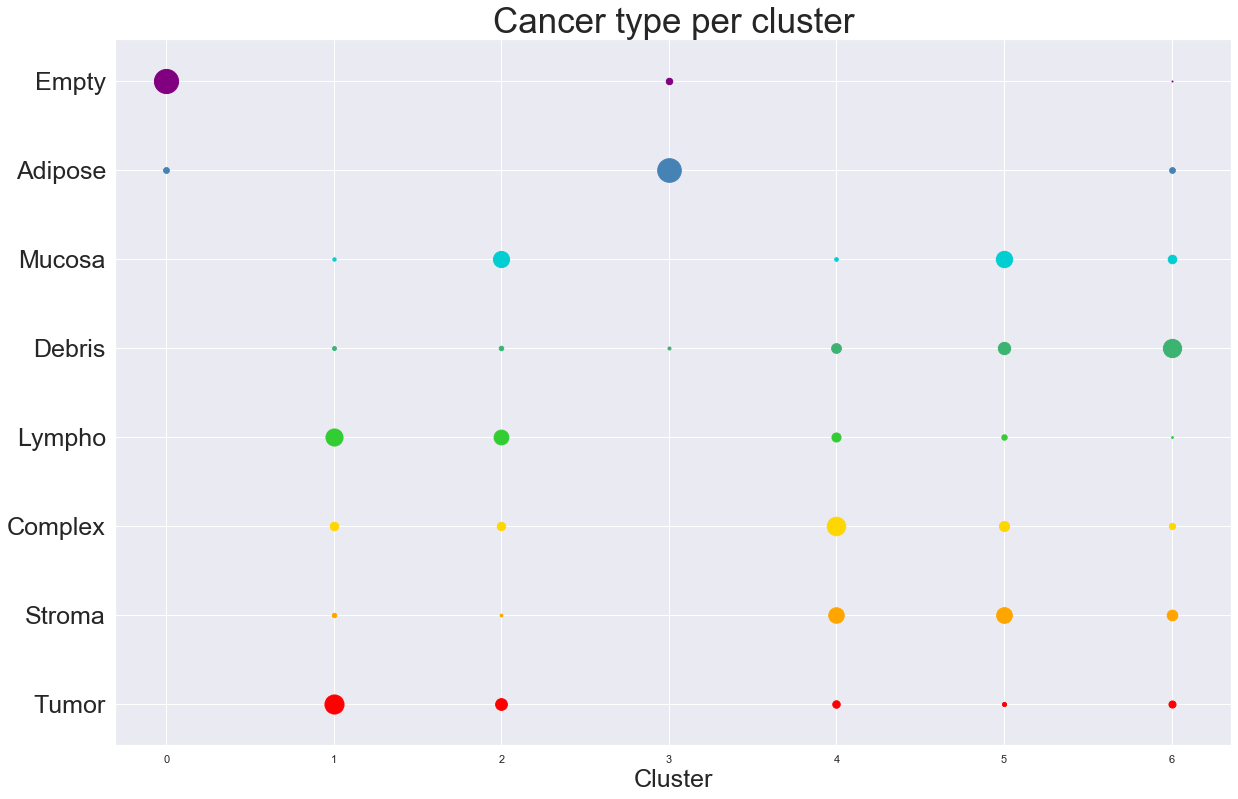

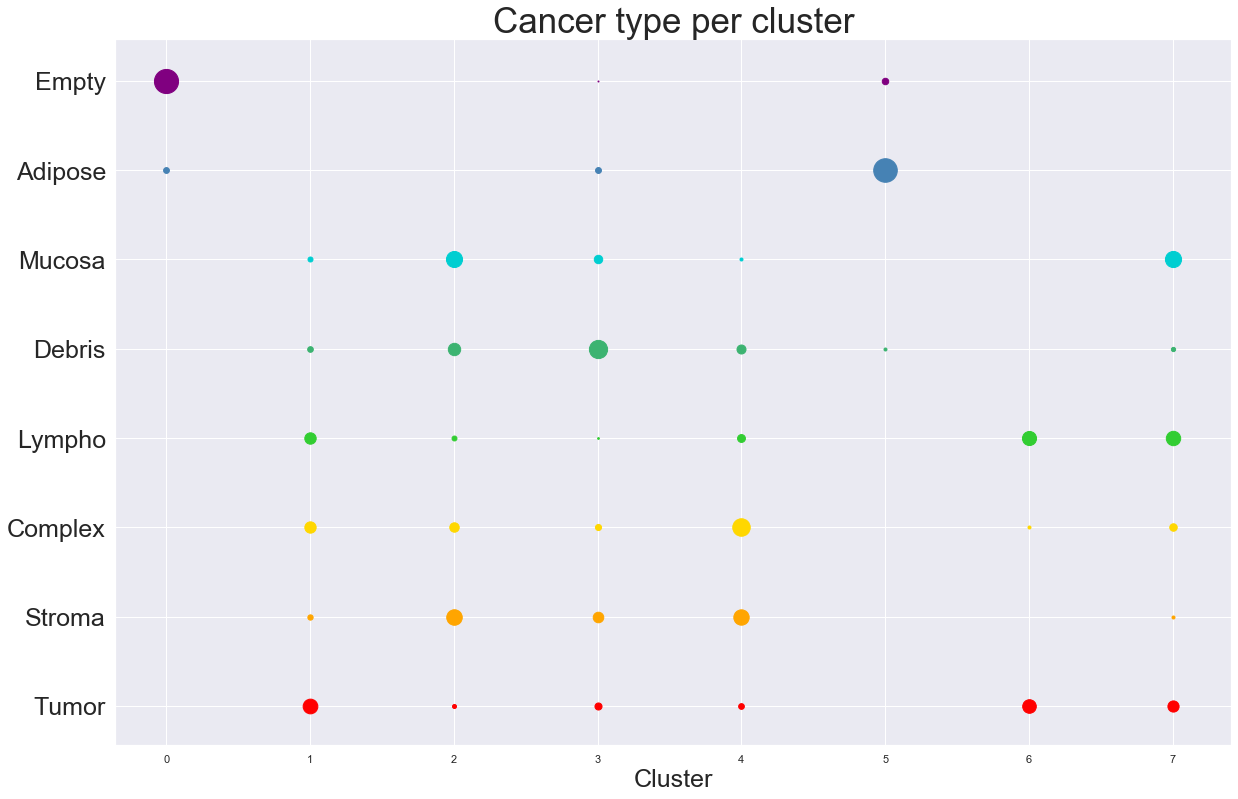

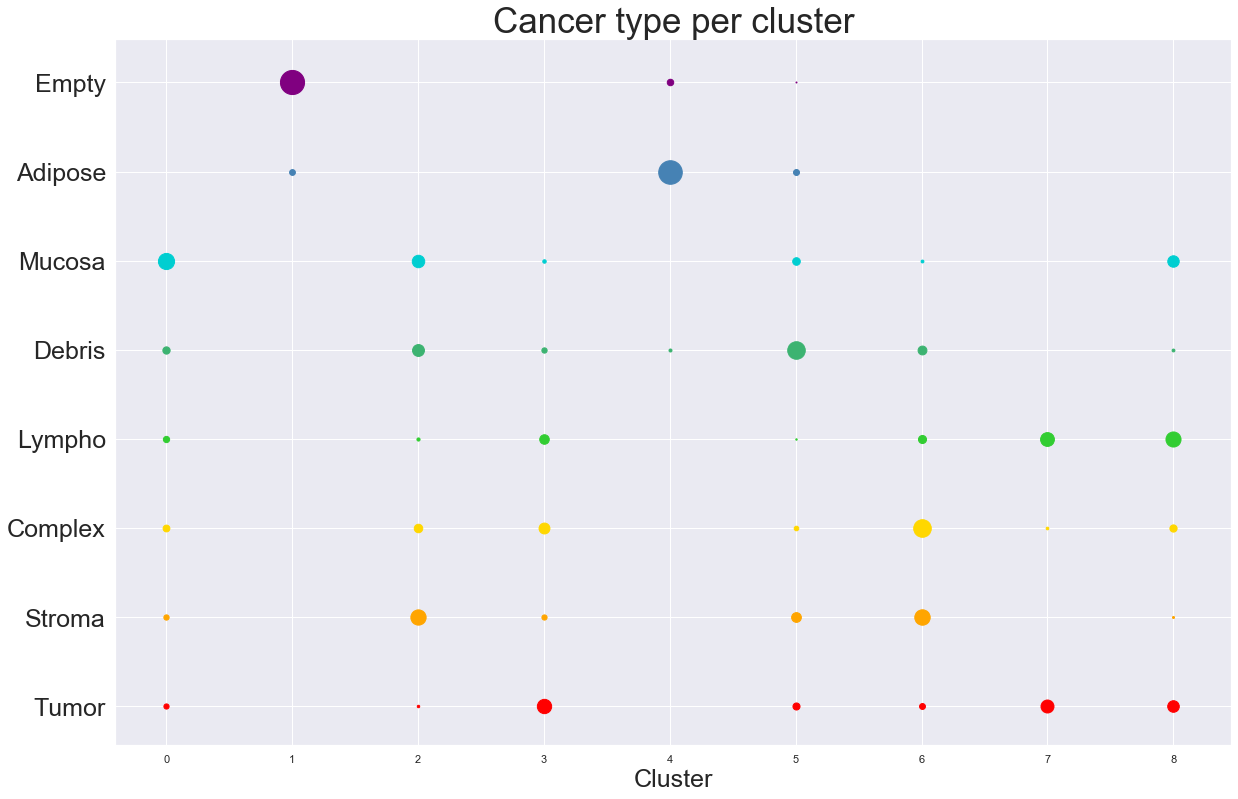

In [175]:
for i in range(2,10):
    model_plotting(image_statistics_ft_abs, i, 'spherical',GaussianMixture)

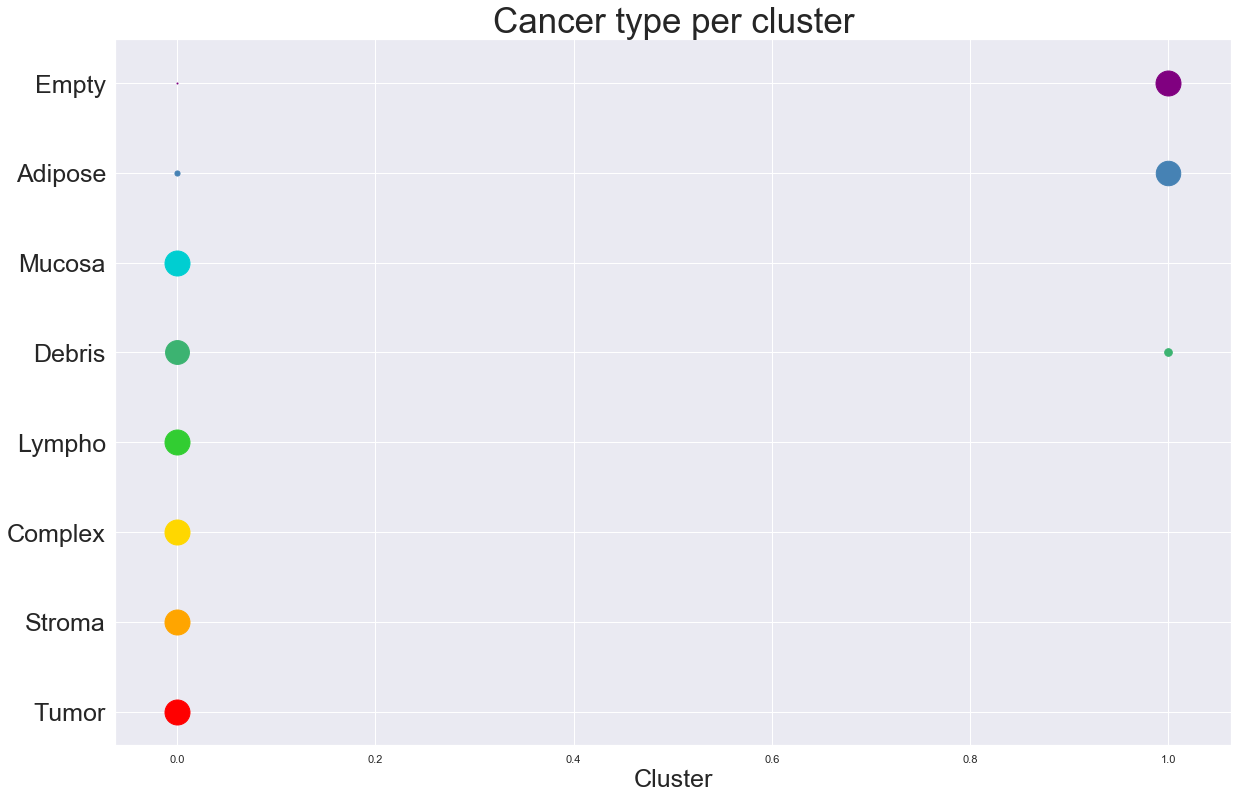

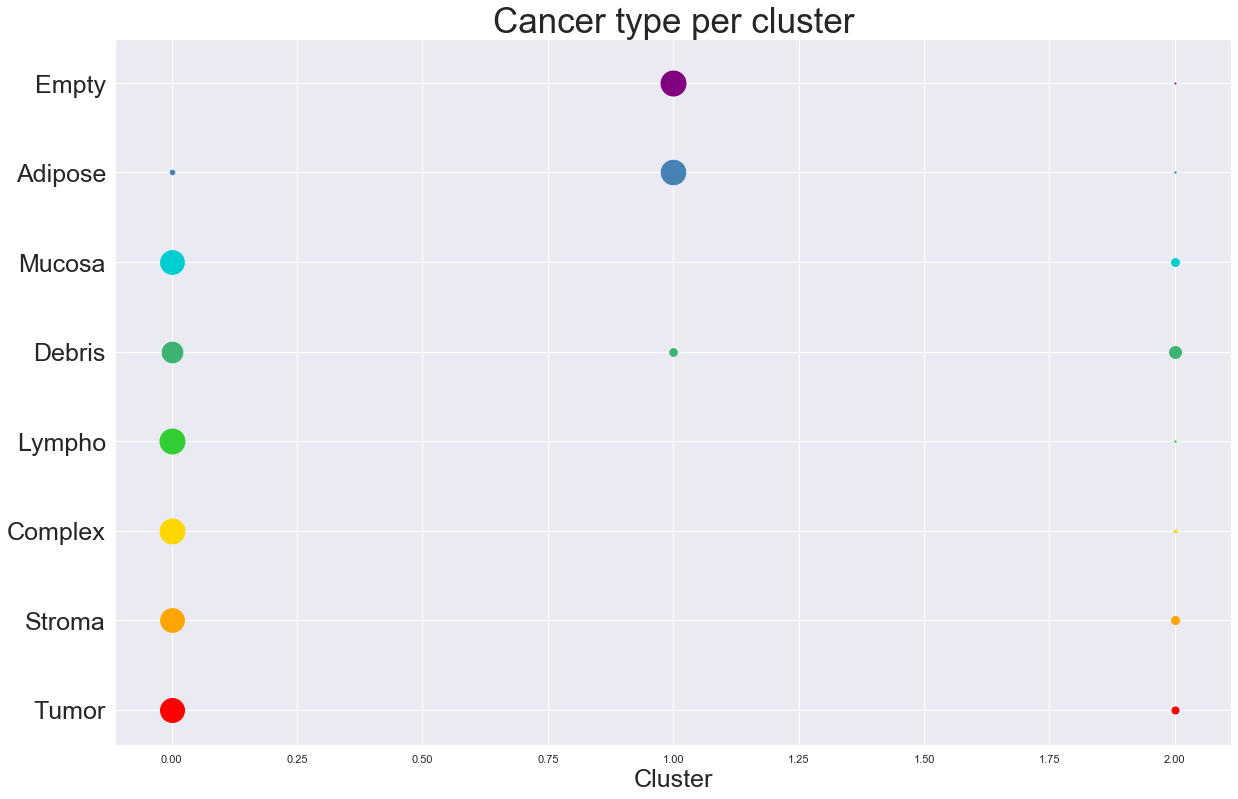

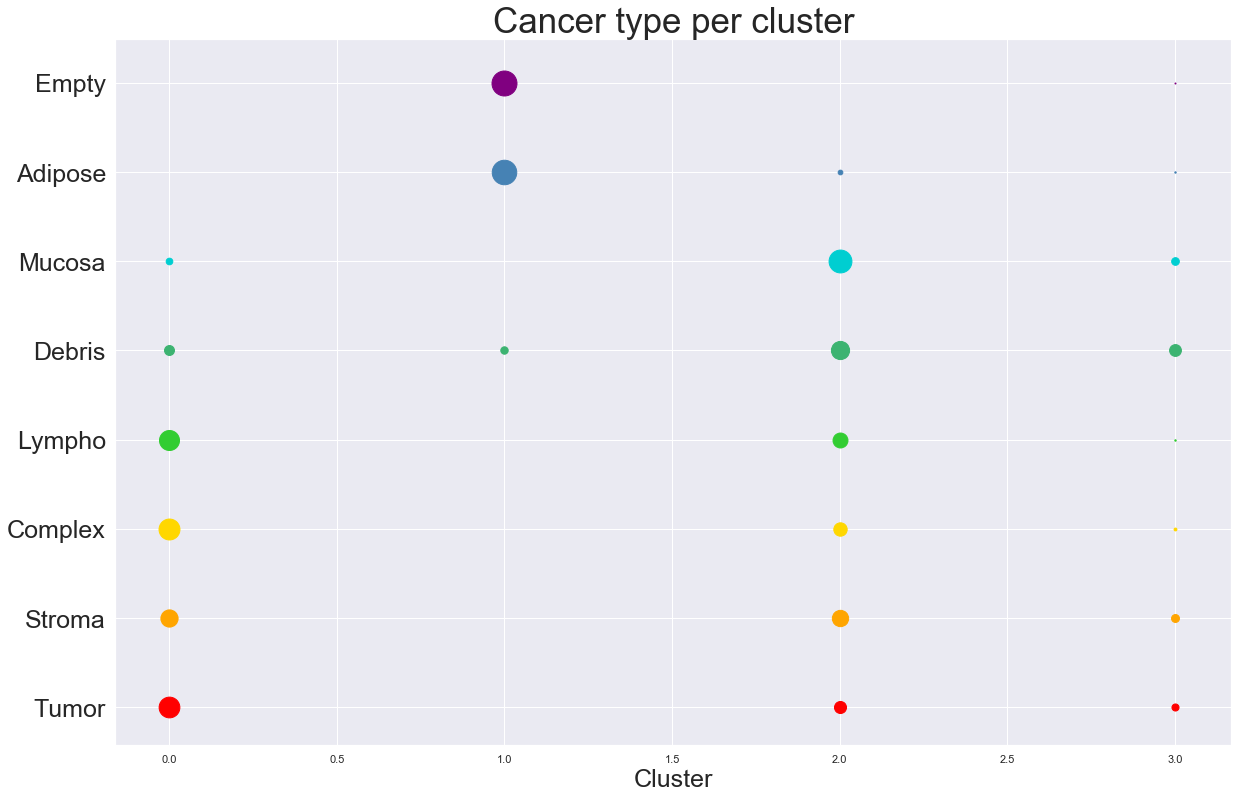

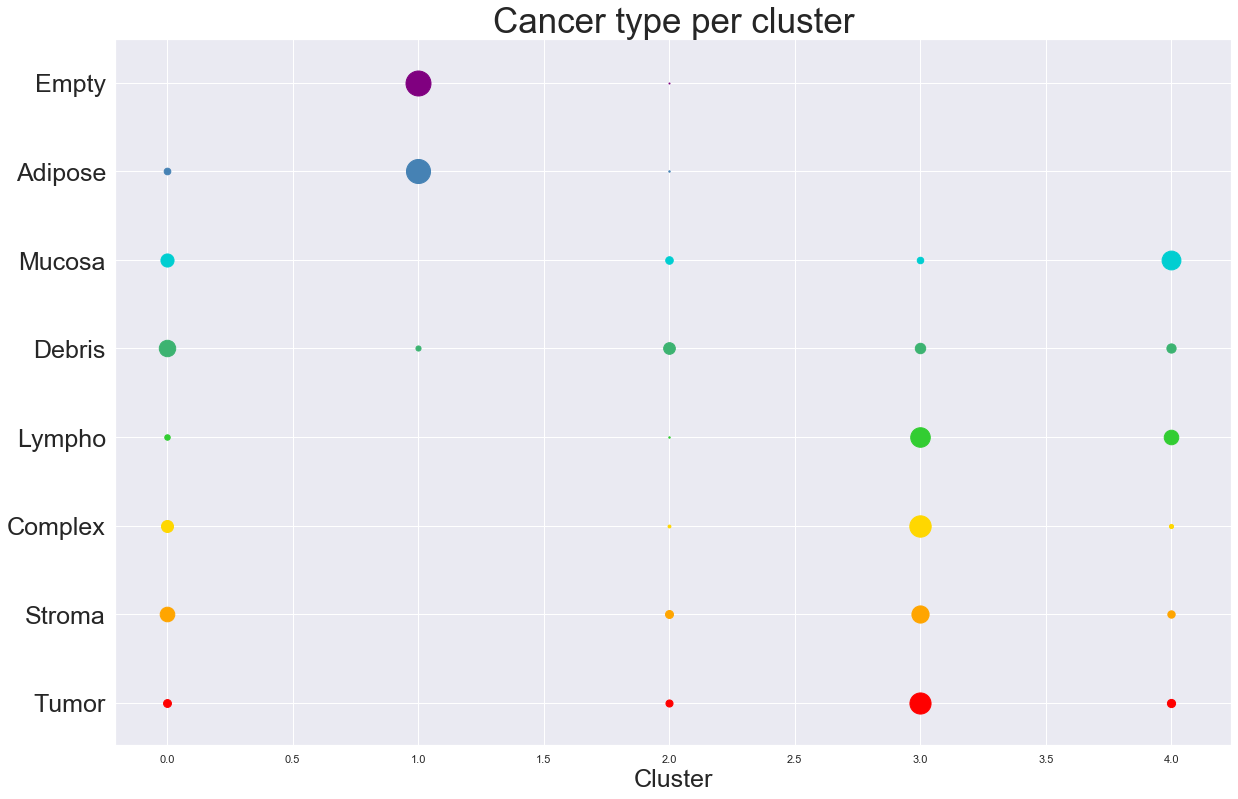

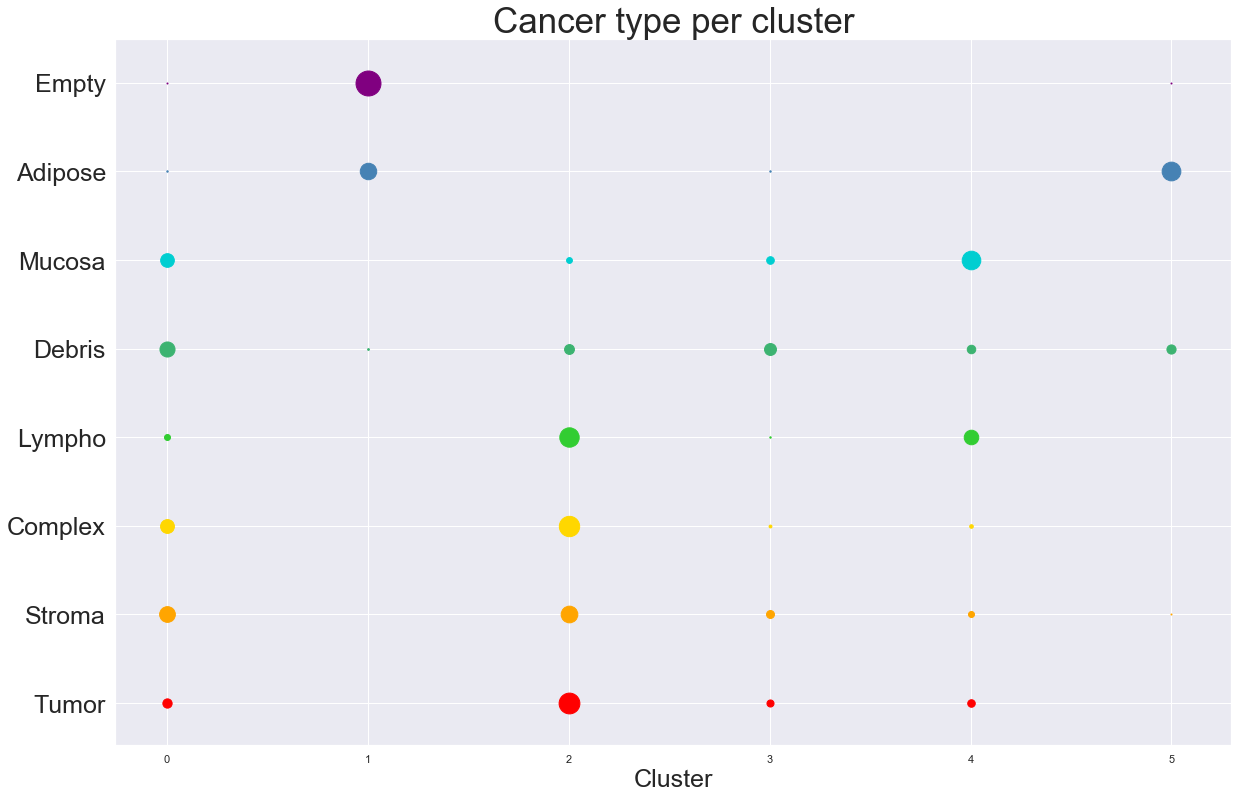

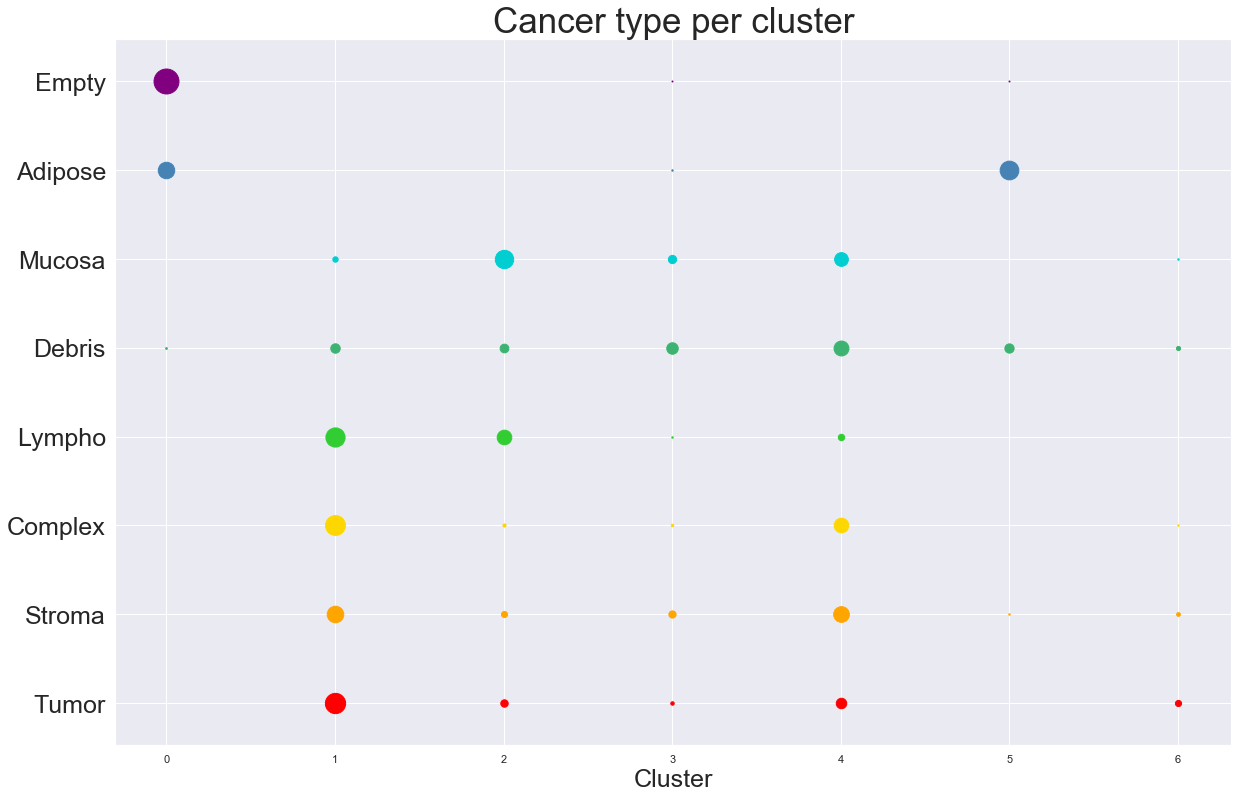

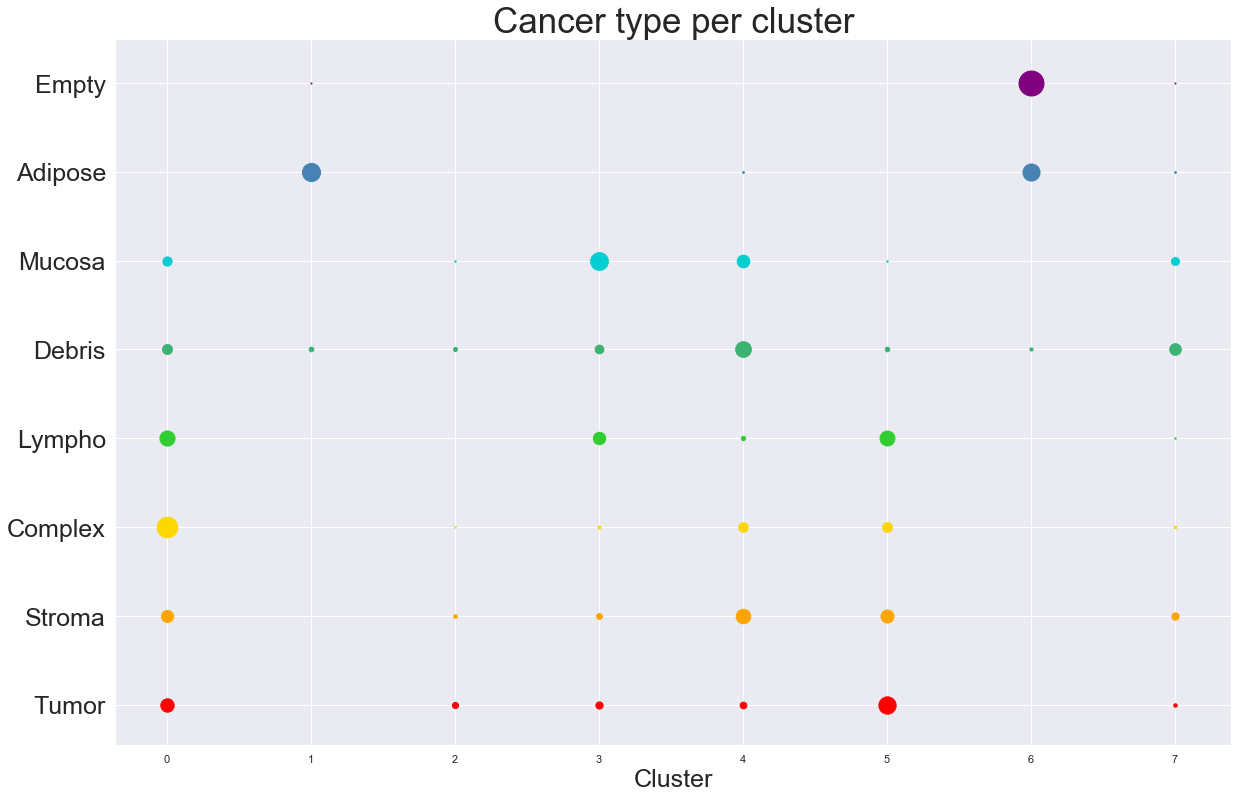

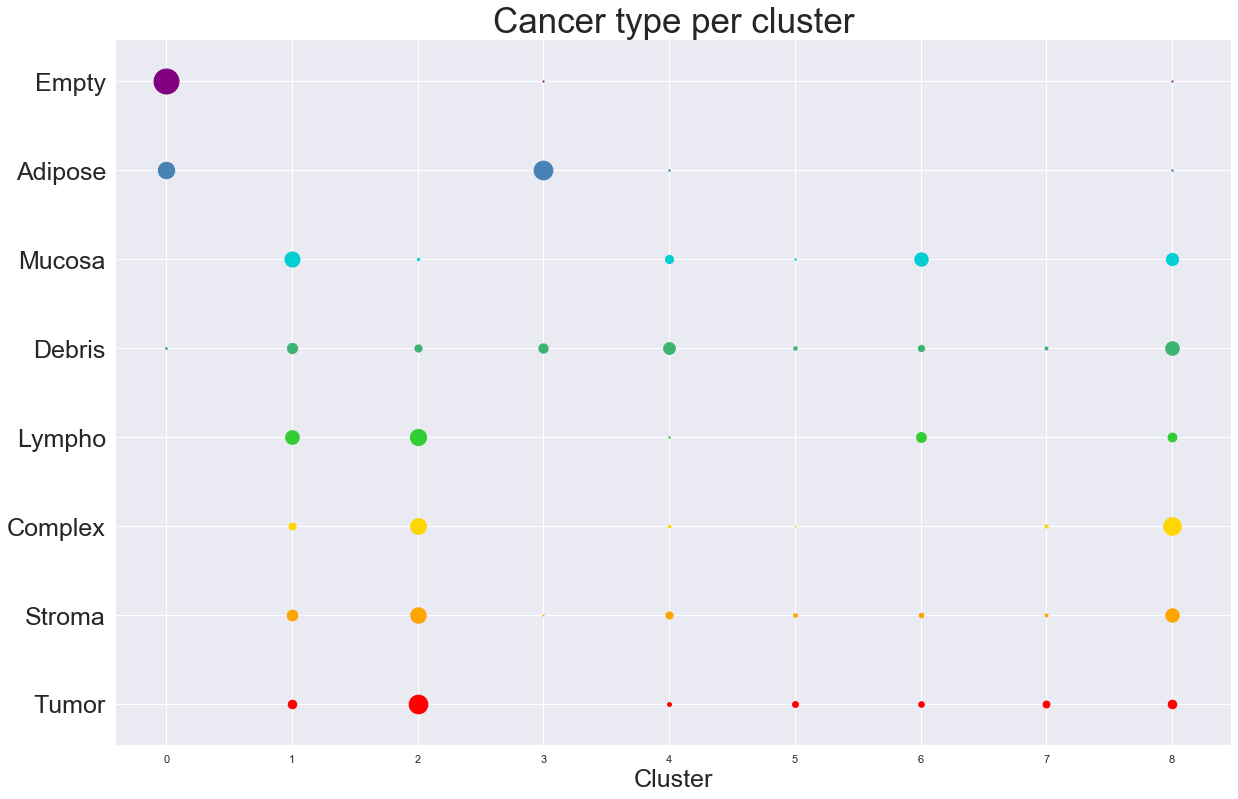

In [176]:
for i in range(2,10):
    model_plotting(image_statistics_ft_abs, i, 'tied', BayesianGaussianMixture)

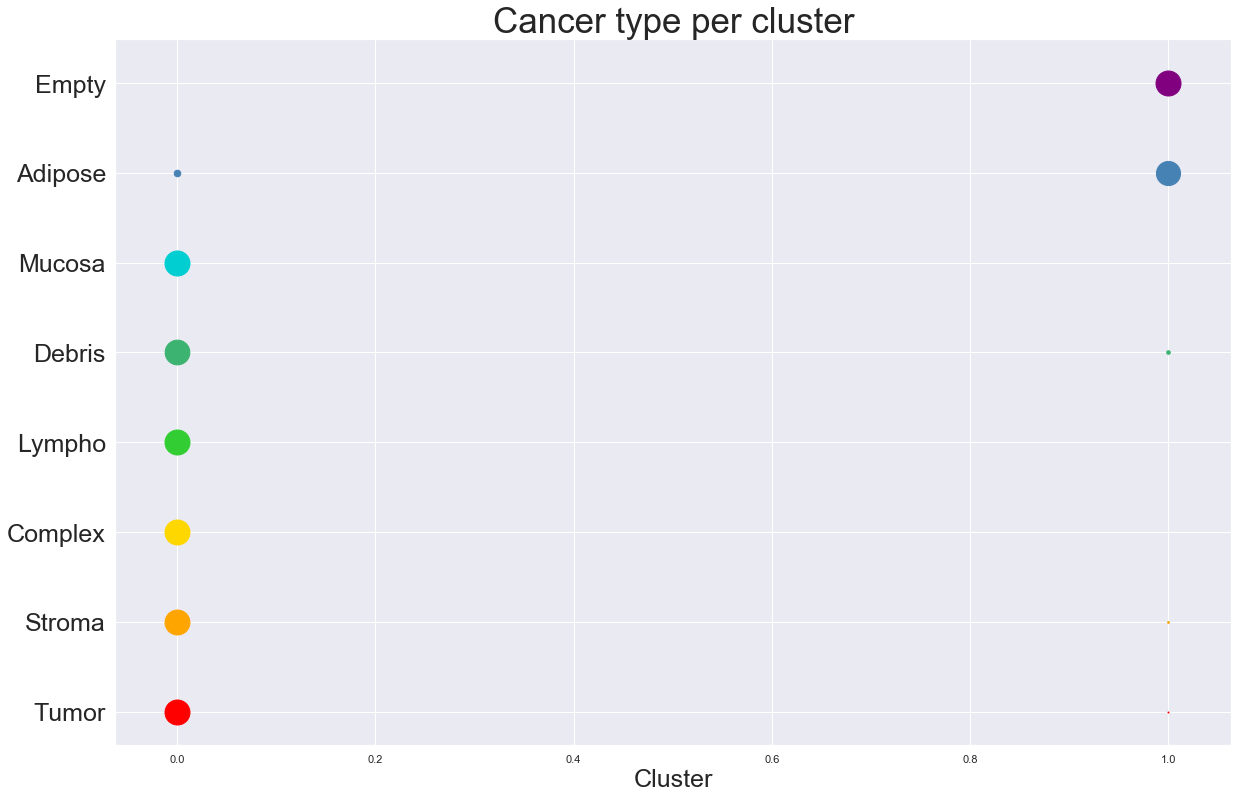

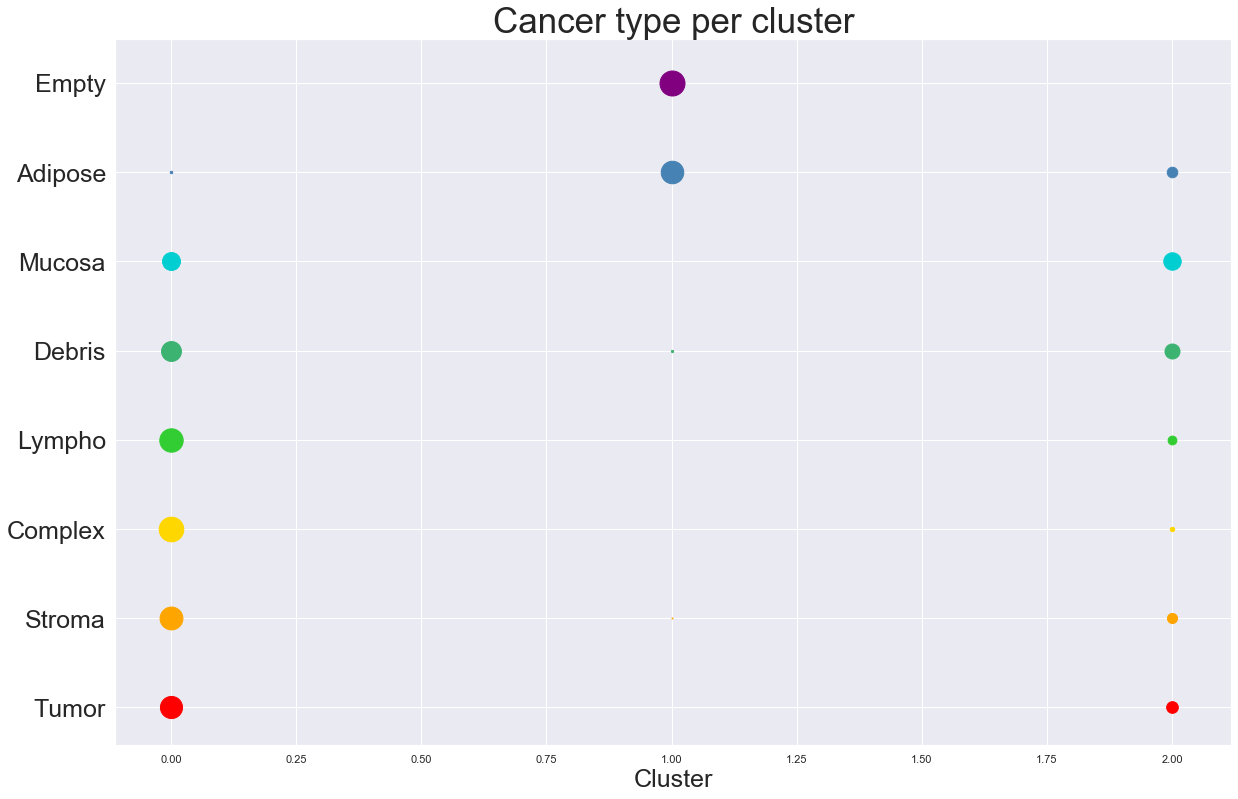

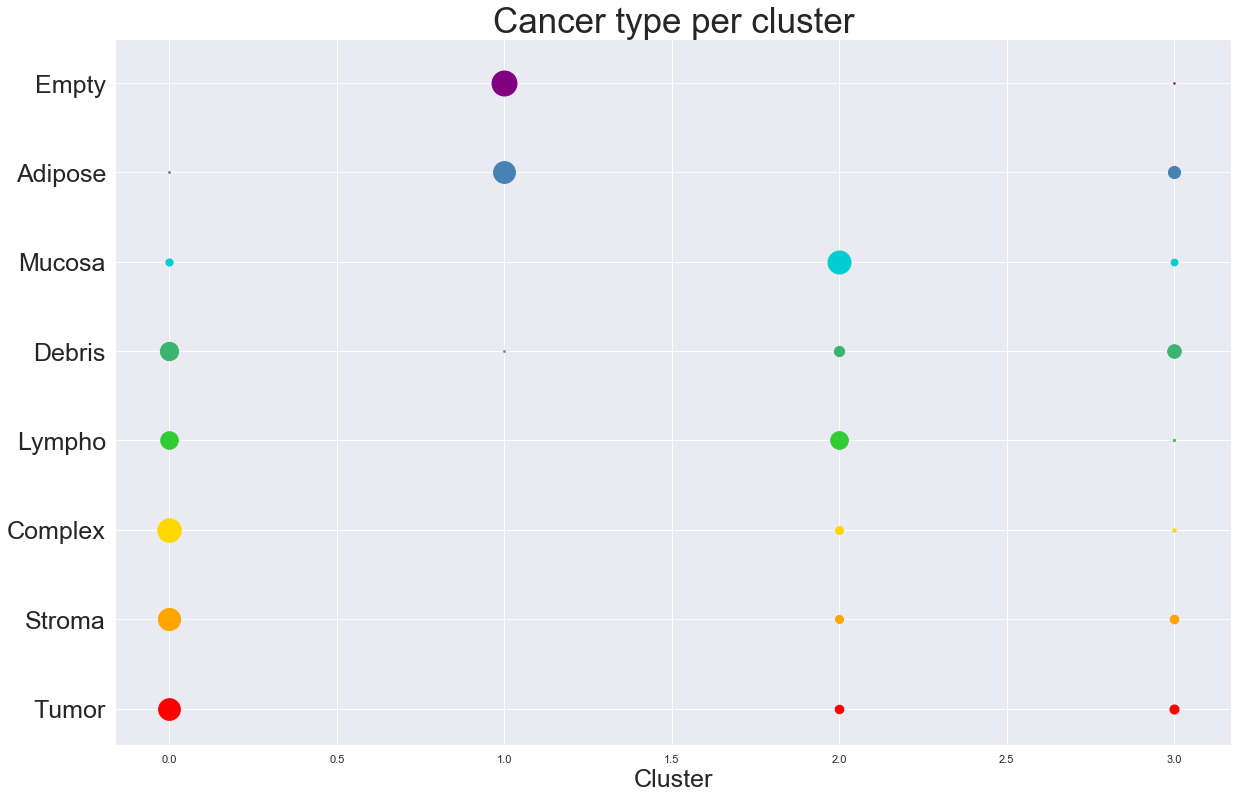

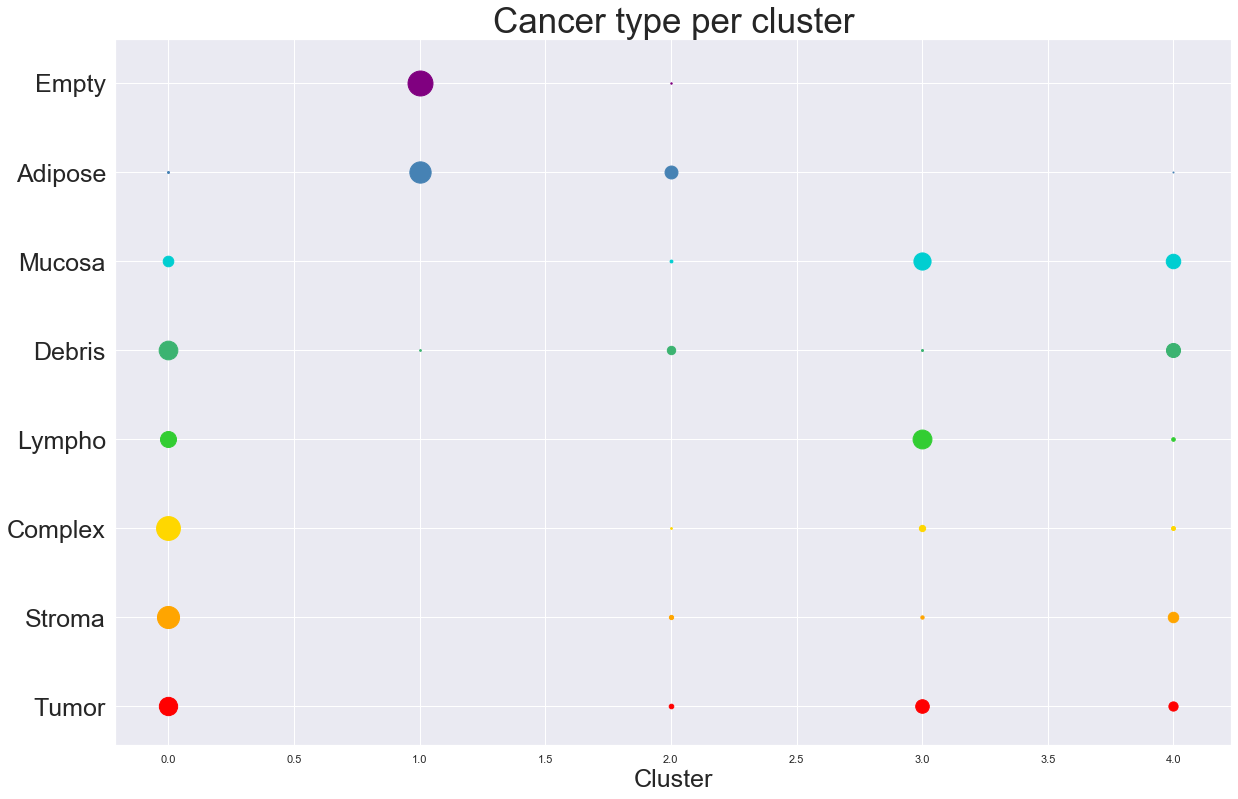

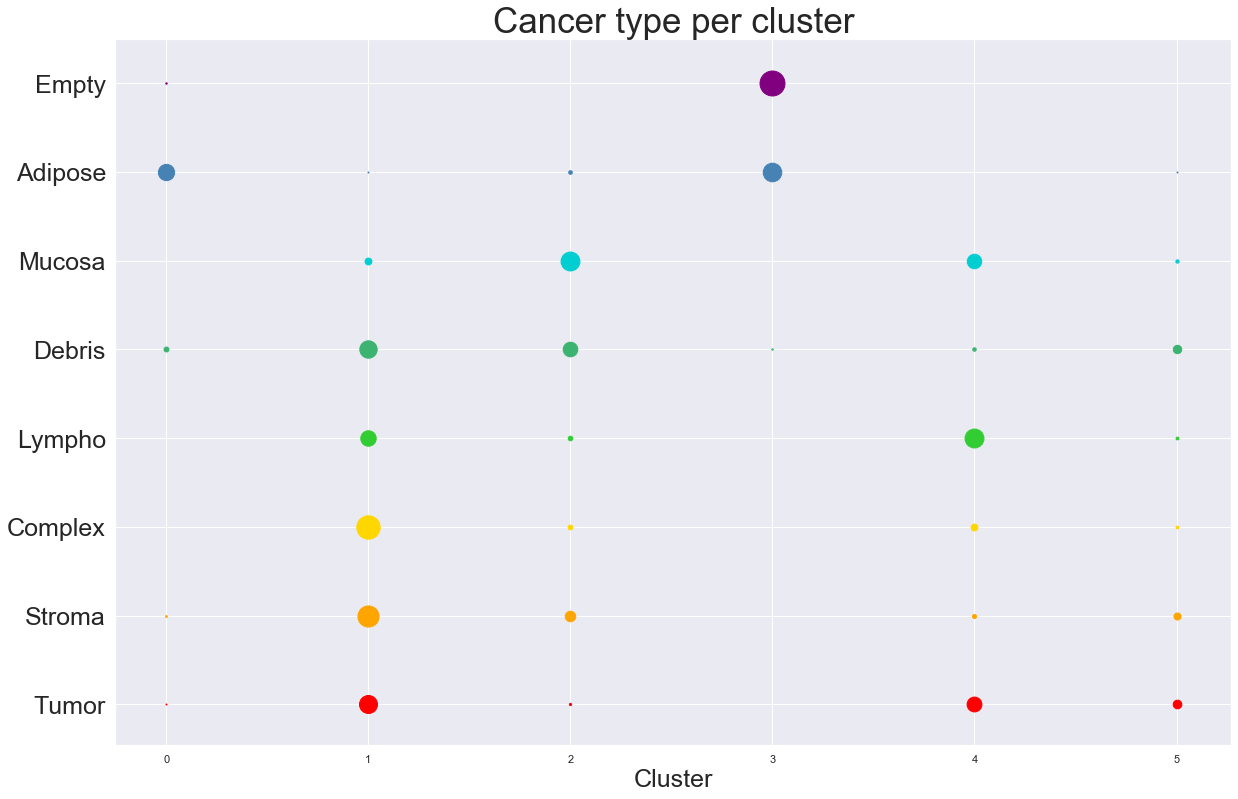

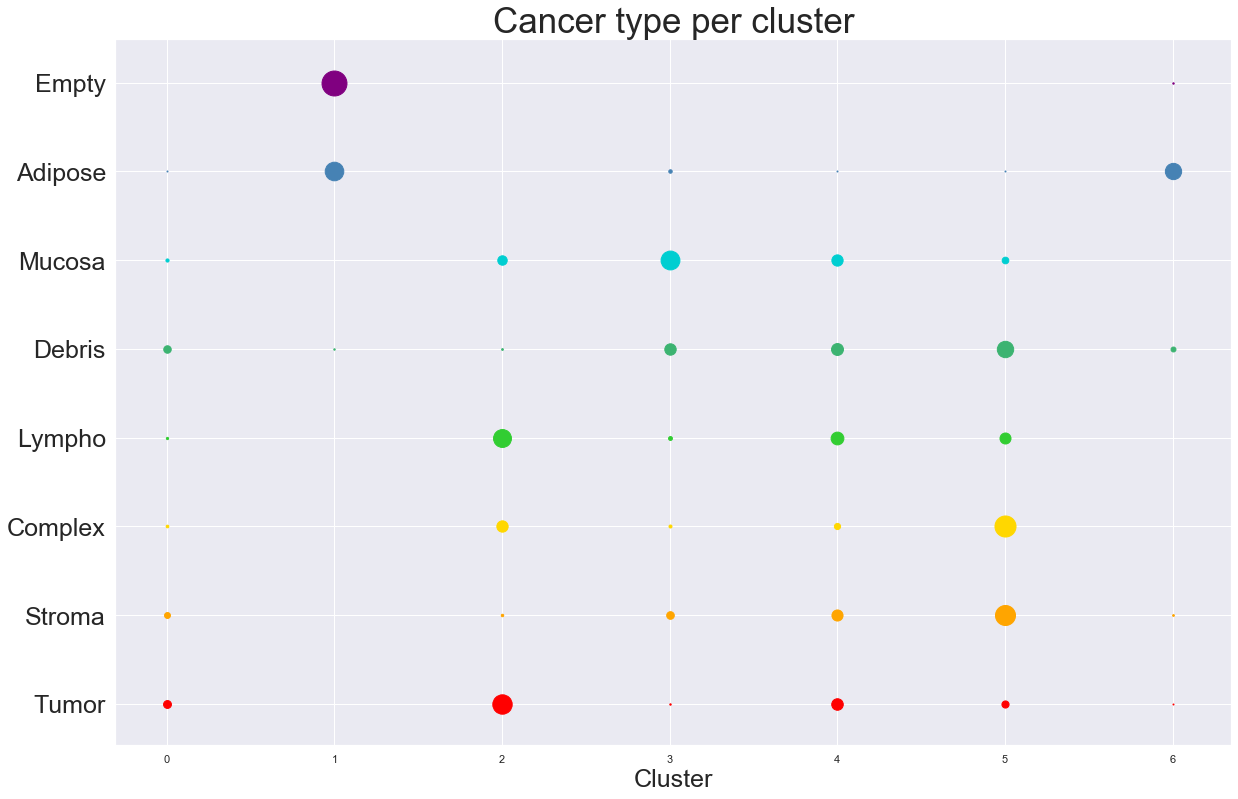

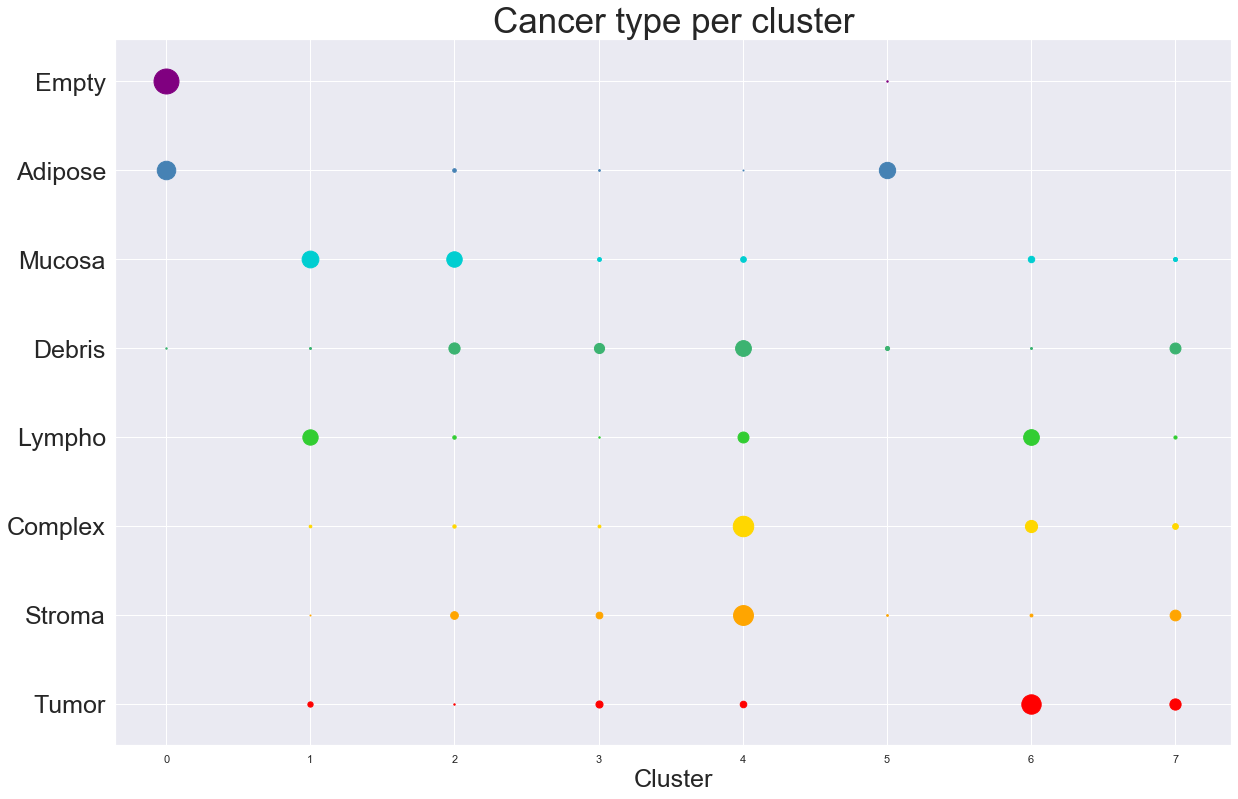

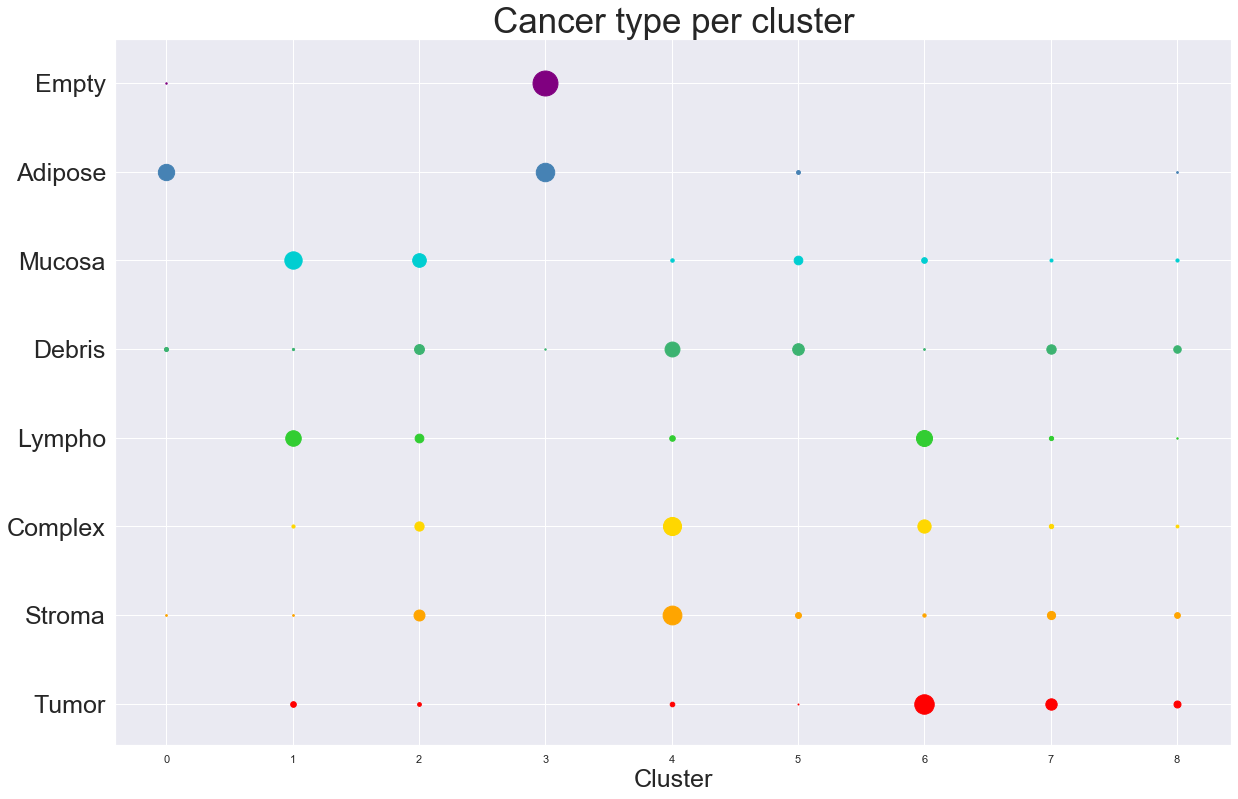

In [177]:
for i in range(2,10):
    model_plotting(image_statistics_ft_abs, i, 'full', BayesianGaussianMixture)

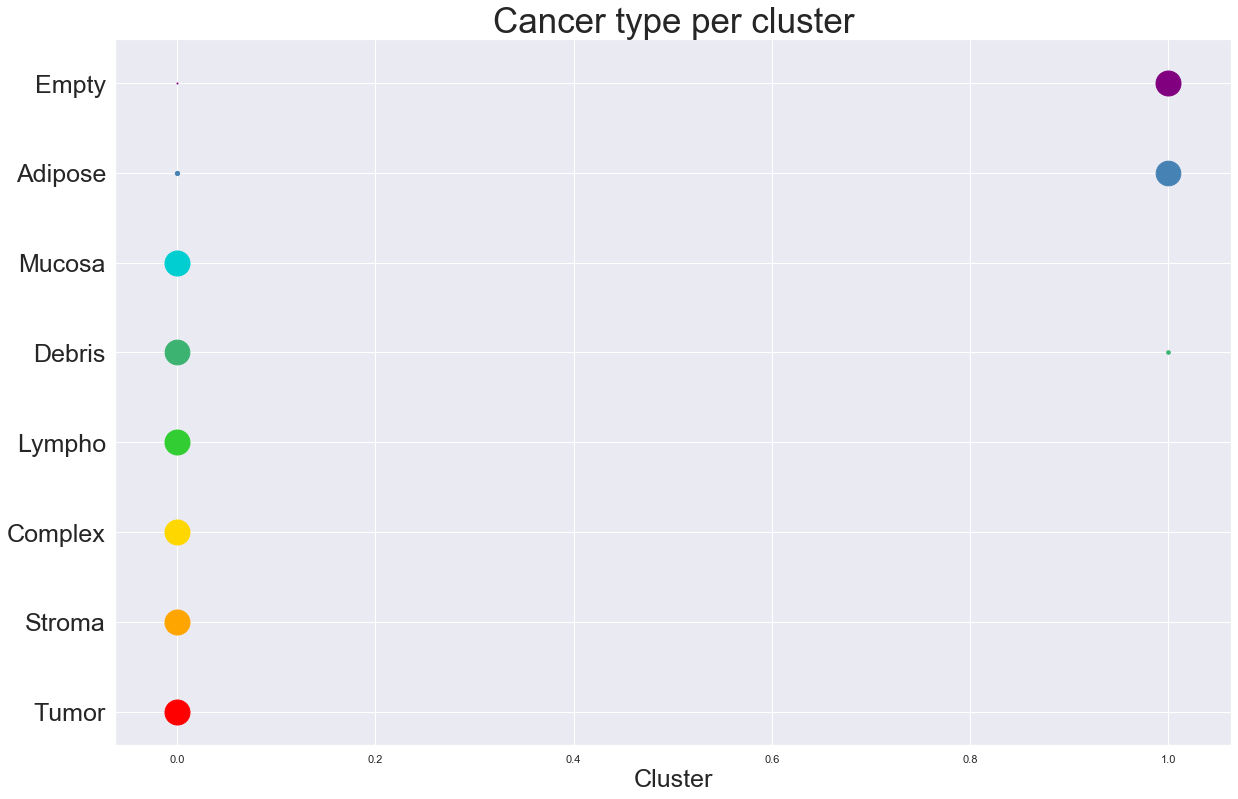

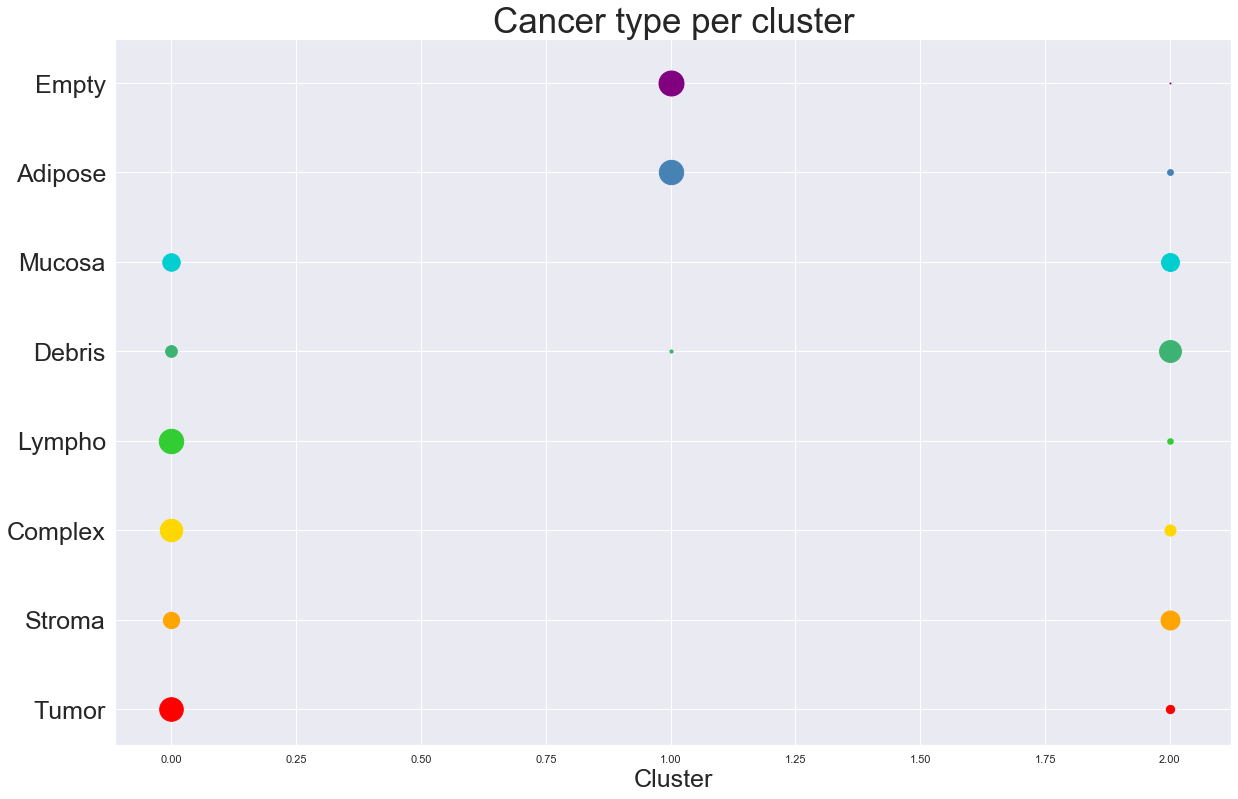

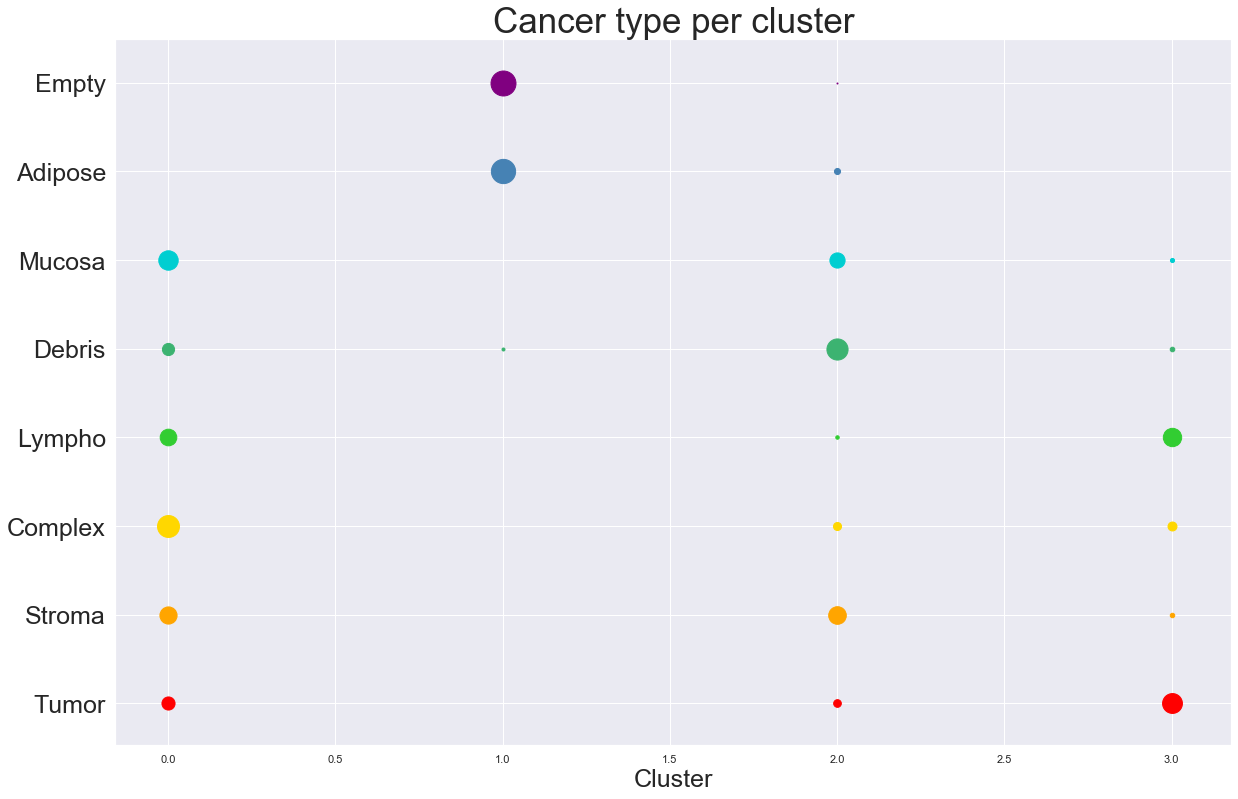

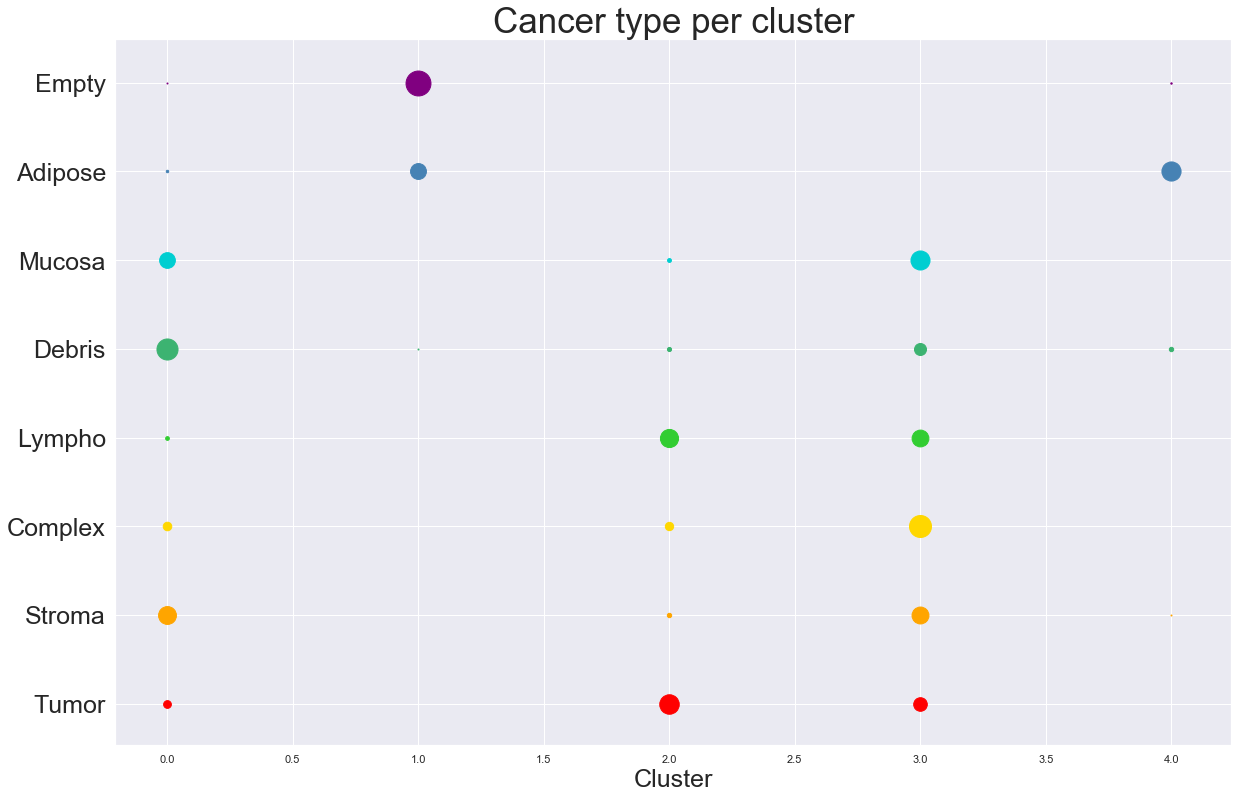

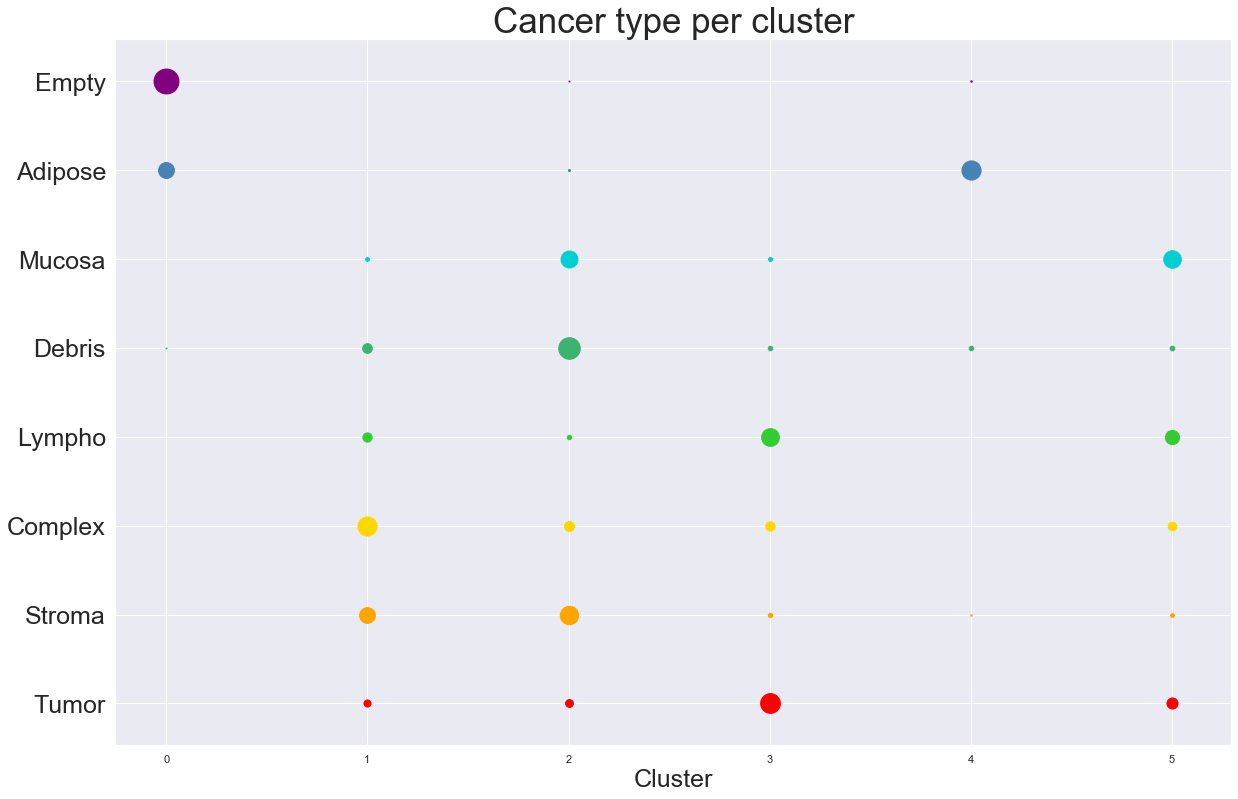

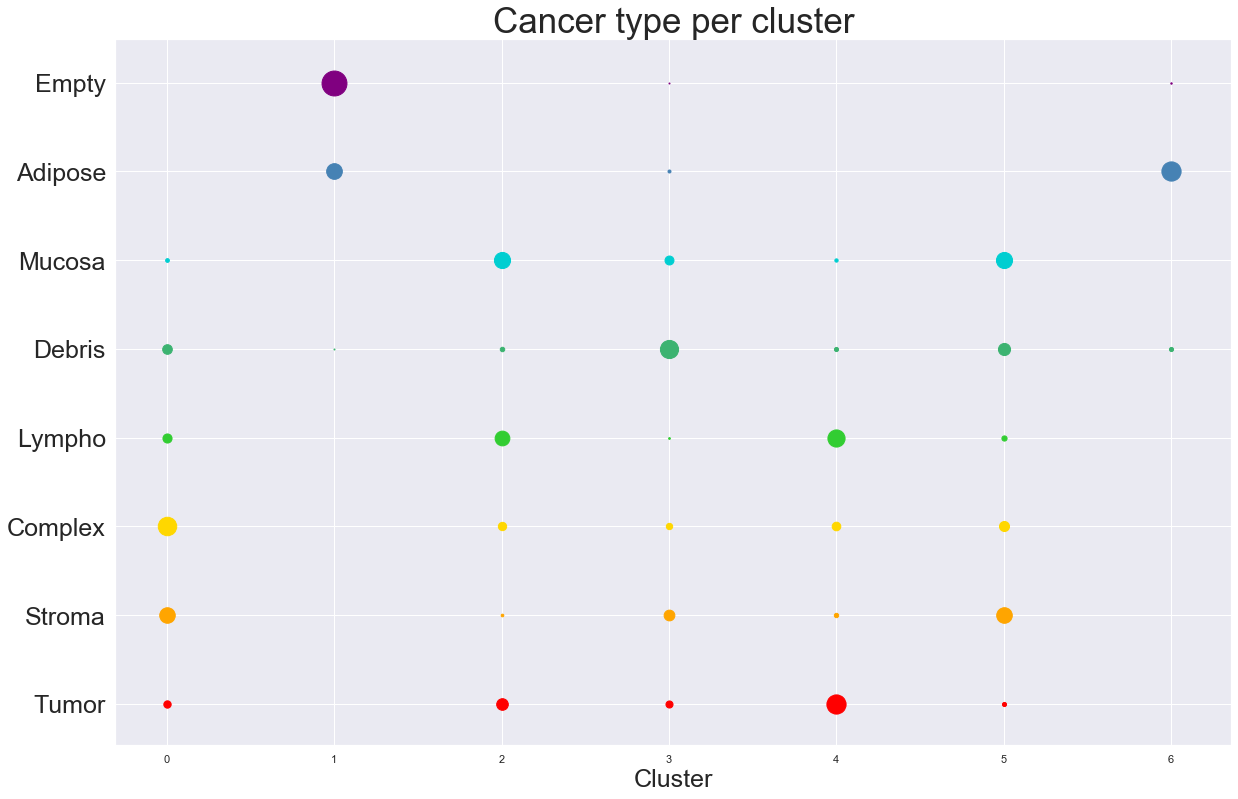

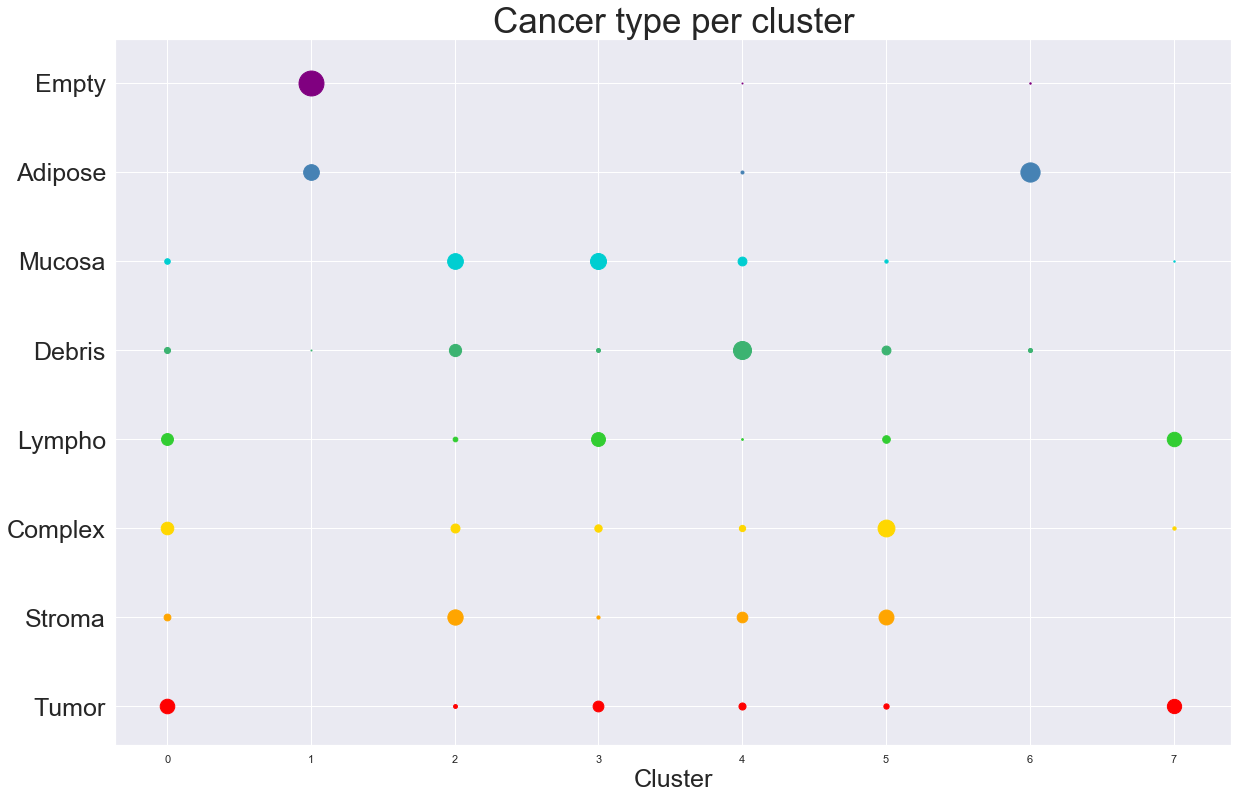

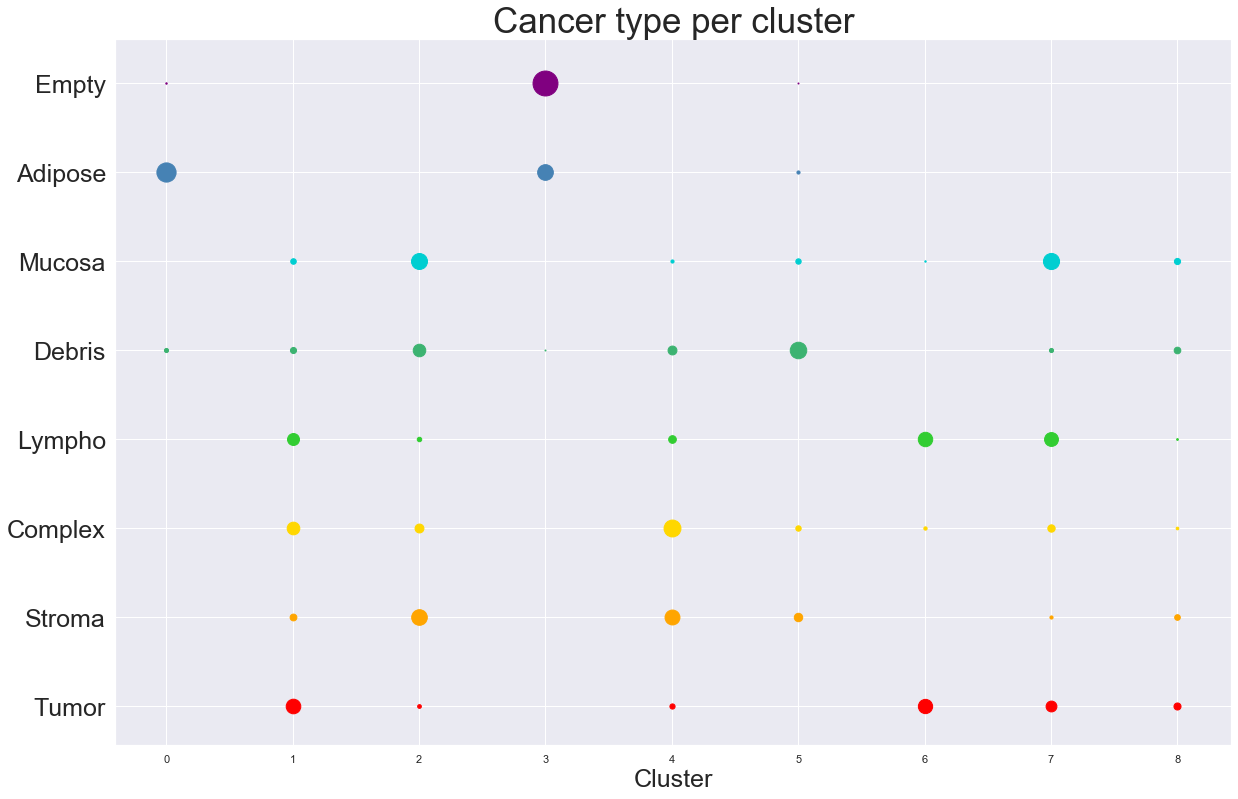

In [178]:
for i in range(2,10):
    model_plotting(image_statistics_ft_abs, i, 'spherical', BayesianGaussianMixture)

This is interesting! There is a clear difference between the 'tied', 'spherical' and 'full' covariance. The 'full' covariance assumes the most general 

We see the Adipose Tissue and the Empty tissues separating into different clusters beyond n=4! Just by looking at these plots compared to what was made earlier, we see that there's a striking difference at least in terms of these two tissues. Looking at the plot for n=8, Complex seems to have clustered well, so has Debris to an extent, and Stroma has split mainly between two clusters. The rest of them haven't shown a big difference but that was expected in a sense, wasn't it. Clustering after such minimal preprocessing isn't going to give you a brilliant model anyway. I wonder what other preprocessing can be done to improve the clustering model! Some other day though. 

## Neural Network

Let's now model a Neural Network on this data to classify the types of tissues

Let me describe what a Convolutional Neural Network does.

We have a dataset that has 5000 samples (4000 train + 1000 test), each having 64 * 64 pixels (since this is grayscaled already). 

Here I'll be using Keras (tensorflow backend) to create a Convolutional Neural Network. This is a quick description of what a CNN does.

To build a simple CNN, there are 3 kinds of layers: Convolution, Pooling and Fully-connected. The convolution layer will apply a filter (kernel) to map the input image into another kind of image. 

Pooling on the other hand, reduces the dimensionality of the image - If for example there's a dark blob in the image which has a size 5x5, the reduced one (based on the parameters for the pooling layer) will be reduced to a dark blob of 3x3. You can either take the average or the maximum of the sliding window to place in the resulting pooled image.

The Fully-connected layer is the typical layer in a Multi-Layer-Percepteron. Before this layer is added, nxn matrix must be flattened to an array.

Here's a nice description of what happens in the first 2 kinds of layers - https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093.

Learning in these layers happens through backward propagation. I love the way MLPs are described in the series of videos by 3Blue1Brown - https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=682s

In [248]:
images_label = images['label']
images_features = images.drop(['label'],axis=1, inplace = False)

images_features=images_features/255.0

In [249]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

images_features = images_features.values.reshape(-1,64,64,1)
images_label = images_label.values
images_label = to_categorical(images_label)

In [250]:
temp_features, images_val_features, temp_label, images_val_label = train_test_split(images_features, images_label, test_size = 0.2, stratify = images_label, random_state = 4)
images_train_features, images_test_features, images_train_label, images_test_label = train_test_split(temp_features, temp_label, test_size = 0.2, stratify = temp_label, random_state = 4)

In [251]:
print(images_train_features.shape)
print(images_val_features.shape)
print(images_test_features.shape)
print(images_train_label.shape)
print(images_val_label.shape)
print(images_test_label.shape)

(3200, 64, 64, 1)
(1000, 64, 64, 1)
(800, 64, 64, 1)
(3200, 9)
(1000, 9)
(800, 9)


In [252]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = 'same', activation = 'relu', input_shape = (64,64,1)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))


model.add(Flatten())

#model.add(Dense(512,activation = "relu"))      
model.add(Dense(256,activation = "relu"))      
model.add(Dense(128,activation = "relu"))
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(16,activation = "relu"))

model.add(Dense(9, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 64, 64, 128)       3328      
_________________________________________________________________
max_pooling2d_183 (MaxPoolin (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_192 (Dropout)        (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 32, 32, 64)        131136    
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_193 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 16, 16, 64)        36928     
__________

In [253]:
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [254]:
datagen = ImageDataGenerator(
        rotation_range=0.5, 
        zoom_range = 0.5, 
        width_shift_range=0.5,  
        height_shift_range=0.5, 
        horizontal_flip=True, 
        vertical_flip=True)
datagen.fit(images_train_features)

The batch size indicates the number of samples in each mini batch. The maximum is the number of samples where gradient descent is accurate and learning rate is small making the code slower and minimum is 1 where you now have stochastic gradient descent where the direction of gradient step is based on only one sample but is fast. 

The steps per epoch essentially runs through the other samples not considered in the original batch in the epoch. So typically we can have steps_per_epoch = train_length/batch_size. Since we have augmented our data with the flips, shifts and rotations, we can multiply it by a few. 

The number of epochs is determined by when we see the validation accuracy approach the training accuracy. When these start to diverge, we will have a model that overfits the data. 

Epoch 1/30
500/500 [==============================] - 1588s 3s/step - loss: 1.1754 - acc: 0.5013 - val_loss: 0.9213 - val_acc: 0.6210
Epoch 2/30
500/500 [==============================] - 1263s 3s/step - loss: 0.8839 - acc: 0.6430 - val_loss: 1.2488 - val_acc: 0.4970
Epoch 3/30
500/500 [==============================] - 1173s 2s/step - loss: 0.7834 - acc: 0.6896 - val_loss: 0.7889 - val_acc: 0.7060
Epoch 4/30
500/500 [==============================] - 1165s 2s/step - loss: 0.7286 - acc: 0.7201 - val_loss: 0.8142 - val_acc: 0.6940
Epoch 5/30
500/500 [==============================] - 1165s 2s/step - loss: 0.6501 - acc: 0.7553 - val_loss: 0.6881 - val_acc: 0.7630
Epoch 6/30
500/500 [==============================] - 1160s 2s/step - loss: 0.6267 - acc: 0.7648 - val_loss: 0.6191 - val_acc: 0.7730
Epoch 7/30
500/500 [==============================] - 1159s 2s/step - loss: 0.5831 - acc: 0.7811 - val_loss: 0.5720 - val_acc: 0.7860
Epoch 8/30
500/500 [==============================] - 1158s 2s

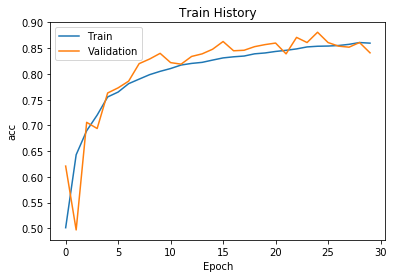

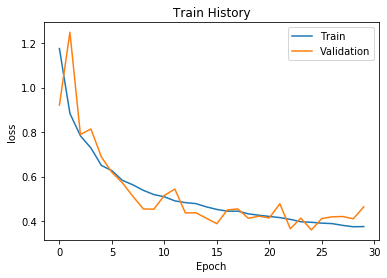

In [255]:
train_history = model.fit_generator(datagen.flow(images_train_features,
                images_train_label, batch_size = 200), epochs = 30,
                validation_data = (images_val_features, images_val_label), 
                steps_per_epoch = 500)
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')

Accuracy score of the test data is 0.86


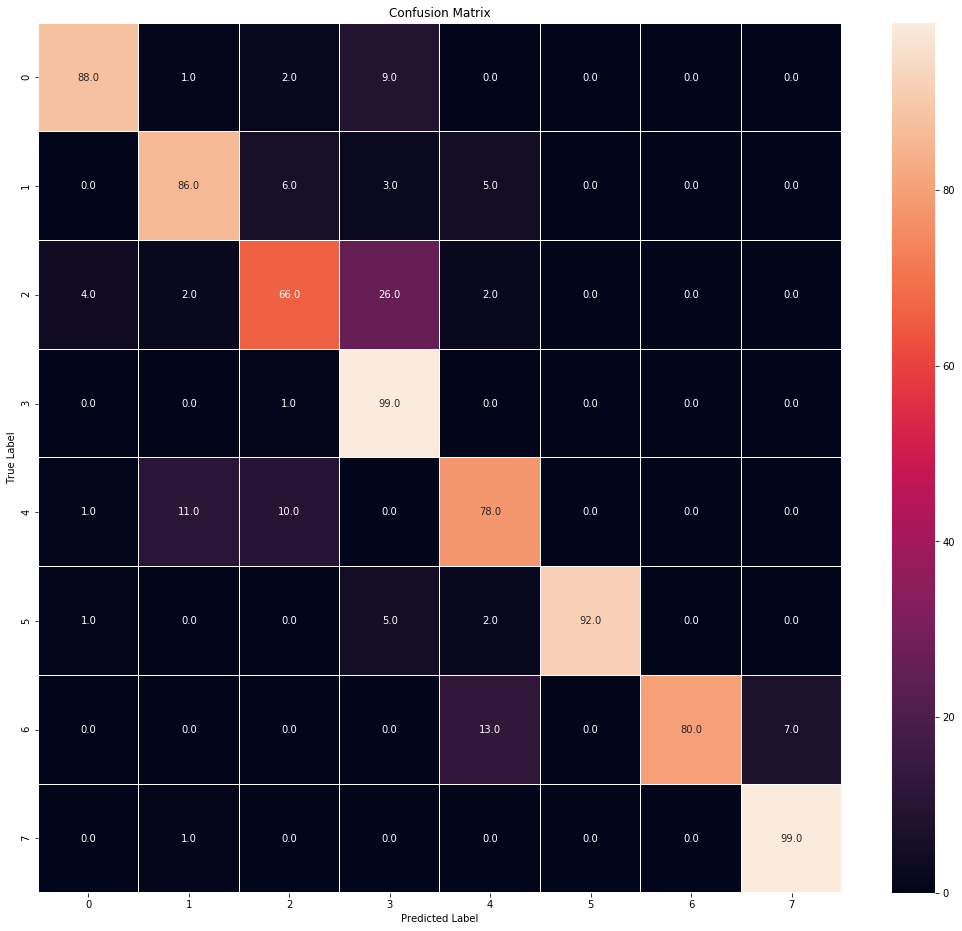

In [403]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Predict the values from the validation dataset
Y_pred = model.predict(images_test_features)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(images_test_label,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Accuracy score of the test data is {}".format(accuracy_score(Y_true, np.argmax(Y_pred, axis=1))))

# plot the confusion matrix
f,ax = plt.subplots(figsize=(18, 16))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [418]:
#Y_true_C=Y_true-1
y_test_dummies = pd.get_dummies(Y_true, drop_first=False).values
Y_true[111]

5

In [421]:
y_test_dummies[111][4]

1

In [382]:
Y_pred[43]

array([0.0000000e+00, 1.1497541e-07, 3.4900125e-07, 3.5628354e-08,
       9.2019532e-14, 9.9999952e-01, 6.8495925e-13, 4.2278714e-09,
       6.1203781e-19], dtype=float32)

In [342]:
Y_pred[15]

array([1.0880137e-28, 9.9829465e-01, 6.3330310e-07, 1.6811483e-03,
       2.2655797e-05, 3.1558538e-09, 8.1111938e-07, 4.3489655e-16,
       3.3760843e-27], dtype=float32)

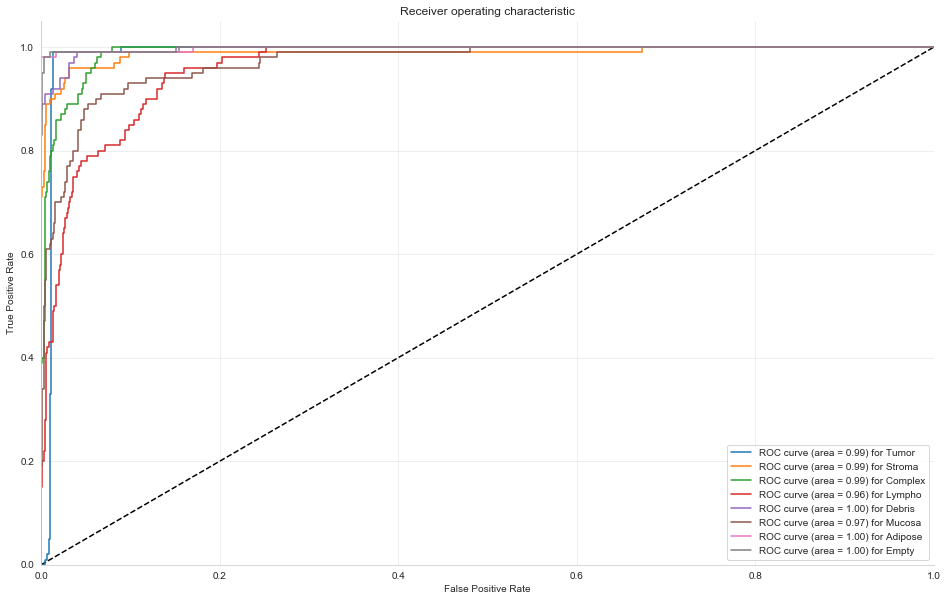

In [431]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_true, y_pred, n_classes, figsize=(17, 6)):
    #y_true_t = y_true-1
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i-1], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_names[i+1]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(Y_true, Y_pred, n_classes=8, figsize=(16, 10))

We can see here that the worst performing class is Lympho. Mucosa also doesn't do too well, but the rest seem to do very well. As we saw in the clustering Empty, Adipose and Debris have an almost perfect classification